<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#Training-model" data-toc-modified-id="Training-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training model</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#Neural-net" data-toc-modified-id="Neural-net-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Neural net</a></span></li><li><span><a href="#Gradient-boosting" data-toc-modified-id="Gradient-boosting-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Gradient boosting</a></span></li><li><span><a href="#Evaluation-of-the-quality-of-the-forecast.-Constant-forecast." data-toc-modified-id="Evaluation-of-the-quality-of-the-forecast.-Constant-forecast.-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Evaluation of the quality of the forecast. Constant forecast.</a></span></li></ul></li><li><span><a href="#Testing-the-model" data-toc-modified-id="Testing-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing the model</a></span></li><li><span><a href="#General-conclusion" data-toc-modified-id="General-conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>General conclusion</a></span></li></ul></div>

#  Forecasting taxi orders

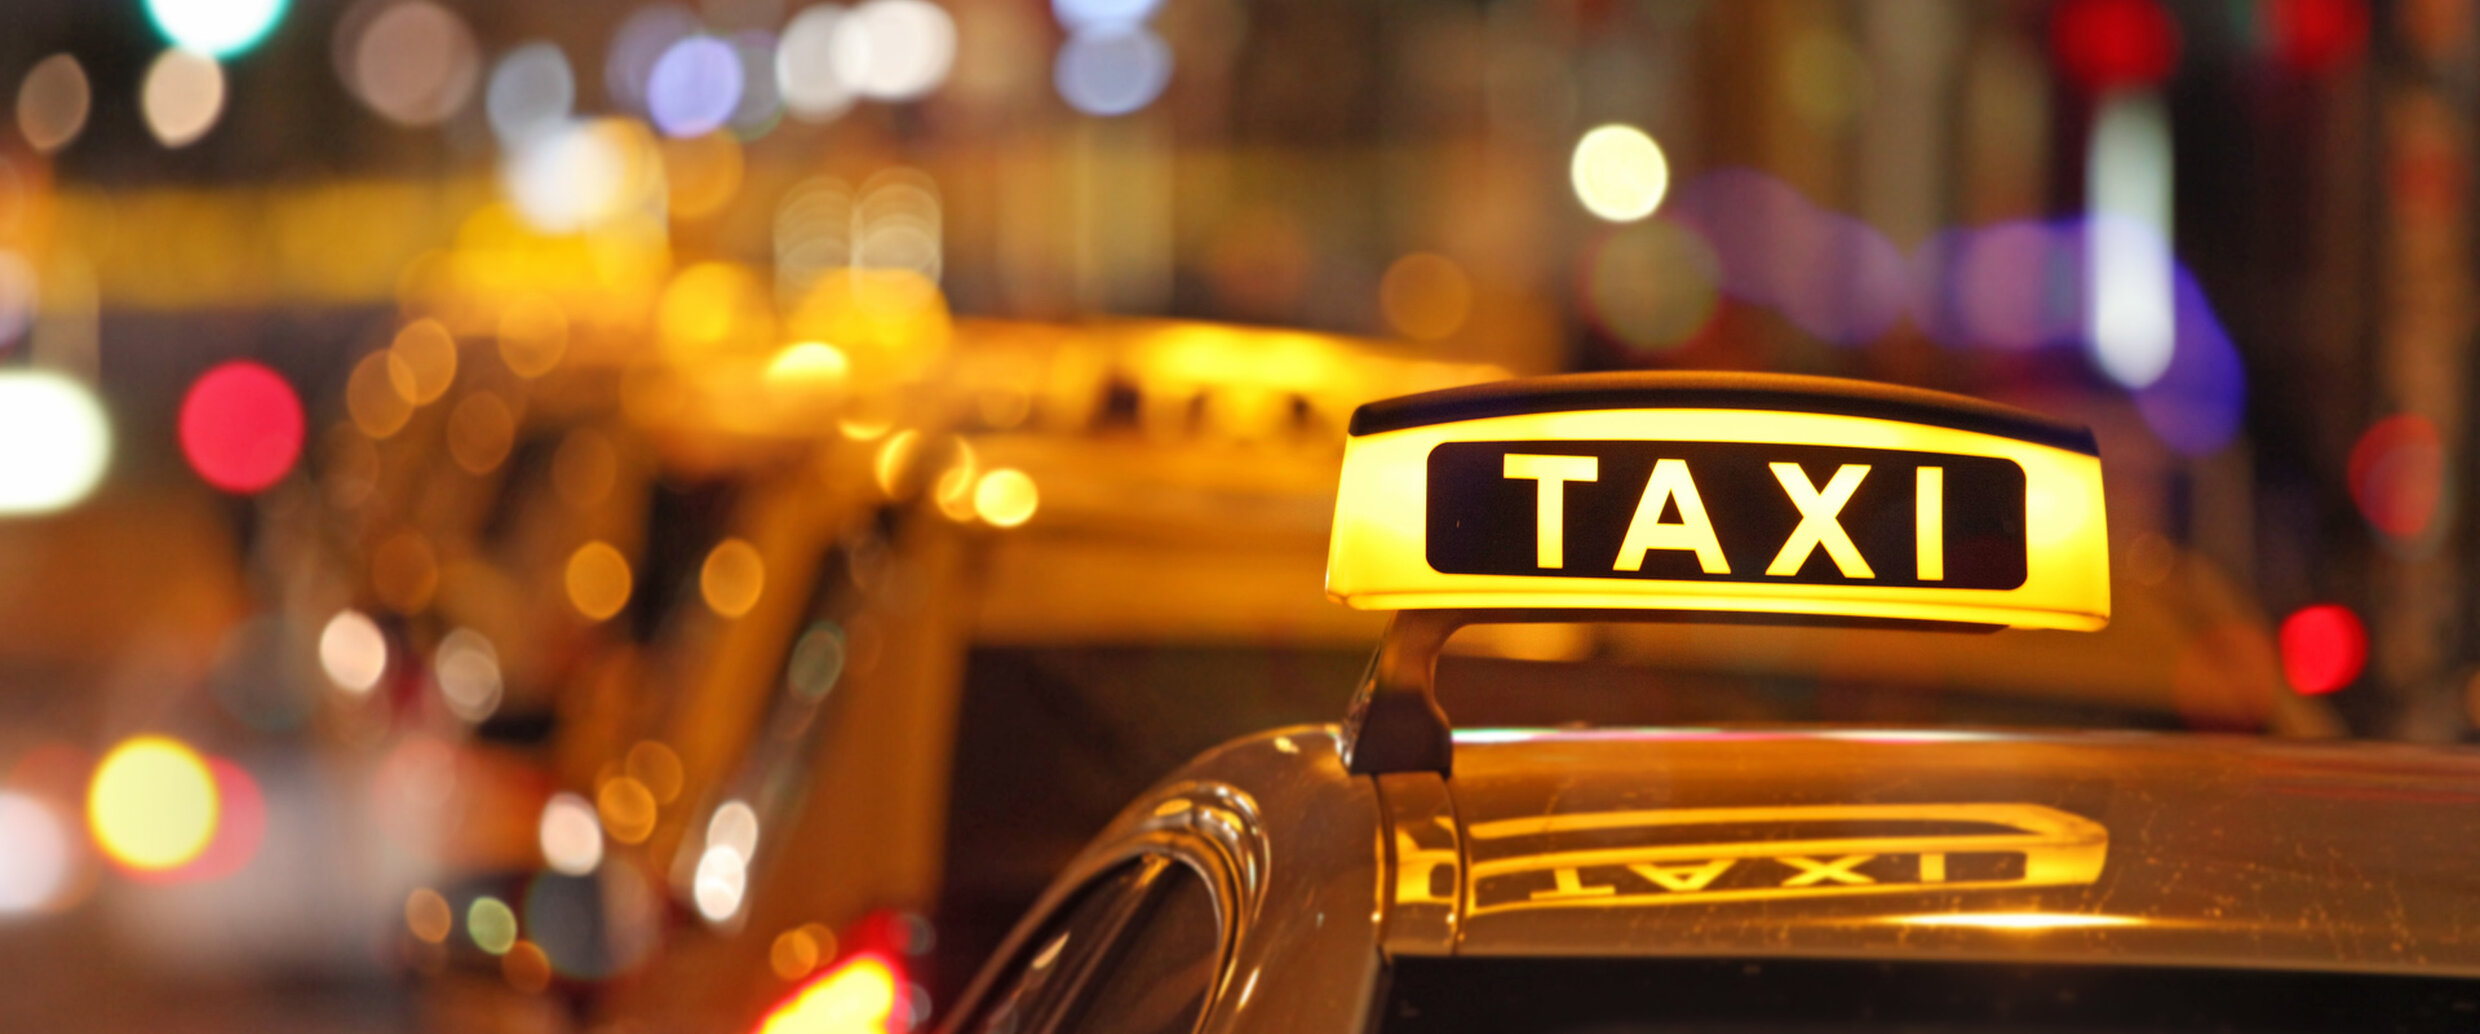

The Accurate Taxi company collects historical data on taxi orders at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour.

Project progress:

- Loading and initial review of data.
- Data analysis.
- Train models with different hyperparameters.
- Checking data on a test sample
- General conclusion.

Objective of the project:

Build the best model. The *RMSE* metric on the test set should not exceed 48.

## Data preparation


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import torch.nn as nn
import torch

from torch import optim
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, cv, Pool, CatBoost

sns.set(color_codes=True)

In [6]:
data = pd.read_csv('C:\\Users\\Vadim\\data\\taxi.csv')
data.head()

datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32

In [7]:
display(data.info())
display(data.describe())
display(data.duplicated().value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

False    26496
dtype: int64

In [8]:
data.datetime = pd.to_datetime(data.datetime)

In [9]:
data = data.set_index('datetime')

In [10]:
data = data.sort_index()
data.index.is_monotonic

True

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Conclusion:**

The data is loaded and sorted by time. No gaps or duplicates found. The dataframe consists of two columns (date and number of orders) and 26496 rows. The data format is `object` and `int64`.

## Data analysis

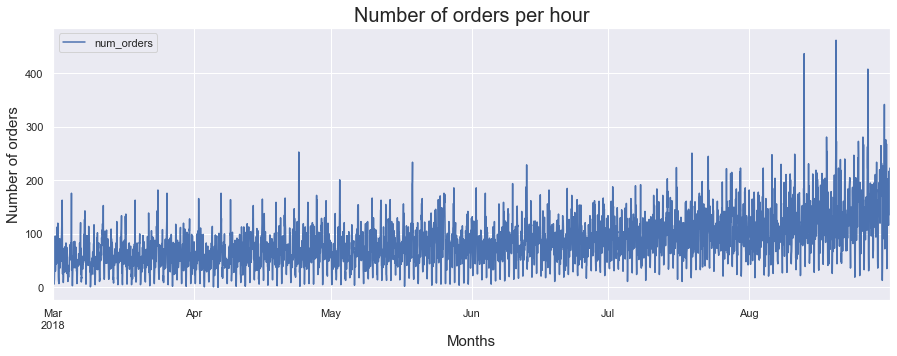

In [12]:
data.resample('1H').sum().plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Number of orders per hour', fontsize=20);

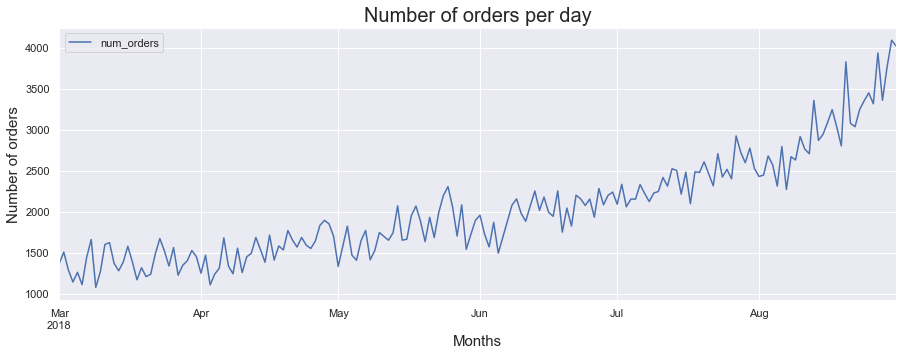

In [13]:
data.resample('1D').sum().plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Number of orders per day', fontsize=20);

The volume of daily orders is growing every month.

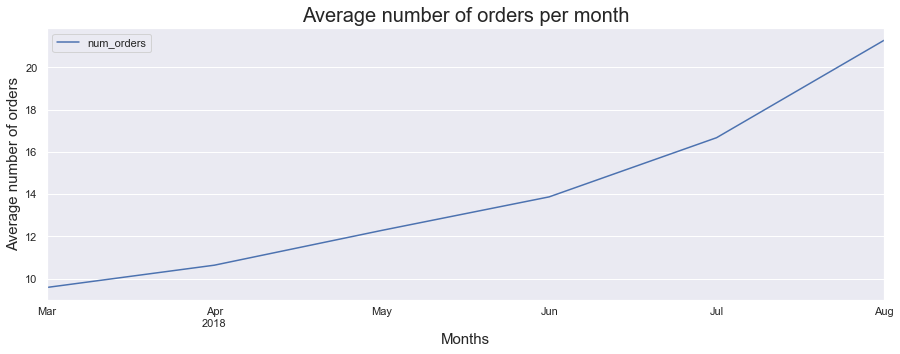

In [14]:
data_month_mean = data.resample('1M').mean()
data_month_mean.plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Average number of orders", fontsize=15)
plt.title('Average number of orders per month', fontsize=20);

The average number of orders per month shows growth.

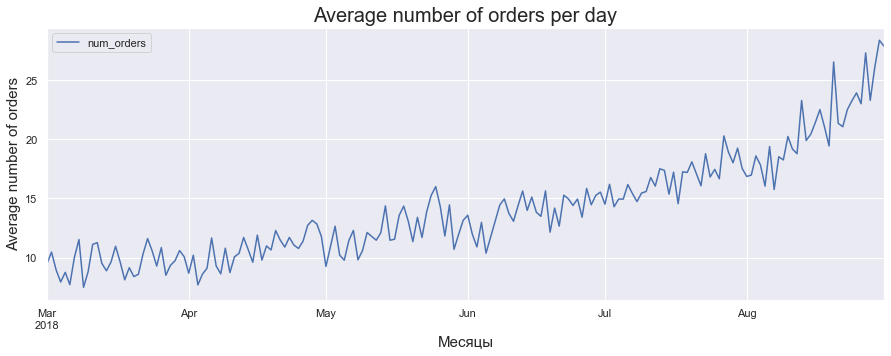

In [15]:
data_day_mean = data.resample('1D').mean()
data_day_mean.plot(figsize=(15, 5))
plt.xlabel("Месяцы", fontsize=15)
plt.ylabel("Average number of orders", fontsize=15)
plt.title('Average number of orders per day', fontsize=20);

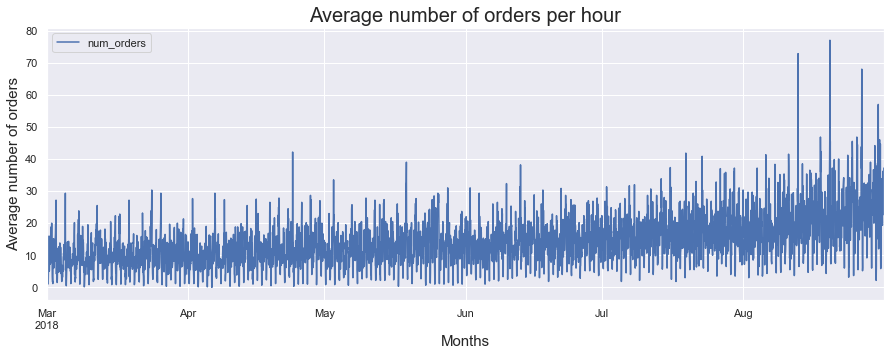

In [16]:
data_1h_mean = data.resample('1H').mean()
data_1h_mean.plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Average number of orders", fontsize=15)
plt.title('Average number of orders per hour', fontsize=20);

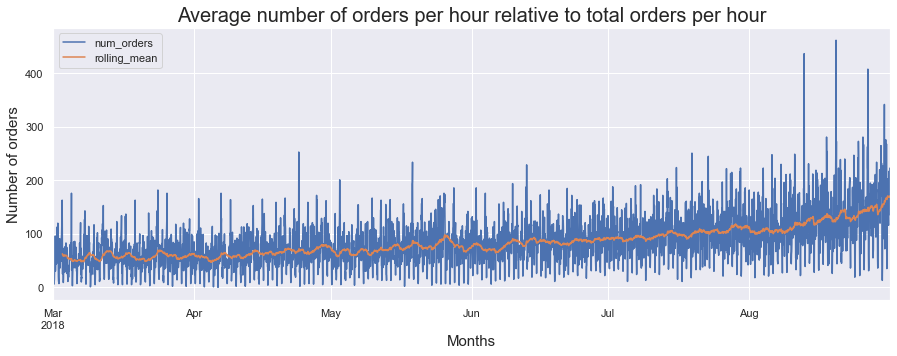

In [17]:
data_1h = data.resample('1H').sum()
data_1h['rolling_mean'] = data_1h.rolling(50).mean()  
data_1h.plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Average number of orders per hour relative to total orders per hour', fontsize=20);

All graphs show an increase in the number of orders over time. Here is a visualization of the average number of orders per hour versus the total orders per hour.

In [18]:
data = data.resample('1H').sum()

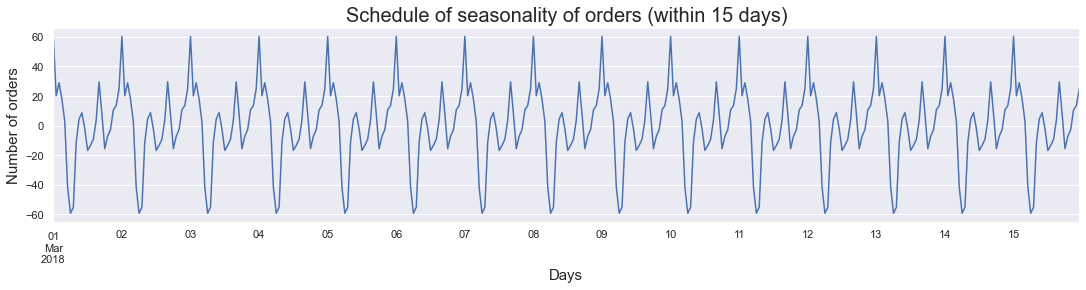

In [19]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 10))
plt.subplot(313)
plt.title('Seasonality')
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-15 23:59:59'].plot(ax=plt.gca())
plt.tight_layout()
plt.xlabel("Days", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Schedule of seasonality of orders (within 15 days)', fontsize=20);

On this chart it is difficult to tell about any regularities. It needs to increase the time interval.

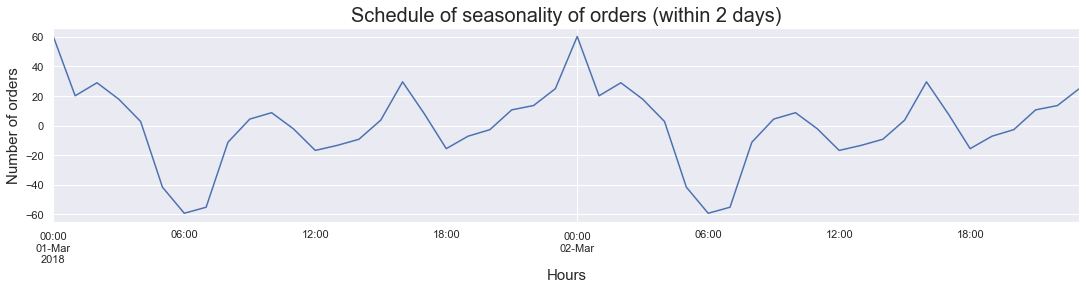

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(313)
plt.title('Seasonality')
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 23:59:59'].plot(ax=plt.gca())
plt.tight_layout()
plt.xlabel("Hours", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Schedule of seasonality of orders (within 2 days)', fontsize=20);

Here the patterns are already visible much better. The peak load occurs at midnight. At 6 am is the minimum. There is an average peak around 16:00 and a small one around 9 am.

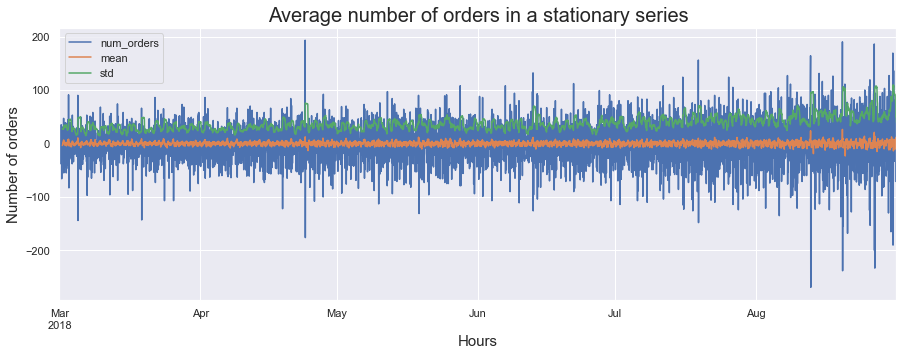

In [21]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(15).mean()
data_shift['std'] = data_shift['num_orders'].rolling(15).std()
data_shift.plot(figsize=(15, 5))
plt.xlabel("Hours", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Average number of orders in a stationary series', fontsize=20);

The graph shows how the mean and standard deviation increase over time. There are more outliers.

**Conclusion:**

The data analysis phase revealed a significant increase in the average number of orders over time. The maximum load is observed at 00:00. Minimum at 6:00. No anomalies were found.

## Training model

### Linear regression

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data_lag = data.copy()
    data_lag['year'] = data_lag.index.year
    data_lag['month'] = data_lag.index.month
    data_lag['day'] = data_lag.index.day
    data_lag['dayofweek'] = data_lag.index.dayofweek
    data_lag['hour'] = data_lag.index.hour
    
    for lag in range(1, max_lag + 1):
        data_lag['lag_{}'.format(lag)] = data_lag['num_orders'].shift(lag)

    data_lag['rolling_mean'] = data_lag['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_lag

In [23]:
%%time
best_max_lag = 0
best_rolling_mean_size = 0
best_rmse_cv = 1000

for max_lag in range(1, 100, 10):
    for rolling_mean_size in range(1, 100, 10):
        data_lag = make_features(data, max_lag, rolling_mean_size)
        
        train_lr, test_lr = train_test_split(data_lag, shuffle=False, test_size=0.1, random_state=35)
        train_lr = train_lr.dropna()
        
        X_train_lr = train_lr.drop(['num_orders'], axis=1)
        y_train_lr = train_lr['num_orders']

        X_test_lr = test_lr.drop(['num_orders'], axis=1)
        y_test_lr = test_lr['num_orders']
        
        model = LinearRegression()
        rmse_cv = np.mean((abs(cross_val_score(model, 
                                  X_train_lr, 
                                  y_train_lr, 
                                  cv=TimeSeriesSplit(n_splits=10), 
                                  scoring='neg_mean_squared_error')) ** 0.5))
        if rmse_cv < best_rmse_cv:
            best_rmse_cv = rmse_cv
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
print('RMSE', best_rmse_cv)
print('Max_lag (количество отстающих значений)', best_max_lag)
print('Rolling_mean_size (размер окна для вычисления среднего)', best_rolling_mean_size)

RMSE 25.429392710440236
Max_lag (количество отстающих значений) 41
Rolling_mean_size (размер окна для вычисления среднего) 51
Wall time: 7.63 s


### Neural net

In [24]:
%%time
best_rmse_valid = 1000
best_loss_list = None
best_rmse_list_train = None
best_rmse_list_valid = None
best_n_hidden_neurons_1 = None
best_n_hidden_neurons_2 = None
best_max_lag = None
best_rolling_mean_size = None

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)  
        
for max_lag in range(1, 100, 10):
    for rolling_mean_size in range(1, 100, 10):
        data_lag = make_features(data, max_lag, rolling_mean_size)
        
        train, sub_valid = train_test_split(data_lag, shuffle=False, test_size=0.2, random_state=35)
        valid, test = train_test_split(sub_valid, shuffle=False, test_size=0.5, random_state=35)
        train = train.dropna()
        
        X_train_ = train.drop(['num_orders'], axis=1)
        y_train_ = train['num_orders']
        
        X_valid_ = valid.drop(['num_orders'], axis=1)
        y_valid_ = valid['num_orders']

        X_test_ = test.drop(['num_orders'], axis=1)
        y_test_ = test['num_orders']
        
        X_train = torch.FloatTensor(X_train_.values)
        X_test = torch.FloatTensor(X_test_.values)
        X_valid = torch.FloatTensor(X_valid_.values)
        y_train = torch.FloatTensor(y_train_.values)
        y_test = torch.FloatTensor(y_test_.values)
        y_valid = torch.FloatTensor(y_valid_.values)
      
        for n_hidden_neurons_1 in [20, 40, 80]:
            for n_hidden_neurons_2 in [2, 4, 8]:
        
                n_in_neurons = X_valid_.shape[1]
                n_out_neurons = 1 

                net = nn.Sequential(
                    nn.Linear(n_in_neurons, n_hidden_neurons_1),
                    nn.ReLU(),
                    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
                    nn.ReLU(),
                    nn.Linear(n_hidden_neurons_2, n_out_neurons)
                )

                optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

                loss = nn.MSELoss()

                num_epochs = 100

                loss_list = []
                rmse_list_train = []
                rmse_list_valid = []
                
                for epoch in range(num_epochs):
    
                    optimizer.zero_grad()

                    preds_train = net.forward(X_train).flatten()
    
                    loss_value = loss(preds_train , y_train)

                    loss_value.backward()
      
                    optimizer.step()
    
                    loss_list.append(loss_value.detach().numpy()) 
    
                    RMSE_train = torch.sqrt(loss(preds_train, y_train)) 
    
                    rmse_list_train.append(RMSE_train.detach().numpy())
    
                    net.eval()
    
                    preds_valid = net.forward(X_valid).flatten()
    
                    RMSE_valid = torch.sqrt(loss(preds_valid, y_valid)) 
    
                    rmse_list_valid.append(RMSE_valid.detach().numpy())
    
                min_rmse_valid = min(rmse_list_valid)
        
                if best_rmse_valid > min_rmse_valid:
                    best_rmse_valid = min_rmse_valid 
                    best_loss_list = loss_list
                    best_rmse_list_train = rmse_list_train
                    best_rmse_list_valid = rmse_list_valid
                    best_n_hidden_neurons_1 = n_hidden_neurons_1
                    best_n_hidden_neurons_2 = n_hidden_neurons_2
                    best_max_lag = max_lag
                    best_rolling_mean_size = rolling_mean_size
            
for i in range(len(best_rmse_list_train)):
    if i % 10 == 0 or i == len(best_rmse_list_train) - 1:     
        print(best_rmse_list_train[i], best_rmse_list_valid[i], i)

56.859386 72.608475 0
33.06885 50.833275 10
31.197794 47.54104 20
28.717073 40.89075 30
25.461006 36.137203 40
23.84407 31.96946 50
22.900112 30.884285 60
22.38193 30.848948 70
22.002157 30.46932 80
21.75157 30.271833 90
21.623726 30.4076 99
Wall time: 2min 16s


In [25]:
hyperparameters_df = pd.DataFrame({'hyperparameters': ['n_hidden_neurons_1:', 'n_hidden_neurons_2:', 'max_lag:', 'rolling_mean_size:'],
              'value': [best_n_hidden_neurons_1, best_n_hidden_neurons_2, best_max_lag, best_rolling_mean_size]})
hyperparameters_df.style.set_properties(align="right")  

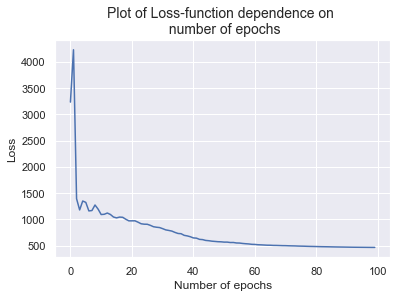

In [26]:
plt.plot(range(num_epochs), best_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Plot of Loss-function dependence on \n number of epochs', fontsize=14)
plt.show()

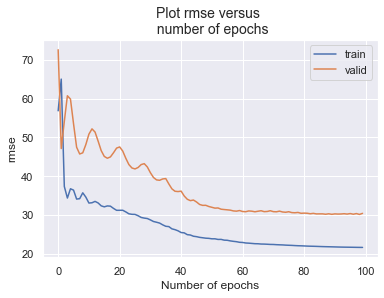

In [27]:
plt.plot(range(num_epochs), best_rmse_list_train)
plt.plot(range(num_epochs), best_rmse_list_valid)
plt.xlabel("Number of epochs")
plt.ylabel("rmse")
plt.legend(['train', 'valid'])
plt.title('Plot rmse versus \n number of epochs', fontsize=14)
plt.show() 

### Gradient boosting

In [28]:
%%time

grid = {'iterations': [200, 400, 800],
        'learning_rate': [0.01, 0.02, 0.03],
        'depth': [4, 6, 8],
       }
model = CatBoostRegressor(grow_policy='SymmetricTree',
                           random_state=35,
                           verbose=1,
                           loss_function='RMSE', 
                           eval_metric='RMSE')

grid_search_result = model.grid_search(grid,                                    
                                       X=X_train_, 
                                       y=y_train_,
                                       cv=TimeSeriesSplit(n_splits=5),
                                       partition_random_seed=1,
                                       calc_cv_statistics=True,
                                       search_by_train_test_split=True,
                                       train_size=0.8,
                                       refit=True,
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76.3422802	test: 102.5578148	best: 102.5578148 (0)	total: 124ms	remaining: 24.7s
1:	learn: 75.6921013	test: 101.8048582	best: 101.8048582 (1)	total: 126ms	remaining: 12.5s
2:	learn: 75.0477559	test: 101.0317996	best: 101.0317996 (2)	total: 128ms	remaining: 8.4s
3:	learn: 74.3969482	test: 100.2995744	best: 100.2995744 (3)	total: 130ms	remaining: 6.36s
4:	learn: 73.7607484	test: 99.6452582	best: 99.6452582 (4)	total: 132ms	remaining: 5.14s
5:	learn: 73.1437910	test: 98.9357844	best: 98.9357844 (5)	total: 134ms	remaining: 4.33s
6:	learn: 72.5634712	test: 98.2981790	best: 98.2981790 (6)	total: 136ms	remaining: 3.74s
7:	learn: 71.9723360	test: 97.6283354	best: 97.6283354 (7)	total: 137ms	remaining: 3.29s
8:	learn: 71.3682442	test: 96.9515557	best: 96.9515557 (8)	total: 139ms	remaining: 2.95s
9:	learn: 70.7687904	test: 96.2925450	best: 96.2925450 (9)	total: 141ms	remaining: 2.68s
10:	learn: 70.1819793	test: 95.6087650	best: 95.6087650 (10)	total: 143ms	remaining: 2.45s
11:	learn: 6

174:	learn: 26.4954501	test: 39.5860155	best: 39.5860155 (174)	total: 482ms	remaining: 68.9ms
175:	learn: 26.4132741	test: 39.4461143	best: 39.4461143 (175)	total: 484ms	remaining: 66ms
176:	learn: 26.3268423	test: 39.2795598	best: 39.2795598 (176)	total: 486ms	remaining: 63.2ms
177:	learn: 26.2447328	test: 39.1340729	best: 39.1340729 (177)	total: 489ms	remaining: 60.4ms
178:	learn: 26.1689713	test: 39.0170899	best: 39.0170899 (178)	total: 491ms	remaining: 57.6ms
179:	learn: 26.0905319	test: 38.8912332	best: 38.8912332 (179)	total: 493ms	remaining: 54.8ms
180:	learn: 26.0128256	test: 38.7594088	best: 38.7594088 (180)	total: 496ms	remaining: 52ms
181:	learn: 25.9478885	test: 38.6473402	best: 38.6473402 (181)	total: 498ms	remaining: 49.2ms
182:	learn: 25.8673065	test: 38.5011078	best: 38.5011078 (182)	total: 500ms	remaining: 46.5ms
183:	learn: 25.7922561	test: 38.3792940	best: 38.3792940 (183)	total: 502ms	remaining: 43.7ms
184:	learn: 25.7162955	test: 38.2841738	best: 38.2841738 (184)	t

124:	learn: 22.5451549	test: 32.7125325	best: 32.7125325 (124)	total: 291ms	remaining: 175ms
125:	learn: 22.4775500	test: 32.5640789	best: 32.5640789 (125)	total: 293ms	remaining: 172ms
126:	learn: 22.4149520	test: 32.4155950	best: 32.4155950 (126)	total: 296ms	remaining: 170ms
127:	learn: 22.3593970	test: 32.3118085	best: 32.3118085 (127)	total: 298ms	remaining: 167ms
128:	learn: 22.3066994	test: 32.2039935	best: 32.2039935 (128)	total: 300ms	remaining: 165ms
129:	learn: 22.2487260	test: 32.0750580	best: 32.0750580 (129)	total: 302ms	remaining: 162ms
130:	learn: 22.1923003	test: 31.9543127	best: 31.9543127 (130)	total: 304ms	remaining: 160ms
131:	learn: 22.1408655	test: 31.8487300	best: 31.8487300 (131)	total: 306ms	remaining: 158ms
132:	learn: 22.0863630	test: 31.7173564	best: 31.7173564 (132)	total: 308ms	remaining: 155ms
133:	learn: 22.0348537	test: 31.6157680	best: 31.6157680 (133)	total: 310ms	remaining: 153ms
134:	learn: 21.9838203	test: 31.4943553	best: 31.4943553 (134)	total: 

84:	learn: 22.4722223	test: 32.1397250	best: 32.1397250 (84)	total: 197ms	remaining: 266ms
85:	learn: 22.3919310	test: 31.9883098	best: 31.9883098 (85)	total: 199ms	remaining: 263ms
86:	learn: 22.3164250	test: 31.8394557	best: 31.8394557 (86)	total: 201ms	remaining: 261ms
87:	learn: 22.2462686	test: 31.7256402	best: 31.7256402 (87)	total: 203ms	remaining: 258ms
88:	learn: 22.1632420	test: 31.5359626	best: 31.5359626 (88)	total: 205ms	remaining: 255ms
89:	learn: 22.0966520	test: 31.3980257	best: 31.3980257 (89)	total: 207ms	remaining: 253ms
90:	learn: 22.0200052	test: 31.2538785	best: 31.2538785 (90)	total: 209ms	remaining: 250ms
91:	learn: 21.9461596	test: 31.0735551	best: 31.0735551 (91)	total: 211ms	remaining: 247ms
92:	learn: 21.8674757	test: 30.9241322	best: 30.9241322 (92)	total: 212ms	remaining: 244ms
93:	learn: 21.8165926	test: 30.8329510	best: 30.8329510 (93)	total: 215ms	remaining: 242ms
94:	learn: 21.7563617	test: 30.7179324	best: 30.7179324 (94)	total: 216ms	remaining: 239ms

49:	learn: 51.5879587	test: 73.8228018	best: 73.8228018 (49)	total: 123ms	remaining: 859ms
50:	learn: 51.2041890	test: 73.3631757	best: 73.3631757 (50)	total: 125ms	remaining: 855ms
51:	learn: 50.8123238	test: 72.8283077	best: 72.8283077 (51)	total: 127ms	remaining: 850ms
52:	learn: 50.4465199	test: 72.3761596	best: 72.3761596 (52)	total: 129ms	remaining: 844ms
53:	learn: 50.0874180	test: 71.9080800	best: 71.9080800 (53)	total: 131ms	remaining: 840ms
54:	learn: 49.7247077	test: 71.4809765	best: 71.4809765 (54)	total: 133ms	remaining: 834ms
55:	learn: 49.3864591	test: 71.0827166	best: 71.0827166 (55)	total: 135ms	remaining: 828ms
56:	learn: 49.0186773	test: 70.6313569	best: 70.6313569 (56)	total: 137ms	remaining: 823ms
57:	learn: 48.6696155	test: 70.1793849	best: 70.1793849 (57)	total: 139ms	remaining: 819ms
58:	learn: 48.3130783	test: 69.7467010	best: 69.7467010 (58)	total: 141ms	remaining: 813ms
59:	learn: 47.9775264	test: 69.3105042	best: 69.3105042 (59)	total: 142ms	remaining: 807ms

223:	learn: 23.4699086	test: 34.2667802	best: 34.2667802 (223)	total: 472ms	remaining: 371ms
224:	learn: 23.4308666	test: 34.1779203	best: 34.1779203 (224)	total: 474ms	remaining: 369ms
225:	learn: 23.3842747	test: 34.1003885	best: 34.1003885 (225)	total: 476ms	remaining: 367ms
226:	learn: 23.3418633	test: 34.0219040	best: 34.0219040 (226)	total: 478ms	remaining: 365ms
227:	learn: 23.2927867	test: 33.9325394	best: 33.9325394 (227)	total: 480ms	remaining: 362ms
228:	learn: 23.2524002	test: 33.8467891	best: 33.8467891 (228)	total: 482ms	remaining: 360ms
229:	learn: 23.2124933	test: 33.7610180	best: 33.7610180 (229)	total: 485ms	remaining: 358ms
230:	learn: 23.1755919	test: 33.6816749	best: 33.6816749 (230)	total: 487ms	remaining: 356ms
231:	learn: 23.1345506	test: 33.5975124	best: 33.5975124 (231)	total: 489ms	remaining: 354ms
232:	learn: 23.0970171	test: 33.5087171	best: 33.5087171 (232)	total: 491ms	remaining: 352ms
233:	learn: 23.0604529	test: 33.4529240	best: 33.4529240 (233)	total: 

393:	learn: 20.2767822	test: 27.7363226	best: 27.7363226 (393)	total: 830ms	remaining: 12.6ms
394:	learn: 20.2687064	test: 27.7199125	best: 27.7199125 (394)	total: 832ms	remaining: 10.5ms
395:	learn: 20.2622587	test: 27.6985300	best: 27.6985300 (395)	total: 834ms	remaining: 8.42ms
396:	learn: 20.2522282	test: 27.6740245	best: 27.6740245 (396)	total: 836ms	remaining: 6.32ms
397:	learn: 20.2438779	test: 27.6537306	best: 27.6537306 (397)	total: 838ms	remaining: 4.21ms
398:	learn: 20.2350910	test: 27.6394244	best: 27.6394244 (398)	total: 840ms	remaining: 2.1ms
399:	learn: 20.2283689	test: 27.6295590	best: 27.6295590 (399)	total: 842ms	remaining: 0us

bestTest = 27.62955901
bestIteration = 399

0:	learn: 75.6972894	test: 101.8595218	best: 101.8595218 (0)	total: 16.9ms	remaining: 6.75s
1:	learn: 74.4116379	test: 100.3684919	best: 100.3684919 (1)	total: 18.8ms	remaining: 3.74s
2:	learn: 73.1512456	test: 98.8516658	best: 98.8516658 (2)	total: 20.9ms	remaining: 2.77s
3:	learn: 71.8908821	test: 

160:	learn: 21.0463548	test: 29.4890148	best: 29.4890148 (160)	total: 345ms	remaining: 512ms
161:	learn: 21.0204084	test: 29.4544897	best: 29.4544897 (161)	total: 347ms	remaining: 510ms
162:	learn: 20.9957546	test: 29.3781184	best: 29.3781184 (162)	total: 349ms	remaining: 508ms
163:	learn: 20.9705262	test: 29.3309570	best: 29.3309570 (163)	total: 351ms	remaining: 505ms
164:	learn: 20.9492927	test: 29.2790965	best: 29.2790965 (164)	total: 353ms	remaining: 503ms
165:	learn: 20.9231239	test: 29.2291334	best: 29.2291334 (165)	total: 355ms	remaining: 501ms
166:	learn: 20.9010348	test: 29.1806810	best: 29.1806810 (166)	total: 357ms	remaining: 498ms
167:	learn: 20.8783725	test: 29.1142348	best: 29.1142348 (167)	total: 359ms	remaining: 496ms
168:	learn: 20.8529556	test: 29.0575143	best: 29.0575143 (168)	total: 362ms	remaining: 494ms
169:	learn: 20.8202531	test: 28.9976864	best: 28.9976864 (169)	total: 363ms	remaining: 492ms
170:	learn: 20.7956863	test: 28.9303992	best: 28.9303992 (170)	total: 

249:	learn: 19.6296580	test: 26.8629644	best: 26.8629644 (249)	total: 530ms	remaining: 318ms
250:	learn: 19.6211142	test: 26.8452562	best: 26.8452562 (250)	total: 532ms	remaining: 316ms
251:	learn: 19.6127088	test: 26.8253518	best: 26.8253518 (251)	total: 534ms	remaining: 314ms
252:	learn: 19.6045406	test: 26.8141458	best: 26.8141458 (252)	total: 536ms	remaining: 311ms
253:	learn: 19.5948229	test: 26.8055556	best: 26.8055556 (253)	total: 538ms	remaining: 309ms
254:	learn: 19.5877921	test: 26.7834584	best: 26.7834584 (254)	total: 540ms	remaining: 307ms
255:	learn: 19.5791686	test: 26.7693250	best: 26.7693250 (255)	total: 542ms	remaining: 305ms
256:	learn: 19.5707800	test: 26.7609325	best: 26.7609325 (256)	total: 544ms	remaining: 303ms
257:	learn: 19.5597234	test: 26.7593660	best: 26.7593660 (257)	total: 546ms	remaining: 301ms
258:	learn: 19.5531745	test: 26.7602623	best: 26.7593660 (257)	total: 548ms	remaining: 298ms
259:	learn: 19.5417884	test: 26.7466519	best: 26.7466519 (259)	total: 

1:	learn: 73.1469238	test: 98.9476120	best: 98.9476120 (1)	total: 25.9ms	remaining: 5.16s
2:	learn: 71.2900922	test: 96.7205233	best: 96.7205233 (2)	total: 27.7ms	remaining: 3.66s
3:	learn: 69.4606176	test: 94.6522897	best: 94.6522897 (3)	total: 29.5ms	remaining: 2.92s
4:	learn: 67.7097744	test: 92.8351523	best: 92.8351523 (4)	total: 31.4ms	remaining: 2.48s
5:	learn: 66.0562459	test: 90.9111956	best: 90.9111956 (5)	total: 33.1ms	remaining: 2.17s
6:	learn: 64.4354698	test: 89.0230774	best: 89.0230774 (6)	total: 34.8ms	remaining: 1.95s
7:	learn: 62.9252598	test: 87.2845865	best: 87.2845865 (7)	total: 36.5ms	remaining: 1.79s
8:	learn: 61.4016491	test: 85.5359390	best: 85.5359390 (8)	total: 38.5ms	remaining: 1.67s
9:	learn: 59.9357246	test: 83.7649890	best: 83.7649890 (9)	total: 40.2ms	remaining: 1.57s
10:	learn: 58.5278091	test: 82.0836049	best: 82.0836049 (10)	total: 41.8ms	remaining: 1.48s
11:	learn: 57.1757549	test: 80.4784800	best: 80.4784800 (11)	total: 43.5ms	remaining: 1.41s
12:	le

95:	learn: 21.6965840	test: 30.5514861	best: 30.5514861 (95)	total: 206ms	remaining: 654ms
96:	learn: 21.6325945	test: 30.4062007	best: 30.4062007 (96)	total: 208ms	remaining: 651ms
97:	learn: 21.5797896	test: 30.2898073	best: 30.2898073 (97)	total: 210ms	remaining: 649ms
98:	learn: 21.5214913	test: 30.1566546	best: 30.1566546 (98)	total: 212ms	remaining: 646ms
99:	learn: 21.4594124	test: 30.0353778	best: 30.0353778 (99)	total: 214ms	remaining: 643ms
100:	learn: 21.4099849	test: 29.9661476	best: 29.9661476 (100)	total: 216ms	remaining: 641ms
101:	learn: 21.3685900	test: 29.8748657	best: 29.8748657 (101)	total: 219ms	remaining: 638ms
102:	learn: 21.3253417	test: 29.7763449	best: 29.7763449 (102)	total: 221ms	remaining: 636ms
103:	learn: 21.2820572	test: 29.6568491	best: 29.6568491 (103)	total: 223ms	remaining: 634ms
104:	learn: 21.2340512	test: 29.5356364	best: 29.5356364 (104)	total: 225ms	remaining: 631ms
105:	learn: 21.1880096	test: 29.4052065	best: 29.4052065 (105)	total: 227ms	rema

187:	learn: 19.4351015	test: 26.4606040	best: 26.4606040 (187)	total: 384ms	remaining: 433ms
188:	learn: 19.4166420	test: 26.4541807	best: 26.4541807 (188)	total: 386ms	remaining: 431ms
189:	learn: 19.4031301	test: 26.4480271	best: 26.4480271 (189)	total: 389ms	remaining: 430ms
190:	learn: 19.3970357	test: 26.4435367	best: 26.4435367 (190)	total: 391ms	remaining: 427ms
191:	learn: 19.3838530	test: 26.4344793	best: 26.4344793 (191)	total: 393ms	remaining: 425ms
192:	learn: 19.3661859	test: 26.4191440	best: 26.4191440 (192)	total: 395ms	remaining: 423ms
193:	learn: 19.3532538	test: 26.4016405	best: 26.4016405 (193)	total: 396ms	remaining: 421ms
194:	learn: 19.3408311	test: 26.3825000	best: 26.3825000 (194)	total: 398ms	remaining: 419ms
195:	learn: 19.3284101	test: 26.3993003	best: 26.3825000 (194)	total: 401ms	remaining: 417ms
196:	learn: 19.3189387	test: 26.3969566	best: 26.3825000 (194)	total: 402ms	remaining: 415ms
197:	learn: 19.3083383	test: 26.3856656	best: 26.3825000 (194)	total: 

278:	learn: 18.3862556	test: 26.0061202	best: 26.0061202 (278)	total: 561ms	remaining: 243ms
279:	learn: 18.3807379	test: 26.0107104	best: 26.0061202 (278)	total: 563ms	remaining: 241ms
280:	learn: 18.3722381	test: 26.0109611	best: 26.0061202 (278)	total: 565ms	remaining: 239ms
281:	learn: 18.3668683	test: 26.0086764	best: 26.0061202 (278)	total: 567ms	remaining: 237ms
282:	learn: 18.3543394	test: 26.0006598	best: 26.0006598 (282)	total: 569ms	remaining: 235ms
283:	learn: 18.3445414	test: 26.0057324	best: 26.0006598 (282)	total: 571ms	remaining: 233ms
284:	learn: 18.3355955	test: 25.9847807	best: 25.9847807 (284)	total: 573ms	remaining: 231ms
285:	learn: 18.3244536	test: 25.9672585	best: 25.9672585 (285)	total: 575ms	remaining: 229ms
286:	learn: 18.3119939	test: 25.9638932	best: 25.9638932 (286)	total: 577ms	remaining: 227ms
287:	learn: 18.3031431	test: 25.9637433	best: 25.9637433 (287)	total: 579ms	remaining: 225ms
288:	learn: 18.2876949	test: 25.9479180	best: 25.9479180 (288)	total: 

367:	learn: 17.4528264	test: 25.6309581	best: 25.6309581 (367)	total: 728ms	remaining: 63.3ms
368:	learn: 17.4436565	test: 25.6350790	best: 25.6309581 (367)	total: 730ms	remaining: 61.3ms
369:	learn: 17.4331693	test: 25.6378655	best: 25.6309581 (367)	total: 732ms	remaining: 59.3ms
370:	learn: 17.4298776	test: 25.6349393	best: 25.6309581 (367)	total: 734ms	remaining: 57.4ms
371:	learn: 17.4233846	test: 25.6354485	best: 25.6309581 (367)	total: 737ms	remaining: 55.4ms
372:	learn: 17.4104965	test: 25.6312970	best: 25.6309581 (367)	total: 739ms	remaining: 53.5ms
373:	learn: 17.3995367	test: 25.6277466	best: 25.6277466 (373)	total: 741ms	remaining: 51.5ms
374:	learn: 17.3921145	test: 25.6170614	best: 25.6170614 (374)	total: 743ms	remaining: 49.5ms
375:	learn: 17.3839684	test: 25.6179400	best: 25.6170614 (374)	total: 745ms	remaining: 47.5ms
376:	learn: 17.3747714	test: 25.6231491	best: 25.6170614 (374)	total: 746ms	remaining: 45.5ms
377:	learn: 17.3658516	test: 25.6230053	best: 25.6170614 (37

60:	learn: 47.6563106	test: 68.9078167	best: 68.9078167 (60)	total: 119ms	remaining: 1.44s
61:	learn: 47.3173692	test: 68.4788946	best: 68.4788946 (61)	total: 121ms	remaining: 1.44s
62:	learn: 46.9766319	test: 68.0099293	best: 68.0099293 (62)	total: 123ms	remaining: 1.44s
63:	learn: 46.6517433	test: 67.6469646	best: 67.6469646 (63)	total: 125ms	remaining: 1.44s
64:	learn: 46.3168509	test: 67.2035871	best: 67.2035871 (64)	total: 127ms	remaining: 1.44s
65:	learn: 45.9840450	test: 66.7573044	best: 66.7573044 (65)	total: 130ms	remaining: 1.44s
66:	learn: 45.6662337	test: 66.3780256	best: 66.3780256 (66)	total: 131ms	remaining: 1.44s
67:	learn: 45.3520696	test: 65.9877393	best: 65.9877393 (67)	total: 133ms	remaining: 1.44s
68:	learn: 45.0414543	test: 65.5765811	best: 65.5765811 (68)	total: 135ms	remaining: 1.43s
69:	learn: 44.7329430	test: 65.1601506	best: 65.1601506 (69)	total: 137ms	remaining: 1.43s
70:	learn: 44.4225210	test: 64.7540893	best: 64.7540893 (70)	total: 139ms	remaining: 1.43s

150:	learn: 28.8346052	test: 43.4747421	best: 43.4747421 (150)	total: 298ms	remaining: 1.28s
151:	learn: 28.7216980	test: 43.3081503	best: 43.3081503 (151)	total: 300ms	remaining: 1.28s
152:	learn: 28.6081873	test: 43.1294448	best: 43.1294448 (152)	total: 303ms	remaining: 1.28s
153:	learn: 28.4987663	test: 42.9630525	best: 42.9630525 (153)	total: 304ms	remaining: 1.28s
154:	learn: 28.3948869	test: 42.8158133	best: 42.8158133 (154)	total: 306ms	remaining: 1.27s
155:	learn: 28.2911904	test: 42.6615321	best: 42.6615321 (155)	total: 309ms	remaining: 1.27s
156:	learn: 28.1877225	test: 42.4975584	best: 42.4975584 (156)	total: 311ms	remaining: 1.27s
157:	learn: 28.0878603	test: 42.3158916	best: 42.3158916 (157)	total: 313ms	remaining: 1.27s
158:	learn: 27.9805176	test: 42.1285043	best: 42.1285043 (158)	total: 315ms	remaining: 1.27s
159:	learn: 27.8754399	test: 41.9628302	best: 41.9628302 (159)	total: 317ms	remaining: 1.27s
160:	learn: 27.7726851	test: 41.7639973	best: 41.7639973 (160)	total: 

243:	learn: 22.7039197	test: 32.7722884	best: 32.7722884 (243)	total: 485ms	remaining: 1.1s
244:	learn: 22.6695887	test: 32.7082833	best: 32.7082833 (244)	total: 487ms	remaining: 1.1s
245:	learn: 22.6368262	test: 32.6396144	best: 32.6396144 (245)	total: 489ms	remaining: 1.1s
246:	learn: 22.6031258	test: 32.5556654	best: 32.5556654 (246)	total: 491ms	remaining: 1.1s
247:	learn: 22.5734111	test: 32.4930296	best: 32.4930296 (247)	total: 493ms	remaining: 1.1s
248:	learn: 22.5424263	test: 32.4372750	best: 32.4372750 (248)	total: 495ms	remaining: 1.1s
249:	learn: 22.5128260	test: 32.3854271	best: 32.3854271 (249)	total: 497ms	remaining: 1.09s
250:	learn: 22.4789812	test: 32.3179542	best: 32.3179542 (250)	total: 500ms	remaining: 1.09s
251:	learn: 22.4513765	test: 32.2478900	best: 32.2478900 (251)	total: 502ms	remaining: 1.09s
252:	learn: 22.4223720	test: 32.1793158	best: 32.1793158 (252)	total: 504ms	remaining: 1.09s
253:	learn: 22.3945781	test: 32.1146437	best: 32.1146437 (253)	total: 506ms	

415:	learn: 20.1146651	test: 27.4736790	best: 27.4736790 (415)	total: 826ms	remaining: 762ms
416:	learn: 20.1092909	test: 27.4675518	best: 27.4675518 (416)	total: 828ms	remaining: 760ms
417:	learn: 20.1021962	test: 27.4526180	best: 27.4526180 (417)	total: 830ms	remaining: 759ms
418:	learn: 20.0940686	test: 27.4334065	best: 27.4334065 (418)	total: 832ms	remaining: 756ms
419:	learn: 20.0883670	test: 27.4260661	best: 27.4260661 (419)	total: 834ms	remaining: 755ms
420:	learn: 20.0811875	test: 27.4109814	best: 27.4109814 (420)	total: 836ms	remaining: 753ms
421:	learn: 20.0749392	test: 27.3944898	best: 27.3944898 (421)	total: 838ms	remaining: 751ms
422:	learn: 20.0649925	test: 27.3877212	best: 27.3877212 (422)	total: 840ms	remaining: 749ms
423:	learn: 20.0608795	test: 27.3794016	best: 27.3794016 (423)	total: 842ms	remaining: 747ms
424:	learn: 20.0556312	test: 27.3679791	best: 27.3679791 (424)	total: 844ms	remaining: 745ms
425:	learn: 20.0490087	test: 27.3576171	best: 27.3576171 (425)	total: 

511:	learn: 19.5847990	test: 26.7111192	best: 26.7111192 (511)	total: 1.02s	remaining: 572ms
512:	learn: 19.5818641	test: 26.7077448	best: 26.7077448 (512)	total: 1.02s	remaining: 570ms
513:	learn: 19.5779651	test: 26.7060738	best: 26.7060738 (513)	total: 1.02s	remaining: 568ms
514:	learn: 19.5736436	test: 26.6918612	best: 26.6918612 (514)	total: 1.02s	remaining: 566ms
515:	learn: 19.5690237	test: 26.6845923	best: 26.6845923 (515)	total: 1.02s	remaining: 564ms
516:	learn: 19.5635435	test: 26.6802884	best: 26.6802884 (516)	total: 1.03s	remaining: 562ms
517:	learn: 19.5589237	test: 26.6778251	best: 26.6778251 (517)	total: 1.03s	remaining: 560ms
518:	learn: 19.5550190	test: 26.6753788	best: 26.6753788 (518)	total: 1.03s	remaining: 558ms
519:	learn: 19.5501107	test: 26.6651190	best: 26.6651190 (519)	total: 1.03s	remaining: 556ms
520:	learn: 19.5451344	test: 26.6522610	best: 26.6522610 (520)	total: 1.03s	remaining: 554ms
521:	learn: 19.5378903	test: 26.6367140	best: 26.6367140 (521)	total: 

601:	learn: 19.1925262	test: 26.3229920	best: 26.3229920 (601)	total: 1.19s	remaining: 392ms
602:	learn: 19.1907594	test: 26.3207402	best: 26.3207402 (602)	total: 1.19s	remaining: 390ms
603:	learn: 19.1841733	test: 26.3190878	best: 26.3190878 (603)	total: 1.2s	remaining: 388ms
604:	learn: 19.1803383	test: 26.3111369	best: 26.3111369 (604)	total: 1.2s	remaining: 386ms
605:	learn: 19.1774156	test: 26.3070938	best: 26.3070938 (605)	total: 1.2s	remaining: 384ms
606:	learn: 19.1737967	test: 26.3064676	best: 26.3064676 (606)	total: 1.2s	remaining: 382ms
607:	learn: 19.1702007	test: 26.3041162	best: 26.3041162 (607)	total: 1.21s	remaining: 381ms
608:	learn: 19.1661771	test: 26.3032379	best: 26.3032379 (608)	total: 1.21s	remaining: 379ms
609:	learn: 19.1612803	test: 26.2998912	best: 26.2998912 (609)	total: 1.21s	remaining: 377ms
610:	learn: 19.1586419	test: 26.2980246	best: 26.2980246 (610)	total: 1.21s	remaining: 375ms
611:	learn: 19.1526134	test: 26.2868801	best: 26.2868801 (611)	total: 1.21

778:	learn: 18.5472153	test: 25.9738234	best: 25.9729091 (777)	total: 1.54s	remaining: 41.5ms
779:	learn: 18.5428302	test: 25.9698989	best: 25.9698989 (779)	total: 1.54s	remaining: 39.5ms
780:	learn: 18.5407285	test: 25.9690377	best: 25.9690377 (780)	total: 1.54s	remaining: 37.5ms
781:	learn: 18.5352588	test: 25.9633411	best: 25.9633411 (781)	total: 1.54s	remaining: 35.5ms
782:	learn: 18.5325952	test: 25.9630318	best: 25.9630318 (782)	total: 1.55s	remaining: 33.6ms
783:	learn: 18.5298094	test: 25.9616838	best: 25.9616838 (783)	total: 1.55s	remaining: 31.6ms
784:	learn: 18.5264098	test: 25.9640188	best: 25.9616838 (783)	total: 1.55s	remaining: 29.6ms
785:	learn: 18.5238830	test: 25.9623354	best: 25.9616838 (783)	total: 1.55s	remaining: 27.6ms
786:	learn: 18.5194802	test: 25.9603738	best: 25.9603738 (786)	total: 1.55s	remaining: 25.7ms
787:	learn: 18.5170904	test: 25.9592981	best: 25.9592981 (787)	total: 1.56s	remaining: 23.7ms
788:	learn: 18.5139972	test: 25.9549657	best: 25.9549657 (78

157:	learn: 21.1279514	test: 29.6548153	best: 29.6548153 (157)	total: 323ms	remaining: 1.31s
158:	learn: 21.0933693	test: 29.5903521	best: 29.5903521 (158)	total: 325ms	remaining: 1.31s
159:	learn: 21.0687654	test: 29.5459548	best: 29.5459548 (159)	total: 327ms	remaining: 1.31s
160:	learn: 21.0463548	test: 29.4890148	best: 29.4890148 (160)	total: 329ms	remaining: 1.31s
161:	learn: 21.0204084	test: 29.4544897	best: 29.4544897 (161)	total: 331ms	remaining: 1.3s
162:	learn: 20.9957546	test: 29.3781184	best: 29.3781184 (162)	total: 333ms	remaining: 1.3s
163:	learn: 20.9705262	test: 29.3309570	best: 29.3309570 (163)	total: 335ms	remaining: 1.3s
164:	learn: 20.9492927	test: 29.2790965	best: 29.2790965 (164)	total: 337ms	remaining: 1.3s
165:	learn: 20.9231239	test: 29.2291334	best: 29.2291334 (165)	total: 339ms	remaining: 1.29s
166:	learn: 20.9010348	test: 29.1806810	best: 29.1806810 (166)	total: 341ms	remaining: 1.29s
167:	learn: 20.8783725	test: 29.1142348	best: 29.1142348 (167)	total: 343m

335:	learn: 18.9434488	test: 26.2813551	best: 26.2813551 (335)	total: 684ms	remaining: 945ms
336:	learn: 18.9382374	test: 26.2832663	best: 26.2813551 (335)	total: 686ms	remaining: 943ms
337:	learn: 18.9304423	test: 26.2765786	best: 26.2765786 (337)	total: 688ms	remaining: 941ms
338:	learn: 18.9246137	test: 26.2755373	best: 26.2755373 (338)	total: 690ms	remaining: 939ms
339:	learn: 18.9177507	test: 26.2620565	best: 26.2620565 (339)	total: 693ms	remaining: 937ms
340:	learn: 18.9112881	test: 26.2565398	best: 26.2565398 (340)	total: 694ms	remaining: 935ms
341:	learn: 18.9059971	test: 26.2523777	best: 26.2523777 (341)	total: 696ms	remaining: 933ms
342:	learn: 18.8985533	test: 26.2433786	best: 26.2433786 (342)	total: 699ms	remaining: 931ms
343:	learn: 18.8915452	test: 26.2388434	best: 26.2388434 (343)	total: 701ms	remaining: 929ms
344:	learn: 18.8838166	test: 26.2407436	best: 26.2388434 (343)	total: 703ms	remaining: 927ms
345:	learn: 18.8775789	test: 26.2341816	best: 26.2341816 (345)	total: 

502:	learn: 17.7957233	test: 25.8884501	best: 25.8884501 (502)	total: 1.03s	remaining: 607ms
503:	learn: 17.7912489	test: 25.8887403	best: 25.8884501 (502)	total: 1.03s	remaining: 605ms
504:	learn: 17.7847911	test: 25.8885072	best: 25.8884501 (502)	total: 1.03s	remaining: 603ms
505:	learn: 17.7767872	test: 25.8859965	best: 25.8859965 (505)	total: 1.03s	remaining: 601ms
506:	learn: 17.7703149	test: 25.8843276	best: 25.8843276 (506)	total: 1.04s	remaining: 599ms
507:	learn: 17.7620094	test: 25.8805217	best: 25.8805217 (507)	total: 1.04s	remaining: 597ms
508:	learn: 17.7568851	test: 25.8688275	best: 25.8688275 (508)	total: 1.04s	remaining: 595ms
509:	learn: 17.7483492	test: 25.8602830	best: 25.8602830 (509)	total: 1.04s	remaining: 593ms
510:	learn: 17.7407038	test: 25.8605510	best: 25.8602830 (509)	total: 1.04s	remaining: 591ms
511:	learn: 17.7349859	test: 25.8555705	best: 25.8555705 (511)	total: 1.05s	remaining: 588ms
512:	learn: 17.7302654	test: 25.8539530	best: 25.8539530 (512)	total: 

594:	learn: 17.1838347	test: 25.6858512	best: 25.6858512 (594)	total: 1.21s	remaining: 417ms
595:	learn: 17.1774598	test: 25.6831022	best: 25.6831022 (595)	total: 1.21s	remaining: 415ms
596:	learn: 17.1684362	test: 25.6593331	best: 25.6593331 (596)	total: 1.21s	remaining: 413ms
597:	learn: 17.1630538	test: 25.6539428	best: 25.6539428 (597)	total: 1.22s	remaining: 411ms
598:	learn: 17.1555148	test: 25.6488879	best: 25.6488879 (598)	total: 1.22s	remaining: 409ms
599:	learn: 17.1484079	test: 25.6494503	best: 25.6488879 (598)	total: 1.22s	remaining: 407ms
600:	learn: 17.1436422	test: 25.6496153	best: 25.6488879 (598)	total: 1.22s	remaining: 405ms
601:	learn: 17.1373731	test: 25.6502148	best: 25.6488879 (598)	total: 1.22s	remaining: 403ms
602:	learn: 17.1347608	test: 25.6506744	best: 25.6488879 (598)	total: 1.23s	remaining: 400ms
603:	learn: 17.1262793	test: 25.6517912	best: 25.6488879 (598)	total: 1.23s	remaining: 398ms
604:	learn: 17.1207363	test: 25.6508555	best: 25.6488879 (598)	total: 

688:	learn: 16.6326624	test: 25.5169364	best: 25.5169364 (688)	total: 1.4s	remaining: 225ms
689:	learn: 16.6268505	test: 25.5160202	best: 25.5160202 (689)	total: 1.4s	remaining: 223ms
690:	learn: 16.6190760	test: 25.5051968	best: 25.5051968 (690)	total: 1.4s	remaining: 221ms
691:	learn: 16.6121084	test: 25.5049946	best: 25.5049946 (691)	total: 1.4s	remaining: 219ms
692:	learn: 16.6055336	test: 25.5037085	best: 25.5037085 (692)	total: 1.41s	remaining: 217ms
693:	learn: 16.6012964	test: 25.5035245	best: 25.5035245 (693)	total: 1.41s	remaining: 215ms
694:	learn: 16.5947498	test: 25.4983915	best: 25.4983915 (694)	total: 1.41s	remaining: 213ms
695:	learn: 16.5883933	test: 25.4982538	best: 25.4982538 (695)	total: 1.41s	remaining: 211ms
696:	learn: 16.5807411	test: 25.4971665	best: 25.4971665 (696)	total: 1.41s	remaining: 209ms
697:	learn: 16.5751804	test: 25.4953197	best: 25.4953197 (697)	total: 1.42s	remaining: 207ms
698:	learn: 16.5671093	test: 25.4942079	best: 25.4942079 (698)	total: 1.42

784:	learn: 16.1402026	test: 25.4292196	best: 25.4292196 (784)	total: 1.58s	remaining: 30.3ms
785:	learn: 16.1339248	test: 25.4288602	best: 25.4288602 (785)	total: 1.59s	remaining: 28.3ms
786:	learn: 16.1326953	test: 25.4275021	best: 25.4275021 (786)	total: 1.59s	remaining: 26.2ms
787:	learn: 16.1270319	test: 25.4264560	best: 25.4264560 (787)	total: 1.59s	remaining: 24.2ms
788:	learn: 16.1215867	test: 25.4285330	best: 25.4264560 (787)	total: 1.59s	remaining: 22.2ms
789:	learn: 16.1168312	test: 25.4286880	best: 25.4264560 (787)	total: 1.59s	remaining: 20.2ms
790:	learn: 16.1110630	test: 25.4257185	best: 25.4257185 (790)	total: 1.6s	remaining: 18.2ms
791:	learn: 16.1067946	test: 25.4246526	best: 25.4246526 (791)	total: 1.6s	remaining: 16.1ms
792:	learn: 16.1001510	test: 25.4313432	best: 25.4246526 (791)	total: 1.6s	remaining: 14.1ms
793:	learn: 16.0943725	test: 25.4277528	best: 25.4246526 (791)	total: 1.6s	remaining: 12.1ms
794:	learn: 16.0884898	test: 25.4206586	best: 25.4206586 (794)	t

141:	learn: 20.1170209	test: 27.2583870	best: 27.2583870 (141)	total: 316ms	remaining: 1.47s
142:	learn: 20.1011304	test: 27.2291021	best: 27.2291021 (142)	total: 318ms	remaining: 1.46s
143:	learn: 20.0888969	test: 27.2103366	best: 27.2103366 (143)	total: 320ms	remaining: 1.46s
144:	learn: 20.0740002	test: 27.1853802	best: 27.1853802 (144)	total: 322ms	remaining: 1.46s
145:	learn: 20.0520552	test: 27.1604315	best: 27.1604315 (145)	total: 324ms	remaining: 1.45s
146:	learn: 20.0320806	test: 27.1459530	best: 27.1459530 (146)	total: 326ms	remaining: 1.45s
147:	learn: 20.0109457	test: 27.0969432	best: 27.0969432 (147)	total: 328ms	remaining: 1.45s
148:	learn: 19.9978004	test: 27.0786363	best: 27.0786363 (148)	total: 330ms	remaining: 1.44s
149:	learn: 19.9789438	test: 27.0317335	best: 27.0317335 (149)	total: 332ms	remaining: 1.44s
150:	learn: 19.9549166	test: 27.0022577	best: 27.0022577 (150)	total: 334ms	remaining: 1.44s
151:	learn: 19.9376270	test: 26.9654485	best: 26.9654485 (151)	total: 

236:	learn: 18.8388856	test: 26.1758334	best: 26.1758334 (236)	total: 495ms	remaining: 1.18s
237:	learn: 18.8248937	test: 26.1794602	best: 26.1758334 (236)	total: 497ms	remaining: 1.17s
238:	learn: 18.8107096	test: 26.1738371	best: 26.1738371 (238)	total: 499ms	remaining: 1.17s
239:	learn: 18.8001005	test: 26.1713993	best: 26.1713993 (239)	total: 501ms	remaining: 1.17s
240:	learn: 18.7922504	test: 26.1665788	best: 26.1665788 (240)	total: 503ms	remaining: 1.17s
241:	learn: 18.7819293	test: 26.1706347	best: 26.1665788 (240)	total: 505ms	remaining: 1.16s
242:	learn: 18.7689542	test: 26.1637746	best: 26.1637746 (242)	total: 506ms	remaining: 1.16s
243:	learn: 18.7599539	test: 26.1559258	best: 26.1559258 (243)	total: 508ms	remaining: 1.16s
244:	learn: 18.7530799	test: 26.1478684	best: 26.1478684 (244)	total: 510ms	remaining: 1.16s
245:	learn: 18.7415048	test: 26.1503713	best: 26.1478684 (244)	total: 512ms	remaining: 1.15s
246:	learn: 18.7349391	test: 26.1423626	best: 26.1423626 (246)	total: 

331:	learn: 17.8446301	test: 25.7816594	best: 25.7816594 (331)	total: 675ms	remaining: 951ms
332:	learn: 17.8335444	test: 25.7831533	best: 25.7816594 (331)	total: 677ms	remaining: 949ms
333:	learn: 17.8190296	test: 25.7540187	best: 25.7540187 (333)	total: 678ms	remaining: 947ms
334:	learn: 17.8071865	test: 25.7517483	best: 25.7517483 (334)	total: 680ms	remaining: 945ms
335:	learn: 17.7945088	test: 25.7455575	best: 25.7455575 (335)	total: 682ms	remaining: 942ms
336:	learn: 17.7825452	test: 25.7492155	best: 25.7455575 (335)	total: 684ms	remaining: 940ms
337:	learn: 17.7700967	test: 25.7403508	best: 25.7403508 (337)	total: 686ms	remaining: 938ms
338:	learn: 17.7583546	test: 25.7332444	best: 25.7332444 (338)	total: 688ms	remaining: 936ms
339:	learn: 17.7483398	test: 25.7361285	best: 25.7332444 (338)	total: 690ms	remaining: 934ms
340:	learn: 17.7378950	test: 25.7328147	best: 25.7328147 (340)	total: 693ms	remaining: 932ms
341:	learn: 17.7235594	test: 25.7265239	best: 25.7265239 (341)	total: 

428:	learn: 16.8861753	test: 25.5283848	best: 25.5283848 (428)	total: 863ms	remaining: 746ms
429:	learn: 16.8794390	test: 25.5304353	best: 25.5283848 (428)	total: 865ms	remaining: 744ms
430:	learn: 16.8702834	test: 25.5271511	best: 25.5271511 (430)	total: 867ms	remaining: 742ms
431:	learn: 16.8590535	test: 25.5293518	best: 25.5271511 (430)	total: 869ms	remaining: 740ms
432:	learn: 16.8493799	test: 25.5240463	best: 25.5240463 (432)	total: 871ms	remaining: 738ms
433:	learn: 16.8410470	test: 25.5267604	best: 25.5240463 (432)	total: 872ms	remaining: 736ms
434:	learn: 16.8316804	test: 25.5246901	best: 25.5240463 (432)	total: 874ms	remaining: 734ms
435:	learn: 16.8228954	test: 25.5255772	best: 25.5240463 (432)	total: 879ms	remaining: 734ms
436:	learn: 16.8191491	test: 25.5293526	best: 25.5240463 (432)	total: 881ms	remaining: 732ms
437:	learn: 16.8116794	test: 25.5261076	best: 25.5240463 (432)	total: 883ms	remaining: 730ms
438:	learn: 16.8011615	test: 25.5241045	best: 25.5240463 (432)	total: 

602:	learn: 15.5985579	test: 25.2916650	best: 25.2832487 (599)	total: 1.21s	remaining: 395ms
603:	learn: 15.5904352	test: 25.2906470	best: 25.2832487 (599)	total: 1.21s	remaining: 393ms
604:	learn: 15.5861454	test: 25.2880609	best: 25.2832487 (599)	total: 1.21s	remaining: 391ms
605:	learn: 15.5793112	test: 25.2874671	best: 25.2832487 (599)	total: 1.22s	remaining: 389ms
606:	learn: 15.5712835	test: 25.2872727	best: 25.2832487 (599)	total: 1.22s	remaining: 387ms
607:	learn: 15.5635535	test: 25.2804872	best: 25.2804872 (607)	total: 1.22s	remaining: 385ms
608:	learn: 15.5577012	test: 25.2736350	best: 25.2736350 (608)	total: 1.22s	remaining: 383ms
609:	learn: 15.5483373	test: 25.2729182	best: 25.2729182 (609)	total: 1.22s	remaining: 381ms
610:	learn: 15.5409516	test: 25.2716908	best: 25.2716908 (610)	total: 1.22s	remaining: 379ms
611:	learn: 15.5344758	test: 25.2676341	best: 25.2676341 (611)	total: 1.23s	remaining: 377ms
612:	learn: 15.5269485	test: 25.2634179	best: 25.2634179 (612)	total: 

694:	learn: 15.0727871	test: 25.1851177	best: 25.1732253 (682)	total: 1.39s	remaining: 210ms
695:	learn: 15.0650958	test: 25.1809485	best: 25.1732253 (682)	total: 1.39s	remaining: 208ms
696:	learn: 15.0581098	test: 25.1857715	best: 25.1732253 (682)	total: 1.39s	remaining: 206ms
697:	learn: 15.0495291	test: 25.1813628	best: 25.1732253 (682)	total: 1.4s	remaining: 204ms
698:	learn: 15.0460724	test: 25.1813738	best: 25.1732253 (682)	total: 1.4s	remaining: 202ms
699:	learn: 15.0405667	test: 25.1826617	best: 25.1732253 (682)	total: 1.4s	remaining: 200ms
700:	learn: 15.0338651	test: 25.1767330	best: 25.1732253 (682)	total: 1.4s	remaining: 198ms
701:	learn: 15.0255770	test: 25.1766261	best: 25.1732253 (682)	total: 1.41s	remaining: 196ms
702:	learn: 15.0166865	test: 25.1782250	best: 25.1732253 (682)	total: 1.41s	remaining: 194ms
703:	learn: 15.0104274	test: 25.1788922	best: 25.1732253 (682)	total: 1.41s	remaining: 192ms
704:	learn: 15.0040894	test: 25.1804206	best: 25.1732253 (682)	total: 1.41

31:	learn: 59.1391792	test: 82.5277255	best: 82.5277255 (31)	total: 147ms	remaining: 772ms
32:	learn: 58.6611092	test: 82.0160799	best: 82.0160799 (32)	total: 152ms	remaining: 767ms
33:	learn: 58.2082591	test: 81.4758934	best: 81.4758934 (33)	total: 156ms	remaining: 764ms
34:	learn: 57.7527109	test: 80.9611621	best: 80.9611621 (34)	total: 161ms	remaining: 758ms
35:	learn: 57.3273231	test: 80.4795866	best: 80.4795866 (35)	total: 165ms	remaining: 752ms
36:	learn: 56.8799648	test: 79.9691476	best: 79.9691476 (36)	total: 169ms	remaining: 745ms
37:	learn: 56.4468549	test: 79.4898216	best: 79.4898216 (37)	total: 173ms	remaining: 739ms
38:	learn: 56.0087534	test: 78.9133865	best: 78.9133865 (38)	total: 177ms	remaining: 732ms
39:	learn: 55.5877640	test: 78.4381295	best: 78.4381295 (39)	total: 182ms	remaining: 727ms
40:	learn: 55.1522633	test: 77.9016493	best: 77.9016493 (40)	total: 186ms	remaining: 721ms
41:	learn: 54.7435637	test: 77.4656044	best: 77.4656044 (41)	total: 190ms	remaining: 715ms

163:	learn: 27.0591391	test: 41.3352845	best: 41.3352845 (163)	total: 702ms	remaining: 154ms
164:	learn: 26.9600914	test: 41.1567510	best: 41.1567510 (164)	total: 706ms	remaining: 150ms
165:	learn: 26.8760464	test: 41.0483755	best: 41.0483755 (165)	total: 710ms	remaining: 145ms
166:	learn: 26.7791947	test: 40.9188069	best: 40.9188069 (166)	total: 714ms	remaining: 141ms
167:	learn: 26.6881427	test: 40.8011144	best: 40.8011144 (167)	total: 719ms	remaining: 137ms
168:	learn: 26.5942153	test: 40.6680070	best: 40.6680070 (168)	total: 723ms	remaining: 133ms
169:	learn: 26.5029102	test: 40.5168716	best: 40.5168716 (169)	total: 727ms	remaining: 128ms
170:	learn: 26.4067302	test: 40.3517250	best: 40.3517250 (170)	total: 731ms	remaining: 124ms
171:	learn: 26.3171049	test: 40.2132778	best: 40.2132778 (171)	total: 735ms	remaining: 120ms
172:	learn: 26.2289435	test: 40.0653284	best: 40.0653284 (172)	total: 739ms	remaining: 115ms
173:	learn: 26.1334209	test: 39.9130602	best: 39.9130602 (173)	total: 

95:	learn: 24.6290424	test: 37.4451982	best: 37.4451982 (95)	total: 419ms	remaining: 454ms
96:	learn: 24.5049383	test: 37.2147885	best: 37.2147885 (96)	total: 423ms	remaining: 449ms
97:	learn: 24.3788612	test: 37.0250220	best: 37.0250220 (97)	total: 428ms	remaining: 445ms
98:	learn: 24.2527989	test: 36.8031111	best: 36.8031111 (98)	total: 433ms	remaining: 441ms
99:	learn: 24.1241270	test: 36.5673790	best: 36.5673790 (99)	total: 437ms	remaining: 437ms
100:	learn: 23.9994771	test: 36.3397010	best: 36.3397010 (100)	total: 441ms	remaining: 433ms
101:	learn: 23.8773480	test: 36.1175022	best: 36.1175022 (101)	total: 445ms	remaining: 428ms
102:	learn: 23.7520514	test: 35.8755099	best: 35.8755099 (102)	total: 449ms	remaining: 423ms
103:	learn: 23.6389027	test: 35.6920930	best: 35.6920930 (103)	total: 453ms	remaining: 418ms
104:	learn: 23.5256258	test: 35.4701373	best: 35.4701373 (104)	total: 457ms	remaining: 414ms
105:	learn: 23.4131689	test: 35.2443067	best: 35.2443067 (105)	total: 462ms	rema

13:	learn: 54.4966669	test: 76.9719727	best: 76.9719727 (13)	total: 99.6ms	remaining: 1.32s
14:	learn: 53.2628819	test: 75.3067134	best: 75.3067134 (14)	total: 104ms	remaining: 1.28s
15:	learn: 52.0130814	test: 73.7657784	best: 73.7657784 (15)	total: 108ms	remaining: 1.24s
16:	learn: 50.8908719	test: 72.3206630	best: 72.3206630 (16)	total: 113ms	remaining: 1.22s
17:	learn: 49.7646220	test: 70.9620359	best: 70.9620359 (17)	total: 118ms	remaining: 1.2s
18:	learn: 48.6531192	test: 69.5818024	best: 69.5818024 (18)	total: 123ms	remaining: 1.17s
19:	learn: 47.6207320	test: 68.4649013	best: 68.4649013 (19)	total: 127ms	remaining: 1.14s
20:	learn: 46.5635259	test: 67.1514051	best: 67.1514051 (20)	total: 131ms	remaining: 1.12s
21:	learn: 45.6039813	test: 65.8581684	best: 65.8581684 (21)	total: 135ms	remaining: 1.09s
22:	learn: 44.6552559	test: 64.7718091	best: 64.7718091 (22)	total: 139ms	remaining: 1.07s
23:	learn: 43.7038821	test: 63.6079497	best: 63.6079497 (23)	total: 143ms	remaining: 1.05s

137:	learn: 19.0639021	test: 27.5842010	best: 27.5842010 (137)	total: 643ms	remaining: 289ms
138:	learn: 19.0241192	test: 27.5518287	best: 27.5518287 (138)	total: 647ms	remaining: 284ms
139:	learn: 18.9983799	test: 27.5206221	best: 27.5206221 (139)	total: 651ms	remaining: 279ms
140:	learn: 18.9717858	test: 27.4721323	best: 27.4721323 (140)	total: 656ms	remaining: 274ms
141:	learn: 18.9503131	test: 27.4429059	best: 27.4429059 (141)	total: 660ms	remaining: 270ms
142:	learn: 18.9213023	test: 27.4039636	best: 27.4039636 (142)	total: 664ms	remaining: 265ms
143:	learn: 18.8953686	test: 27.3482284	best: 27.3482284 (143)	total: 669ms	remaining: 260ms
144:	learn: 18.8663613	test: 27.3184844	best: 27.3184844 (144)	total: 673ms	remaining: 255ms
145:	learn: 18.8437189	test: 27.3100026	best: 27.3100026 (145)	total: 677ms	remaining: 250ms
146:	learn: 18.8117846	test: 27.2782426	best: 27.2782426 (146)	total: 681ms	remaining: 246ms
147:	learn: 18.7921477	test: 27.2549666	best: 27.2549666 (147)	total: 

31:	learn: 59.1391792	test: 82.5277255	best: 82.5277255 (31)	total: 132ms	remaining: 1.52s
32:	learn: 58.6611092	test: 82.0160799	best: 82.0160799 (32)	total: 136ms	remaining: 1.51s
33:	learn: 58.2082591	test: 81.4758934	best: 81.4758934 (33)	total: 140ms	remaining: 1.51s
34:	learn: 57.7527109	test: 80.9611621	best: 80.9611621 (34)	total: 144ms	remaining: 1.51s
35:	learn: 57.3273231	test: 80.4795866	best: 80.4795866 (35)	total: 149ms	remaining: 1.5s
36:	learn: 56.8799648	test: 79.9691476	best: 79.9691476 (36)	total: 153ms	remaining: 1.5s
37:	learn: 56.4468549	test: 79.4898216	best: 79.4898216 (37)	total: 156ms	remaining: 1.49s
38:	learn: 56.0087534	test: 78.9133865	best: 78.9133865 (38)	total: 160ms	remaining: 1.49s
39:	learn: 55.5877640	test: 78.4381295	best: 78.4381295 (39)	total: 164ms	remaining: 1.48s
40:	learn: 55.1522633	test: 77.9016493	best: 77.9016493 (40)	total: 168ms	remaining: 1.47s
41:	learn: 54.7435637	test: 77.4656044	best: 77.4656044 (41)	total: 172ms	remaining: 1.47s
4

160:	learn: 27.3648158	test: 41.8769539	best: 41.8769539 (160)	total: 675ms	remaining: 1s
161:	learn: 27.2614572	test: 41.6873371	best: 41.6873371 (161)	total: 680ms	remaining: 998ms
162:	learn: 27.1589400	test: 41.5283899	best: 41.5283899 (162)	total: 684ms	remaining: 995ms
163:	learn: 27.0591391	test: 41.3352845	best: 41.3352845 (163)	total: 689ms	remaining: 992ms
164:	learn: 26.9600914	test: 41.1567510	best: 41.1567510 (164)	total: 694ms	remaining: 988ms
165:	learn: 26.8760464	test: 41.0483755	best: 41.0483755 (165)	total: 698ms	remaining: 985ms
166:	learn: 26.7791947	test: 40.9188069	best: 40.9188069 (166)	total: 704ms	remaining: 982ms
167:	learn: 26.6881427	test: 40.8011144	best: 40.8011144 (167)	total: 708ms	remaining: 978ms
168:	learn: 26.5942153	test: 40.6680070	best: 40.6680070 (168)	total: 713ms	remaining: 975ms
169:	learn: 26.5029102	test: 40.5168716	best: 40.5168716 (169)	total: 718ms	remaining: 971ms
170:	learn: 26.4067302	test: 40.3517250	best: 40.3517250 (170)	total: 722

290:	learn: 20.8371321	test: 30.5209754	best: 30.5209754 (290)	total: 1.25s	remaining: 467ms
291:	learn: 20.8139021	test: 30.4777530	best: 30.4777530 (291)	total: 1.25s	remaining: 463ms
292:	learn: 20.7902311	test: 30.4421516	best: 30.4421516 (292)	total: 1.25s	remaining: 459ms
293:	learn: 20.7676667	test: 30.4029245	best: 30.4029245 (293)	total: 1.26s	remaining: 454ms
294:	learn: 20.7461378	test: 30.3659204	best: 30.3659204 (294)	total: 1.26s	remaining: 450ms
295:	learn: 20.7275136	test: 30.3284462	best: 30.3284462 (295)	total: 1.27s	remaining: 446ms
296:	learn: 20.7125311	test: 30.3050162	best: 30.3050162 (296)	total: 1.27s	remaining: 442ms
297:	learn: 20.6903370	test: 30.2716356	best: 30.2716356 (297)	total: 1.28s	remaining: 437ms
298:	learn: 20.6696159	test: 30.2366117	best: 30.2366117 (298)	total: 1.28s	remaining: 433ms
299:	learn: 20.6473113	test: 30.1948661	best: 30.1948661 (299)	total: 1.29s	remaining: 429ms
300:	learn: 20.6252575	test: 30.1663147	best: 30.1663147 (300)	total: 

13:	learn: 61.0076641	test: 84.8192867	best: 84.8192867 (13)	total: 74.6ms	remaining: 2.06s
14:	learn: 60.0454113	test: 83.5476151	best: 83.5476151 (14)	total: 79.5ms	remaining: 2.04s
15:	learn: 59.0614672	test: 82.3543665	best: 82.3543665 (15)	total: 84.1ms	remaining: 2.02s
16:	learn: 58.1367947	test: 81.2531832	best: 81.2531832 (16)	total: 89ms	remaining: 2s
17:	learn: 57.2266262	test: 80.1757322	best: 80.1757322 (17)	total: 93.4ms	remaining: 1.98s
18:	learn: 56.3201806	test: 79.0687158	best: 79.0687158 (18)	total: 97.8ms	remaining: 1.96s
19:	learn: 55.4634503	test: 78.1563362	best: 78.1563362 (19)	total: 102ms	remaining: 1.93s
20:	learn: 54.6122104	test: 77.2261478	best: 77.2261478 (20)	total: 106ms	remaining: 1.91s
21:	learn: 53.7998849	test: 76.1630947	best: 76.1630947 (21)	total: 110ms	remaining: 1.89s
22:	learn: 52.9869498	test: 75.2773613	best: 75.2773613 (22)	total: 114ms	remaining: 1.87s
23:	learn: 52.2068272	test: 74.2862144	best: 74.2862144 (23)	total: 118ms	remaining: 1.85

104:	learn: 23.5256258	test: 35.4701373	best: 35.4701373 (104)	total: 447ms	remaining: 1.26s
105:	learn: 23.4131689	test: 35.2443067	best: 35.2443067 (105)	total: 452ms	remaining: 1.25s
106:	learn: 23.2972077	test: 35.0814034	best: 35.0814034 (106)	total: 456ms	remaining: 1.25s
107:	learn: 23.1975127	test: 34.9189789	best: 34.9189789 (107)	total: 461ms	remaining: 1.25s
108:	learn: 23.0993351	test: 34.7306324	best: 34.7306324 (108)	total: 465ms	remaining: 1.24s
109:	learn: 23.0030419	test: 34.5769299	best: 34.5769299 (109)	total: 469ms	remaining: 1.24s
110:	learn: 22.9055346	test: 34.3996876	best: 34.3996876 (110)	total: 473ms	remaining: 1.23s
111:	learn: 22.8182416	test: 34.2363635	best: 34.2363635 (111)	total: 478ms	remaining: 1.23s
112:	learn: 22.7345338	test: 34.0934933	best: 34.0934933 (112)	total: 481ms	remaining: 1.22s
113:	learn: 22.6475782	test: 33.9341856	best: 33.9341856 (113)	total: 486ms	remaining: 1.22s
114:	learn: 22.5704317	test: 33.7825393	best: 33.7825393 (114)	total: 

233:	learn: 18.6096101	test: 26.9719389	best: 26.9719389 (233)	total: 1s	remaining: 711ms
234:	learn: 18.5972194	test: 26.9536094	best: 26.9536094 (234)	total: 1.01s	remaining: 707ms
235:	learn: 18.5810354	test: 26.9324723	best: 26.9324723 (235)	total: 1.01s	remaining: 703ms
236:	learn: 18.5582675	test: 26.9169000	best: 26.9169000 (236)	total: 1.01s	remaining: 699ms
237:	learn: 18.5412426	test: 26.9062173	best: 26.9062173 (237)	total: 1.02s	remaining: 695ms
238:	learn: 18.5266698	test: 26.8967668	best: 26.8967668 (238)	total: 1.02s	remaining: 690ms
239:	learn: 18.5150498	test: 26.8795774	best: 26.8795774 (239)	total: 1.03s	remaining: 686ms
240:	learn: 18.5027323	test: 26.8635987	best: 26.8635987 (240)	total: 1.03s	remaining: 682ms
241:	learn: 18.4886424	test: 26.8560946	best: 26.8560946 (241)	total: 1.04s	remaining: 678ms
242:	learn: 18.4777944	test: 26.8423296	best: 26.8423296 (242)	total: 1.04s	remaining: 673ms
243:	learn: 18.4591009	test: 26.8388765	best: 26.8388765 (243)	total: 1.0

359:	learn: 17.1864573	test: 26.0356241	best: 26.0356241 (359)	total: 1.55s	remaining: 172ms
360:	learn: 17.1781194	test: 26.0360982	best: 26.0356241 (359)	total: 1.55s	remaining: 168ms
361:	learn: 17.1681780	test: 26.0337209	best: 26.0337209 (361)	total: 1.56s	remaining: 163ms
362:	learn: 17.1594881	test: 26.0316530	best: 26.0316530 (362)	total: 1.56s	remaining: 159ms
363:	learn: 17.1487066	test: 26.0295735	best: 26.0295735 (363)	total: 1.56s	remaining: 155ms
364:	learn: 17.1364583	test: 26.0265088	best: 26.0265088 (364)	total: 1.57s	remaining: 151ms
365:	learn: 17.1270767	test: 26.0253599	best: 26.0253599 (365)	total: 1.57s	remaining: 146ms
366:	learn: 17.1185809	test: 26.0206577	best: 26.0206577 (366)	total: 1.58s	remaining: 142ms
367:	learn: 17.1071269	test: 26.0238776	best: 26.0206577 (366)	total: 1.58s	remaining: 138ms
368:	learn: 17.0964280	test: 26.0216561	best: 26.0206577 (366)	total: 1.59s	remaining: 133ms
369:	learn: 17.0900795	test: 26.0226216	best: 26.0206577 (366)	total: 

86:	learn: 21.4708817	test: 31.6805676	best: 31.6805676 (86)	total: 380ms	remaining: 1.37s
87:	learn: 21.3809722	test: 31.4979746	best: 31.4979746 (87)	total: 385ms	remaining: 1.36s
88:	learn: 21.2958542	test: 31.3259185	best: 31.3259185 (88)	total: 390ms	remaining: 1.36s
89:	learn: 21.2261869	test: 31.1901024	best: 31.1901024 (89)	total: 394ms	remaining: 1.36s
90:	learn: 21.1545138	test: 31.0267337	best: 31.0267337 (90)	total: 398ms	remaining: 1.35s
91:	learn: 21.0842914	test: 30.8892307	best: 30.8892307 (91)	total: 402ms	remaining: 1.35s
92:	learn: 21.0069495	test: 30.7482492	best: 30.7482492 (92)	total: 406ms	remaining: 1.34s
93:	learn: 20.9351208	test: 30.6613508	best: 30.6613508 (93)	total: 410ms	remaining: 1.33s
94:	learn: 20.8607548	test: 30.5644761	best: 30.5644761 (94)	total: 415ms	remaining: 1.33s
95:	learn: 20.7863302	test: 30.4550245	best: 30.4550245 (95)	total: 418ms	remaining: 1.32s
96:	learn: 20.7312698	test: 30.3358664	best: 30.3358664 (96)	total: 422ms	remaining: 1.32s

177:	learn: 18.1964947	test: 26.7404183	best: 26.7404183 (177)	total: 752ms	remaining: 938ms
178:	learn: 18.1810281	test: 26.7452344	best: 26.7404183 (177)	total: 756ms	remaining: 934ms
179:	learn: 18.1662877	test: 26.7389597	best: 26.7389597 (179)	total: 761ms	remaining: 930ms
180:	learn: 18.1411554	test: 26.7262110	best: 26.7262110 (180)	total: 769ms	remaining: 930ms
181:	learn: 18.1220334	test: 26.7138612	best: 26.7138612 (181)	total: 774ms	remaining: 927ms
182:	learn: 18.0998486	test: 26.7071471	best: 26.7071471 (182)	total: 779ms	remaining: 923ms
183:	learn: 18.0844323	test: 26.6864669	best: 26.6864669 (183)	total: 784ms	remaining: 920ms
184:	learn: 18.0713312	test: 26.6634221	best: 26.6634221 (184)	total: 788ms	remaining: 916ms
185:	learn: 18.0467874	test: 26.6560118	best: 26.6560118 (185)	total: 793ms	remaining: 912ms
186:	learn: 18.0302371	test: 26.6407433	best: 26.6407433 (186)	total: 797ms	remaining: 908ms
187:	learn: 18.0130633	test: 26.6260764	best: 26.6260764 (187)	total: 

300:	learn: 16.3413744	test: 26.0208900	best: 26.0198036 (298)	total: 1.3s	remaining: 429ms
301:	learn: 16.3347150	test: 26.0198201	best: 26.0198036 (298)	total: 1.31s	remaining: 424ms
302:	learn: 16.3188266	test: 26.0196268	best: 26.0196268 (302)	total: 1.31s	remaining: 420ms
303:	learn: 16.3072077	test: 26.0148532	best: 26.0148532 (303)	total: 1.32s	remaining: 416ms
304:	learn: 16.2890697	test: 26.0112721	best: 26.0112721 (304)	total: 1.32s	remaining: 411ms
305:	learn: 16.2740598	test: 26.0040632	best: 26.0040632 (305)	total: 1.32s	remaining: 407ms
306:	learn: 16.2606243	test: 25.9972091	best: 25.9972091 (306)	total: 1.33s	remaining: 403ms
307:	learn: 16.2390774	test: 25.9854022	best: 25.9854022 (307)	total: 1.33s	remaining: 398ms
308:	learn: 16.2286799	test: 25.9823274	best: 25.9823274 (308)	total: 1.34s	remaining: 394ms
309:	learn: 16.2149925	test: 25.9846301	best: 25.9823274 (308)	total: 1.34s	remaining: 390ms
310:	learn: 16.1973020	test: 25.9725202	best: 25.9725202 (310)	total: 1

23:	learn: 63.0357992	test: 87.1326773	best: 87.1326773 (23)	total: 112ms	remaining: 3.63s
24:	learn: 62.5283698	test: 86.5100756	best: 86.5100756 (24)	total: 117ms	remaining: 3.62s
25:	learn: 62.0234983	test: 85.9154028	best: 85.9154028 (25)	total: 121ms	remaining: 3.61s
26:	learn: 61.5391998	test: 85.3640871	best: 85.3640871 (26)	total: 126ms	remaining: 3.59s
27:	learn: 61.0360795	test: 84.7729701	best: 84.7729701 (27)	total: 130ms	remaining: 3.58s
28:	learn: 60.5559892	test: 84.1927053	best: 84.1927053 (28)	total: 134ms	remaining: 3.56s
29:	learn: 60.0631122	test: 83.5947094	best: 83.5947094 (29)	total: 138ms	remaining: 3.55s
30:	learn: 59.6091894	test: 83.0646892	best: 83.0646892 (30)	total: 143ms	remaining: 3.54s
31:	learn: 59.1391792	test: 82.5277255	best: 82.5277255 (31)	total: 147ms	remaining: 3.53s
32:	learn: 58.6611092	test: 82.0160799	best: 82.0160799 (32)	total: 151ms	remaining: 3.52s
33:	learn: 58.2082591	test: 81.4758934	best: 81.4758934 (33)	total: 156ms	remaining: 3.5s


153:	learn: 28.1170552	test: 43.0048042	best: 43.0048042 (153)	total: 659ms	remaining: 2.76s
154:	learn: 28.0113527	test: 42.8528139	best: 42.8528139 (154)	total: 663ms	remaining: 2.76s
155:	learn: 27.9054264	test: 42.7129802	best: 42.7129802 (155)	total: 668ms	remaining: 2.75s
156:	learn: 27.7957526	test: 42.5524383	best: 42.5524383 (156)	total: 672ms	remaining: 2.75s
157:	learn: 27.6860596	test: 42.3958805	best: 42.3958805 (157)	total: 676ms	remaining: 2.74s
158:	learn: 27.5816469	test: 42.2101383	best: 42.2101383 (158)	total: 680ms	remaining: 2.74s
159:	learn: 27.4698615	test: 42.0379806	best: 42.0379806 (159)	total: 683ms	remaining: 2.73s
160:	learn: 27.3648158	test: 41.8769539	best: 41.8769539 (160)	total: 687ms	remaining: 2.73s
161:	learn: 27.2614572	test: 41.6873371	best: 41.6873371 (161)	total: 691ms	remaining: 2.72s
162:	learn: 27.1589400	test: 41.5283899	best: 41.5283899 (162)	total: 695ms	remaining: 2.72s
163:	learn: 27.0591391	test: 41.3352845	best: 41.3352845 (163)	total: 

242:	learn: 22.1860727	test: 33.0896404	best: 33.0896404 (242)	total: 1.02s	remaining: 2.34s
243:	learn: 22.1485736	test: 33.0152798	best: 33.0152798 (243)	total: 1.02s	remaining: 2.34s
244:	learn: 22.1149222	test: 32.9441413	best: 32.9441413 (244)	total: 1.03s	remaining: 2.33s
245:	learn: 22.0760283	test: 32.8830312	best: 32.8830312 (245)	total: 1.03s	remaining: 2.33s
246:	learn: 22.0435323	test: 32.8281489	best: 32.8281489 (246)	total: 1.04s	remaining: 2.32s
247:	learn: 22.0063181	test: 32.7598486	best: 32.7598486 (247)	total: 1.04s	remaining: 2.32s
248:	learn: 21.9678445	test: 32.7065896	best: 32.7065896 (248)	total: 1.05s	remaining: 2.31s
249:	learn: 21.9385203	test: 32.6506030	best: 32.6506030 (249)	total: 1.05s	remaining: 2.31s
250:	learn: 21.9041587	test: 32.5726539	best: 32.5726539 (250)	total: 1.05s	remaining: 2.31s
251:	learn: 21.8716874	test: 32.4925456	best: 32.4925456 (251)	total: 1.06s	remaining: 2.3s
252:	learn: 21.8393483	test: 32.4420011	best: 32.4420011 (252)	total: 1

369:	learn: 19.5794955	test: 28.3366703	best: 28.3366703 (369)	total: 1.58s	remaining: 1.83s
370:	learn: 19.5663958	test: 28.3067744	best: 28.3067744 (370)	total: 1.58s	remaining: 1.83s
371:	learn: 19.5545966	test: 28.2852781	best: 28.2852781 (371)	total: 1.58s	remaining: 1.82s
372:	learn: 19.5464122	test: 28.2674544	best: 28.2674544 (372)	total: 1.59s	remaining: 1.82s
373:	learn: 19.5351891	test: 28.2526782	best: 28.2526782 (373)	total: 1.59s	remaining: 1.82s
374:	learn: 19.5272221	test: 28.2303704	best: 28.2303704 (374)	total: 1.6s	remaining: 1.81s
375:	learn: 19.5178403	test: 28.2089807	best: 28.2089807 (375)	total: 1.6s	remaining: 1.81s
376:	learn: 19.5078184	test: 28.1882811	best: 28.1882811 (376)	total: 1.61s	remaining: 1.8s
377:	learn: 19.4983058	test: 28.1612132	best: 28.1612132 (377)	total: 1.61s	remaining: 1.8s
378:	learn: 19.4859367	test: 28.1444492	best: 28.1444492 (378)	total: 1.62s	remaining: 1.8s
379:	learn: 19.4768515	test: 28.1277134	best: 28.1277134 (379)	total: 1.62s

493:	learn: 18.5214176	test: 26.9781076	best: 26.9781076 (493)	total: 2.14s	remaining: 1.32s
494:	learn: 18.5143842	test: 26.9712537	best: 26.9712537 (494)	total: 2.14s	remaining: 1.32s
495:	learn: 18.5072497	test: 26.9651391	best: 26.9651391 (495)	total: 2.15s	remaining: 1.32s
496:	learn: 18.4990063	test: 26.9618711	best: 26.9618711 (496)	total: 2.15s	remaining: 1.31s
497:	learn: 18.4940658	test: 26.9568118	best: 26.9568118 (497)	total: 2.16s	remaining: 1.31s
498:	learn: 18.4850506	test: 26.9488294	best: 26.9488294 (498)	total: 2.16s	remaining: 1.3s
499:	learn: 18.4797862	test: 26.9401250	best: 26.9401250 (499)	total: 2.17s	remaining: 1.3s
500:	learn: 18.4732582	test: 26.9305611	best: 26.9305611 (500)	total: 2.17s	remaining: 1.29s
501:	learn: 18.4664825	test: 26.9201758	best: 26.9201758 (501)	total: 2.17s	remaining: 1.29s
502:	learn: 18.4590218	test: 26.9189838	best: 26.9189838 (502)	total: 2.18s	remaining: 1.28s
503:	learn: 18.4503363	test: 26.9142997	best: 26.9142997 (503)	total: 2.

618:	learn: 17.7763960	test: 26.4236262	best: 26.4236262 (618)	total: 2.68s	remaining: 784ms
619:	learn: 17.7690923	test: 26.4178883	best: 26.4178883 (619)	total: 2.69s	remaining: 780ms
620:	learn: 17.7617012	test: 26.4154906	best: 26.4154906 (620)	total: 2.69s	remaining: 776ms
621:	learn: 17.7544796	test: 26.4116673	best: 26.4116673 (621)	total: 2.69s	remaining: 771ms
622:	learn: 17.7495416	test: 26.4092814	best: 26.4092814 (622)	total: 2.7s	remaining: 767ms
623:	learn: 17.7454043	test: 26.4090111	best: 26.4090111 (623)	total: 2.7s	remaining: 763ms
624:	learn: 17.7384233	test: 26.4070347	best: 26.4070347 (624)	total: 2.71s	remaining: 758ms
625:	learn: 17.7321847	test: 26.4005885	best: 26.4005885 (625)	total: 2.71s	remaining: 754ms
626:	learn: 17.7283523	test: 26.3965505	best: 26.3965505 (626)	total: 2.72s	remaining: 750ms
627:	learn: 17.7233097	test: 26.3913657	best: 26.3913657 (627)	total: 2.72s	remaining: 745ms
628:	learn: 17.7195892	test: 26.3883412	best: 26.3883412 (628)	total: 2.

749:	learn: 17.1133148	test: 26.1259456	best: 26.1251115 (748)	total: 3.24s	remaining: 216ms
750:	learn: 17.1103543	test: 26.1233744	best: 26.1233744 (750)	total: 3.24s	remaining: 212ms
751:	learn: 17.1062139	test: 26.1215990	best: 26.1215990 (751)	total: 3.25s	remaining: 207ms
752:	learn: 17.1005865	test: 26.1212896	best: 26.1212896 (752)	total: 3.25s	remaining: 203ms
753:	learn: 17.0984586	test: 26.1218671	best: 26.1212896 (752)	total: 3.25s	remaining: 199ms
754:	learn: 17.0939405	test: 26.1213150	best: 26.1212896 (752)	total: 3.26s	remaining: 194ms
755:	learn: 17.0889737	test: 26.1198009	best: 26.1198009 (755)	total: 3.26s	remaining: 190ms
756:	learn: 17.0846730	test: 26.1190709	best: 26.1190709 (756)	total: 3.27s	remaining: 186ms
757:	learn: 17.0821249	test: 26.1171017	best: 26.1171017 (757)	total: 3.27s	remaining: 181ms
758:	learn: 17.0765912	test: 26.1172396	best: 26.1171017 (757)	total: 3.28s	remaining: 177ms
759:	learn: 17.0732024	test: 26.1120763	best: 26.1120763 (759)	total: 

69:	learn: 29.6769141	test: 45.0969363	best: 45.0969363 (69)	total: 321ms	remaining: 3.35s
70:	learn: 29.4020334	test: 44.6887078	best: 44.6887078 (70)	total: 325ms	remaining: 3.34s
71:	learn: 29.1407461	test: 44.3691792	best: 44.3691792 (71)	total: 330ms	remaining: 3.34s
72:	learn: 28.8987598	test: 44.0517604	best: 44.0517604 (72)	total: 335ms	remaining: 3.33s
73:	learn: 28.6548838	test: 43.6983864	best: 43.6983864 (73)	total: 339ms	remaining: 3.33s
74:	learn: 28.4209805	test: 43.3241740	best: 43.3241740 (74)	total: 343ms	remaining: 3.32s
75:	learn: 28.1847358	test: 42.9311359	best: 42.9311359 (75)	total: 348ms	remaining: 3.31s
76:	learn: 27.9501455	test: 42.6143005	best: 42.6143005 (76)	total: 352ms	remaining: 3.31s
77:	learn: 27.7229600	test: 42.2806325	best: 42.2806325 (77)	total: 356ms	remaining: 3.3s
78:	learn: 27.4976939	test: 41.9268927	best: 41.9268927 (78)	total: 361ms	remaining: 3.29s
79:	learn: 27.3013359	test: 41.6436668	best: 41.6436668 (79)	total: 365ms	remaining: 3.28s


196:	learn: 19.2602189	test: 27.7475561	best: 27.7475561 (196)	total: 875ms	remaining: 2.68s
197:	learn: 19.2377630	test: 27.7195060	best: 27.7195060 (197)	total: 879ms	remaining: 2.67s
198:	learn: 19.2092061	test: 27.7091734	best: 27.7091734 (198)	total: 884ms	remaining: 2.67s
199:	learn: 19.1870642	test: 27.6835712	best: 27.6835712 (199)	total: 888ms	remaining: 2.66s
200:	learn: 19.1683279	test: 27.6525087	best: 27.6525087 (200)	total: 893ms	remaining: 2.66s
201:	learn: 19.1474991	test: 27.6292866	best: 27.6292866 (201)	total: 897ms	remaining: 2.65s
202:	learn: 19.1256971	test: 27.5993903	best: 27.5993903 (202)	total: 901ms	remaining: 2.65s
203:	learn: 19.1122410	test: 27.5685344	best: 27.5685344 (203)	total: 905ms	remaining: 2.64s
204:	learn: 19.0925756	test: 27.5472809	best: 27.5472809 (204)	total: 910ms	remaining: 2.64s
205:	learn: 19.0741425	test: 27.5403987	best: 27.5403987 (205)	total: 914ms	remaining: 2.63s
206:	learn: 19.0528612	test: 27.5170209	best: 27.5170209 (206)	total: 

327:	learn: 17.4876349	test: 26.1970893	best: 26.1970893 (327)	total: 1.41s	remaining: 2.04s
328:	learn: 17.4787666	test: 26.1757002	best: 26.1757002 (328)	total: 1.42s	remaining: 2.03s
329:	learn: 17.4683028	test: 26.1701906	best: 26.1701906 (329)	total: 1.42s	remaining: 2.03s
330:	learn: 17.4624966	test: 26.1623997	best: 26.1623997 (330)	total: 1.43s	remaining: 2.02s
331:	learn: 17.4570810	test: 26.1630383	best: 26.1623997 (330)	total: 1.43s	remaining: 2.02s
332:	learn: 17.4454938	test: 26.1537107	best: 26.1537107 (332)	total: 1.44s	remaining: 2.01s
333:	learn: 17.4351484	test: 26.1585165	best: 26.1537107 (332)	total: 1.44s	remaining: 2.01s
334:	learn: 17.4218931	test: 26.1522687	best: 26.1522687 (334)	total: 1.44s	remaining: 2s
335:	learn: 17.4101599	test: 26.1479284	best: 26.1479284 (335)	total: 1.45s	remaining: 2s
336:	learn: 17.4052995	test: 26.1382199	best: 26.1382199 (336)	total: 1.45s	remaining: 2s
337:	learn: 17.3996911	test: 26.1360097	best: 26.1360097 (337)	total: 1.46s	rem

458:	learn: 16.2785651	test: 25.7477194	best: 25.7477194 (458)	total: 1.97s	remaining: 1.47s
459:	learn: 16.2698190	test: 25.7447372	best: 25.7447372 (459)	total: 1.98s	remaining: 1.46s
460:	learn: 16.2626874	test: 25.7408416	best: 25.7408416 (460)	total: 1.98s	remaining: 1.46s
461:	learn: 16.2516966	test: 25.7408807	best: 25.7408416 (460)	total: 1.99s	remaining: 1.45s
462:	learn: 16.2434934	test: 25.7397833	best: 25.7397833 (462)	total: 1.99s	remaining: 1.45s
463:	learn: 16.2318300	test: 25.7456125	best: 25.7397833 (462)	total: 2s	remaining: 1.45s
464:	learn: 16.2252064	test: 25.7465534	best: 25.7397833 (462)	total: 2s	remaining: 1.44s
465:	learn: 16.2165512	test: 25.7479682	best: 25.7397833 (462)	total: 2s	remaining: 1.44s
466:	learn: 16.2111158	test: 25.7478151	best: 25.7397833 (462)	total: 2.01s	remaining: 1.43s
467:	learn: 16.1980889	test: 25.7440777	best: 25.7397833 (462)	total: 2.01s	remaining: 1.43s
468:	learn: 16.1785514	test: 25.7410543	best: 25.7397833 (462)	total: 2.02s	rem

585:	learn: 15.1365163	test: 25.6023035	best: 25.6019712 (584)	total: 2.55s	remaining: 931ms
586:	learn: 15.1343333	test: 25.6020766	best: 25.6019712 (584)	total: 2.55s	remaining: 927ms
587:	learn: 15.1264822	test: 25.6009937	best: 25.6009937 (587)	total: 2.56s	remaining: 922ms
588:	learn: 15.1190515	test: 25.6009435	best: 25.6009435 (588)	total: 2.56s	remaining: 918ms
589:	learn: 15.1128271	test: 25.6011355	best: 25.6009435 (588)	total: 2.57s	remaining: 914ms
590:	learn: 15.0992230	test: 25.5870866	best: 25.5870866 (590)	total: 2.57s	remaining: 909ms
591:	learn: 15.0877092	test: 25.5825381	best: 25.5825381 (591)	total: 2.58s	remaining: 905ms
592:	learn: 15.0857200	test: 25.5804593	best: 25.5804593 (592)	total: 2.58s	remaining: 900ms
593:	learn: 15.0777207	test: 25.5775264	best: 25.5775264 (593)	total: 2.58s	remaining: 896ms
594:	learn: 15.0688372	test: 25.5768418	best: 25.5768418 (594)	total: 2.59s	remaining: 891ms
595:	learn: 15.0578146	test: 25.5796755	best: 25.5768418 (594)	total: 

719:	learn: 14.0963701	test: 25.3818184	best: 25.3818184 (719)	total: 3.11s	remaining: 346ms
720:	learn: 14.0899597	test: 25.3775609	best: 25.3775609 (720)	total: 3.12s	remaining: 341ms
721:	learn: 14.0823696	test: 25.3765548	best: 25.3765548 (721)	total: 3.12s	remaining: 337ms
722:	learn: 14.0799429	test: 25.3758161	best: 25.3758161 (722)	total: 3.12s	remaining: 333ms
723:	learn: 14.0713167	test: 25.3691948	best: 25.3691948 (723)	total: 3.13s	remaining: 328ms
724:	learn: 14.0699214	test: 25.3685872	best: 25.3685872 (724)	total: 3.13s	remaining: 324ms
725:	learn: 14.0674042	test: 25.3673918	best: 25.3673918 (725)	total: 3.14s	remaining: 320ms
726:	learn: 14.0608729	test: 25.3744142	best: 25.3673918 (725)	total: 3.14s	remaining: 315ms
727:	learn: 14.0589950	test: 25.3745337	best: 25.3673918 (725)	total: 3.14s	remaining: 311ms
728:	learn: 14.0480685	test: 25.3712505	best: 25.3673918 (725)	total: 3.15s	remaining: 307ms
729:	learn: 14.0407202	test: 25.3719225	best: 25.3673918 (725)	total: 

42:	learn: 31.1863073	test: 46.9929206	best: 46.9929206 (42)	total: 208ms	remaining: 3.67s
43:	learn: 30.7429208	test: 46.4217106	best: 46.4217106 (43)	total: 212ms	remaining: 3.65s
44:	learn: 30.3298693	test: 45.8637735	best: 45.8637735 (44)	total: 217ms	remaining: 3.64s
45:	learn: 29.9350378	test: 45.3484297	best: 45.3484297 (45)	total: 223ms	remaining: 3.65s
46:	learn: 29.5351221	test: 44.7810202	best: 44.7810202 (46)	total: 228ms	remaining: 3.65s
47:	learn: 29.1531378	test: 44.2308279	best: 44.2308279 (47)	total: 232ms	remaining: 3.63s
48:	learn: 28.7863044	test: 43.7838245	best: 43.7838245 (48)	total: 237ms	remaining: 3.63s
49:	learn: 28.4120803	test: 43.1820390	best: 43.1820390 (49)	total: 241ms	remaining: 3.62s
50:	learn: 28.0851860	test: 42.6507710	best: 42.6507710 (50)	total: 245ms	remaining: 3.6s
51:	learn: 27.7793982	test: 42.2152298	best: 42.2152298 (51)	total: 250ms	remaining: 3.59s
52:	learn: 27.4690306	test: 41.7230399	best: 41.7230399 (52)	total: 254ms	remaining: 3.58s


173:	learn: 18.2609194	test: 26.7845000	best: 26.7845000 (173)	total: 794ms	remaining: 2.86s
174:	learn: 18.2518903	test: 26.7792280	best: 26.7792280 (174)	total: 799ms	remaining: 2.85s
175:	learn: 18.2373173	test: 26.7680263	best: 26.7680263 (175)	total: 803ms	remaining: 2.85s
176:	learn: 18.2165191	test: 26.7551650	best: 26.7551650 (176)	total: 808ms	remaining: 2.84s
177:	learn: 18.1964947	test: 26.7404183	best: 26.7404183 (177)	total: 813ms	remaining: 2.84s
178:	learn: 18.1810281	test: 26.7452344	best: 26.7404183 (177)	total: 817ms	remaining: 2.83s
179:	learn: 18.1662877	test: 26.7389597	best: 26.7389597 (179)	total: 821ms	remaining: 2.83s
180:	learn: 18.1411554	test: 26.7262110	best: 26.7262110 (180)	total: 826ms	remaining: 2.82s
181:	learn: 18.1220334	test: 26.7138612	best: 26.7138612 (181)	total: 830ms	remaining: 2.82s
182:	learn: 18.0998486	test: 26.7071471	best: 26.7071471 (182)	total: 834ms	remaining: 2.81s
183:	learn: 18.0844323	test: 26.6864669	best: 26.6864669 (183)	total: 

300:	learn: 16.3413744	test: 26.0208900	best: 26.0198036 (298)	total: 1.34s	remaining: 2.22s
301:	learn: 16.3347150	test: 26.0198201	best: 26.0198036 (298)	total: 1.35s	remaining: 2.22s
302:	learn: 16.3188266	test: 26.0196268	best: 26.0196268 (302)	total: 1.35s	remaining: 2.21s
303:	learn: 16.3072077	test: 26.0148532	best: 26.0148532 (303)	total: 1.35s	remaining: 2.21s
304:	learn: 16.2890697	test: 26.0112721	best: 26.0112721 (304)	total: 1.36s	remaining: 2.21s
305:	learn: 16.2740598	test: 26.0040632	best: 26.0040632 (305)	total: 1.36s	remaining: 2.2s
306:	learn: 16.2606243	test: 25.9972091	best: 25.9972091 (306)	total: 1.37s	remaining: 2.2s
307:	learn: 16.2390774	test: 25.9854022	best: 25.9854022 (307)	total: 1.37s	remaining: 2.19s
308:	learn: 16.2286799	test: 25.9823274	best: 25.9823274 (308)	total: 1.38s	remaining: 2.19s
309:	learn: 16.2149925	test: 25.9846301	best: 25.9823274 (308)	total: 1.38s	remaining: 2.18s
310:	learn: 16.1973020	test: 25.9725202	best: 25.9725202 (310)	total: 1.

429:	learn: 14.6231311	test: 25.6870834	best: 25.6870834 (429)	total: 1.88s	remaining: 1.62s
430:	learn: 14.6084345	test: 25.6816550	best: 25.6816550 (430)	total: 1.89s	remaining: 1.61s
431:	learn: 14.6015474	test: 25.6842790	best: 25.6816550 (430)	total: 1.89s	remaining: 1.61s
432:	learn: 14.5914575	test: 25.6856748	best: 25.6816550 (430)	total: 1.9s	remaining: 1.61s
433:	learn: 14.5793474	test: 25.6836532	best: 25.6816550 (430)	total: 1.9s	remaining: 1.6s
434:	learn: 14.5680741	test: 25.6864403	best: 25.6816550 (430)	total: 1.91s	remaining: 1.6s
435:	learn: 14.5536332	test: 25.6854794	best: 25.6816550 (430)	total: 1.91s	remaining: 1.6s
436:	learn: 14.5358654	test: 25.6859118	best: 25.6816550 (430)	total: 1.92s	remaining: 1.59s
437:	learn: 14.5239526	test: 25.6824678	best: 25.6816550 (430)	total: 1.92s	remaining: 1.59s
438:	learn: 14.5051763	test: 25.6844326	best: 25.6816550 (430)	total: 1.93s	remaining: 1.59s
439:	learn: 14.4951697	test: 25.6818555	best: 25.6816550 (430)	total: 1.93s

552:	learn: 13.2372162	test: 25.5711896	best: 25.5605587 (544)	total: 2.44s	remaining: 1.09s
553:	learn: 13.2266526	test: 25.5681054	best: 25.5605587 (544)	total: 2.44s	remaining: 1.08s
554:	learn: 13.2176441	test: 25.5708059	best: 25.5605587 (544)	total: 2.45s	remaining: 1.08s
555:	learn: 13.2115307	test: 25.5662812	best: 25.5605587 (544)	total: 2.45s	remaining: 1.08s
556:	learn: 13.2042424	test: 25.5608724	best: 25.5605587 (544)	total: 2.46s	remaining: 1.07s
557:	learn: 13.1935359	test: 25.5556054	best: 25.5556054 (557)	total: 2.46s	remaining: 1.07s
558:	learn: 13.1842875	test: 25.5599025	best: 25.5556054 (557)	total: 2.46s	remaining: 1.06s
559:	learn: 13.1720613	test: 25.5565008	best: 25.5556054 (557)	total: 2.47s	remaining: 1.06s
560:	learn: 13.1610988	test: 25.5566923	best: 25.5556054 (557)	total: 2.47s	remaining: 1.05s
561:	learn: 13.1451418	test: 25.5441053	best: 25.5441053 (561)	total: 2.48s	remaining: 1.05s
562:	learn: 13.1362804	test: 25.5486791	best: 25.5441053 (561)	total: 

680:	learn: 12.0656933	test: 25.4545062	best: 25.4533387 (664)	total: 2.99s	remaining: 523ms
681:	learn: 12.0526787	test: 25.4491290	best: 25.4491290 (681)	total: 3s	remaining: 519ms
682:	learn: 12.0401183	test: 25.4487219	best: 25.4487219 (682)	total: 3s	remaining: 514ms
683:	learn: 12.0331046	test: 25.4450934	best: 25.4450934 (683)	total: 3.01s	remaining: 510ms
684:	learn: 12.0226210	test: 25.4477545	best: 25.4450934 (683)	total: 3.01s	remaining: 506ms
685:	learn: 12.0152414	test: 25.4498670	best: 25.4450934 (683)	total: 3.02s	remaining: 501ms
686:	learn: 12.0072025	test: 25.4474229	best: 25.4450934 (683)	total: 3.02s	remaining: 497ms
687:	learn: 12.0047781	test: 25.4481301	best: 25.4450934 (683)	total: 3.02s	remaining: 492ms
688:	learn: 11.9966498	test: 25.4465251	best: 25.4450934 (683)	total: 3.03s	remaining: 488ms
689:	learn: 11.9893101	test: 25.4434498	best: 25.4434498 (689)	total: 3.04s	remaining: 485ms
690:	learn: 11.9800716	test: 25.4440907	best: 25.4434498 (689)	total: 3.05s	

1:	learn: 75.7357837	test: 101.8594491	best: 101.8594491 (1)	total: 50ms	remaining: 4.95s
2:	learn: 75.1223509	test: 101.2400862	best: 101.2400862 (2)	total: 62.7ms	remaining: 4.12s
3:	learn: 74.5036947	test: 100.6166402	best: 100.6166402 (3)	total: 76ms	remaining: 3.73s
4:	learn: 73.8913882	test: 99.9215186	best: 99.9215186 (4)	total: 89.7ms	remaining: 3.5s
5:	learn: 73.2653050	test: 99.2046855	best: 99.2046855 (5)	total: 104ms	remaining: 3.35s
6:	learn: 72.6429514	test: 98.4821615	best: 98.4821615 (6)	total: 118ms	remaining: 3.24s
7:	learn: 72.0292988	test: 97.7865303	best: 97.7865303 (7)	total: 131ms	remaining: 3.15s
8:	learn: 71.4404037	test: 97.1133911	best: 97.1133911 (8)	total: 145ms	remaining: 3.08s
9:	learn: 70.8535592	test: 96.4953744	best: 96.4953744 (9)	total: 158ms	remaining: 3.01s
10:	learn: 70.2598554	test: 95.7838640	best: 95.7838640 (10)	total: 172ms	remaining: 2.95s
11:	learn: 69.6676806	test: 95.1127179	best: 95.1127179 (11)	total: 185ms	remaining: 2.9s
12:	learn: 69

101:	learn: 36.4896697	test: 56.0590236	best: 56.0590236 (101)	total: 1.48s	remaining: 1.43s
102:	learn: 36.2829534	test: 55.8258011	best: 55.8258011 (102)	total: 1.5s	remaining: 1.41s
103:	learn: 36.0628051	test: 55.5464401	best: 55.5464401 (103)	total: 1.51s	remaining: 1.4s
104:	learn: 35.8600927	test: 55.2873686	best: 55.2873686 (104)	total: 1.53s	remaining: 1.38s
105:	learn: 35.6504445	test: 55.0356098	best: 55.0356098 (105)	total: 1.54s	remaining: 1.37s
106:	learn: 35.4463577	test: 54.7597137	best: 54.7597137 (106)	total: 1.55s	remaining: 1.35s
107:	learn: 35.2355724	test: 54.4930825	best: 54.4930825 (107)	total: 1.57s	remaining: 1.34s
108:	learn: 35.0453557	test: 54.2475069	best: 54.2475069 (108)	total: 1.58s	remaining: 1.32s
109:	learn: 34.8471118	test: 53.9831957	best: 53.9831957 (109)	total: 1.6s	remaining: 1.31s
110:	learn: 34.6442125	test: 53.7249503	best: 53.7249503 (110)	total: 1.61s	remaining: 1.29s
111:	learn: 34.4497857	test: 53.4776251	best: 53.4776251 (111)	total: 1.6

1:	learn: 74.4979648	test: 100.4772008	best: 100.4772008 (1)	total: 43.8ms	remaining: 4.33s
2:	learn: 73.2963115	test: 99.2615984	best: 99.2615984 (2)	total: 58.5ms	remaining: 3.84s
3:	learn: 72.0985067	test: 98.0525550	best: 98.0525550 (3)	total: 73.2ms	remaining: 3.59s
4:	learn: 70.9599580	test: 96.8568168	best: 96.8568168 (4)	total: 74.1ms	remaining: 2.89s
5:	learn: 69.7689349	test: 95.5486675	best: 95.5486675 (5)	total: 88.3ms	remaining: 2.85s
6:	learn: 68.6113401	test: 94.1959589	best: 94.1959589 (6)	total: 102ms	remaining: 2.82s
7:	learn: 67.5404209	test: 92.9915999	best: 92.9915999 (7)	total: 118ms	remaining: 2.83s
8:	learn: 66.4864168	test: 91.8414255	best: 91.8414255 (8)	total: 131ms	remaining: 2.79s
9:	learn: 65.4082517	test: 90.5070729	best: 90.5070729 (9)	total: 146ms	remaining: 2.77s
10:	learn: 64.3867382	test: 89.3432657	best: 89.3432657 (10)	total: 160ms	remaining: 2.75s
11:	learn: 63.3326602	test: 88.1229935	best: 88.1229935 (11)	total: 174ms	remaining: 2.73s
12:	learn:

103:	learn: 23.4019944	test: 37.7139275	best: 37.7139275 (103)	total: 1.47s	remaining: 1.36s
104:	learn: 23.2841075	test: 37.5215769	best: 37.5215769 (104)	total: 1.49s	remaining: 1.34s
105:	learn: 23.1670170	test: 37.3433379	best: 37.3433379 (105)	total: 1.5s	remaining: 1.33s
106:	learn: 23.0512807	test: 37.1430631	best: 37.1430631 (106)	total: 1.51s	remaining: 1.32s
107:	learn: 22.9432905	test: 36.9833337	best: 36.9833337 (107)	total: 1.53s	remaining: 1.3s
108:	learn: 22.8286130	test: 36.7946442	best: 36.7946442 (108)	total: 1.54s	remaining: 1.29s
109:	learn: 22.7299394	test: 36.6195003	best: 36.6195003 (109)	total: 1.55s	remaining: 1.27s
110:	learn: 22.6239867	test: 36.4566134	best: 36.4566134 (110)	total: 1.57s	remaining: 1.26s
111:	learn: 22.5154789	test: 36.2708512	best: 36.2708512 (111)	total: 1.58s	remaining: 1.24s
112:	learn: 22.4163871	test: 36.1084316	best: 36.1084316 (112)	total: 1.6s	remaining: 1.23s
113:	learn: 22.3167258	test: 35.9432809	best: 35.9432809 (113)	total: 1.6

0:	learn: 75.1368173	test: 101.3247020	best: 101.3247020 (0)	total: 45ms	remaining: 8.96s
1:	learn: 73.2819028	test: 99.1272375	best: 99.1272375 (1)	total: 58.5ms	remaining: 5.79s
2:	learn: 71.5169834	test: 97.3372607	best: 97.3372607 (2)	total: 71.7ms	remaining: 4.71s
3:	learn: 69.7786612	test: 95.5794376	best: 95.5794376 (3)	total: 84.8ms	remaining: 4.15s
4:	learn: 68.1485408	test: 93.8605936	best: 93.8605936 (4)	total: 85.6ms	remaining: 3.34s
5:	learn: 66.4526254	test: 91.9903765	best: 91.9903765 (5)	total: 100ms	remaining: 3.23s
6:	learn: 64.8440363	test: 90.0683071	best: 90.0683071 (6)	total: 115ms	remaining: 3.16s
7:	learn: 63.3549278	test: 88.3743836	best: 88.3743836 (7)	total: 129ms	remaining: 3.09s
8:	learn: 61.9066247	test: 86.7822884	best: 86.7822884 (8)	total: 142ms	remaining: 3.02s
9:	learn: 60.4302186	test: 84.9668470	best: 84.9668470 (9)	total: 156ms	remaining: 2.95s
10:	learn: 59.0524971	test: 83.3769826	best: 83.3769826 (10)	total: 169ms	remaining: 2.9s
11:	learn: 57.6

102:	learn: 19.6178034	test: 31.5845103	best: 31.5845103 (102)	total: 1.48s	remaining: 1.4s
103:	learn: 19.5472695	test: 31.4705624	best: 31.4705624 (103)	total: 1.5s	remaining: 1.38s
104:	learn: 19.4717587	test: 31.3424610	best: 31.3424610 (104)	total: 1.51s	remaining: 1.37s
105:	learn: 19.4046139	test: 31.2462288	best: 31.2462288 (105)	total: 1.52s	remaining: 1.35s
106:	learn: 19.3388273	test: 31.1327619	best: 31.1327619 (106)	total: 1.54s	remaining: 1.34s
107:	learn: 19.2638185	test: 31.0628567	best: 31.0628567 (107)	total: 1.55s	remaining: 1.32s
108:	learn: 19.2008432	test: 30.9647813	best: 30.9647813 (108)	total: 1.57s	remaining: 1.31s
109:	learn: 19.1430416	test: 30.8671680	best: 30.8671680 (109)	total: 1.58s	remaining: 1.29s
110:	learn: 19.0895216	test: 30.7885778	best: 30.7885778 (110)	total: 1.6s	remaining: 1.28s
111:	learn: 19.0244199	test: 30.6972857	best: 30.6972857 (111)	total: 1.61s	remaining: 1.26s
112:	learn: 18.9636998	test: 30.6187623	best: 30.6187623 (112)	total: 1.6

3:	learn: 74.5036947	test: 100.6166402	best: 100.6166402 (3)	total: 67.6ms	remaining: 6.7s
4:	learn: 73.8913882	test: 99.9215186	best: 99.9215186 (4)	total: 82.9ms	remaining: 6.55s
5:	learn: 73.2653050	test: 99.2046855	best: 99.2046855 (5)	total: 97ms	remaining: 6.37s
6:	learn: 72.6429514	test: 98.4821615	best: 98.4821615 (6)	total: 111ms	remaining: 6.24s
7:	learn: 72.0292988	test: 97.7865303	best: 97.7865303 (7)	total: 125ms	remaining: 6.14s
8:	learn: 71.4404037	test: 97.1133911	best: 97.1133911 (8)	total: 139ms	remaining: 6.04s
9:	learn: 70.8535592	test: 96.4953744	best: 96.4953744 (9)	total: 154ms	remaining: 5.99s
10:	learn: 70.2598554	test: 95.7838640	best: 95.7838640 (10)	total: 168ms	remaining: 5.93s
11:	learn: 69.6676806	test: 95.1127179	best: 95.1127179 (11)	total: 182ms	remaining: 5.88s
12:	learn: 69.1138927	test: 94.5395797	best: 94.5395797 (12)	total: 196ms	remaining: 5.83s
13:	learn: 68.5503607	test: 93.8836944	best: 93.8836944 (13)	total: 210ms	remaining: 5.8s
14:	learn: 6

103:	learn: 36.0628051	test: 55.5464401	best: 55.5464401 (103)	total: 1.48s	remaining: 4.2s
104:	learn: 35.8600927	test: 55.2873686	best: 55.2873686 (104)	total: 1.49s	remaining: 4.19s
105:	learn: 35.6504445	test: 55.0356098	best: 55.0356098 (105)	total: 1.5s	remaining: 4.17s
106:	learn: 35.4463577	test: 54.7597137	best: 54.7597137 (106)	total: 1.52s	remaining: 4.16s
107:	learn: 35.2355724	test: 54.4930825	best: 54.4930825 (107)	total: 1.53s	remaining: 4.14s
108:	learn: 35.0453557	test: 54.2475069	best: 54.2475069 (108)	total: 1.54s	remaining: 4.12s
109:	learn: 34.8471118	test: 53.9831957	best: 53.9831957 (109)	total: 1.56s	remaining: 4.11s
110:	learn: 34.6442125	test: 53.7249503	best: 53.7249503 (110)	total: 1.57s	remaining: 4.09s
111:	learn: 34.4497857	test: 53.4776251	best: 53.4776251 (111)	total: 1.59s	remaining: 4.08s
112:	learn: 34.2575854	test: 53.2359031	best: 53.2359031 (112)	total: 1.6s	remaining: 4.06s
113:	learn: 34.0674682	test: 53.0101221	best: 53.0101221 (113)	total: 1.6

205:	learn: 23.5242424	test: 37.7252791	best: 37.7252791 (205)	total: 2.93s	remaining: 2.76s
206:	learn: 23.4606547	test: 37.6173223	best: 37.6173223 (206)	total: 2.95s	remaining: 2.75s
207:	learn: 23.3967546	test: 37.5053424	best: 37.5053424 (207)	total: 2.96s	remaining: 2.74s
208:	learn: 23.3352867	test: 37.4149661	best: 37.4149661 (208)	total: 2.98s	remaining: 2.72s
209:	learn: 23.2717873	test: 37.3141938	best: 37.3141938 (209)	total: 3s	remaining: 2.71s
210:	learn: 23.2095430	test: 37.2048540	best: 37.2048540 (210)	total: 3.01s	remaining: 2.69s
211:	learn: 23.1533551	test: 37.1309457	best: 37.1309457 (211)	total: 3.02s	remaining: 2.68s
212:	learn: 23.0941648	test: 37.0124965	best: 37.0124965 (212)	total: 3.04s	remaining: 2.67s
213:	learn: 23.0386378	test: 36.9246634	best: 36.9246634 (213)	total: 3.05s	remaining: 2.65s
214:	learn: 22.9840462	test: 36.8291675	best: 36.8291675 (214)	total: 3.06s	remaining: 2.64s
215:	learn: 22.9260219	test: 36.7336822	best: 36.7336822 (215)	total: 3.0

305:	learn: 19.6185209	test: 31.3420628	best: 31.3420628 (305)	total: 4.37s	remaining: 1.34s
306:	learn: 19.5975600	test: 31.3125636	best: 31.3125636 (306)	total: 4.38s	remaining: 1.33s
307:	learn: 19.5781438	test: 31.2585206	best: 31.2585206 (307)	total: 4.4s	remaining: 1.31s
308:	learn: 19.5581310	test: 31.2078382	best: 31.2078382 (308)	total: 4.41s	remaining: 1.3s
309:	learn: 19.5332549	test: 31.1642698	best: 31.1642698 (309)	total: 4.42s	remaining: 1.28s
310:	learn: 19.5117918	test: 31.1256739	best: 31.1256739 (310)	total: 4.44s	remaining: 1.27s
311:	learn: 19.4871927	test: 31.0821305	best: 31.0821305 (311)	total: 4.45s	remaining: 1.26s
312:	learn: 19.4687702	test: 31.0537319	best: 31.0537319 (312)	total: 4.47s	remaining: 1.24s
313:	learn: 19.4466389	test: 31.0151988	best: 31.0151988 (313)	total: 4.48s	remaining: 1.23s
314:	learn: 19.4250743	test: 30.9908100	best: 30.9908100 (314)	total: 4.5s	remaining: 1.21s
315:	learn: 19.4016655	test: 30.9639802	best: 30.9639802 (315)	total: 4.5

6:	learn: 68.6113401	test: 94.1959589	best: 94.1959589 (6)	total: 90.1ms	remaining: 5.06s
7:	learn: 67.5404209	test: 92.9915999	best: 92.9915999 (7)	total: 105ms	remaining: 5.14s
8:	learn: 66.4864168	test: 91.8414255	best: 91.8414255 (8)	total: 119ms	remaining: 5.17s
9:	learn: 65.4082517	test: 90.5070729	best: 90.5070729 (9)	total: 133ms	remaining: 5.18s
10:	learn: 64.3867382	test: 89.3432657	best: 89.3432657 (10)	total: 147ms	remaining: 5.2s
11:	learn: 63.3326602	test: 88.1229935	best: 88.1229935 (11)	total: 161ms	remaining: 5.21s
12:	learn: 62.3040108	test: 86.8959694	best: 86.8959694 (12)	total: 175ms	remaining: 5.21s
13:	learn: 61.3375966	test: 85.7819820	best: 85.7819820 (13)	total: 189ms	remaining: 5.22s
14:	learn: 60.4073355	test: 84.7501704	best: 84.7501704 (14)	total: 204ms	remaining: 5.23s
15:	learn: 59.4566227	test: 83.7892726	best: 83.7892726 (15)	total: 218ms	remaining: 5.24s
16:	learn: 58.5355598	test: 82.7703474	best: 82.7703474 (16)	total: 233ms	remaining: 5.25s
17:	lea

107:	learn: 22.9432905	test: 36.9833337	best: 36.9833337 (107)	total: 1.55s	remaining: 4.19s
108:	learn: 22.8286130	test: 36.7946442	best: 36.7946442 (108)	total: 1.56s	remaining: 4.17s
109:	learn: 22.7299394	test: 36.6195003	best: 36.6195003 (109)	total: 1.58s	remaining: 4.16s
110:	learn: 22.6239867	test: 36.4566134	best: 36.4566134 (110)	total: 1.59s	remaining: 4.14s
111:	learn: 22.5154789	test: 36.2708512	best: 36.2708512 (111)	total: 1.6s	remaining: 4.12s
112:	learn: 22.4163871	test: 36.1084316	best: 36.1084316 (112)	total: 1.62s	remaining: 4.11s
113:	learn: 22.3167258	test: 35.9432809	best: 35.9432809 (113)	total: 1.63s	remaining: 4.09s
114:	learn: 22.2258302	test: 35.7573491	best: 35.7573491 (114)	total: 1.65s	remaining: 4.08s
115:	learn: 22.1374067	test: 35.6111867	best: 35.6111867 (115)	total: 1.66s	remaining: 4.06s
116:	learn: 22.0409343	test: 35.4472559	best: 35.4472559 (116)	total: 1.67s	remaining: 4.05s
117:	learn: 21.9506353	test: 35.2810152	best: 35.2810152 (117)	total: 1

205:	learn: 17.9146579	test: 29.0037110	best: 29.0037110 (205)	total: 2.95s	remaining: 2.78s
206:	learn: 17.8920658	test: 28.9647264	best: 28.9647264 (206)	total: 2.97s	remaining: 2.77s
207:	learn: 17.8696415	test: 28.9424227	best: 28.9424227 (207)	total: 2.98s	remaining: 2.75s
208:	learn: 17.8418217	test: 28.9165067	best: 28.9165067 (208)	total: 3s	remaining: 2.74s
209:	learn: 17.8159346	test: 28.8995179	best: 28.8995179 (209)	total: 3.01s	remaining: 2.73s
210:	learn: 17.7953923	test: 28.8776057	best: 28.8776057 (210)	total: 3.03s	remaining: 2.71s
211:	learn: 17.7669880	test: 28.8511745	best: 28.8511745 (211)	total: 3.04s	remaining: 2.7s
212:	learn: 17.7458671	test: 28.8204774	best: 28.8204774 (212)	total: 3.05s	remaining: 2.68s
213:	learn: 17.7241618	test: 28.7946966	best: 28.7946966 (213)	total: 3.07s	remaining: 2.67s
214:	learn: 17.6928897	test: 28.7634193	best: 28.7634193 (214)	total: 3.08s	remaining: 2.65s
215:	learn: 17.6691865	test: 28.7408999	best: 28.7408999 (215)	total: 3.1s

307:	learn: 15.9297553	test: 27.5818574	best: 27.5818574 (307)	total: 4.41s	remaining: 1.32s
308:	learn: 15.9131866	test: 27.5732493	best: 27.5732493 (308)	total: 4.42s	remaining: 1.3s
309:	learn: 15.8979887	test: 27.5599075	best: 27.5599075 (309)	total: 4.44s	remaining: 1.29s
310:	learn: 15.8821566	test: 27.5575426	best: 27.5575426 (310)	total: 4.45s	remaining: 1.27s
311:	learn: 15.8611160	test: 27.5513821	best: 27.5513821 (311)	total: 4.47s	remaining: 1.26s
312:	learn: 15.8462869	test: 27.5450617	best: 27.5450617 (312)	total: 4.48s	remaining: 1.25s
313:	learn: 15.8316459	test: 27.5389500	best: 27.5389500 (313)	total: 4.5s	remaining: 1.23s
314:	learn: 15.8104214	test: 27.5375895	best: 27.5375895 (314)	total: 4.51s	remaining: 1.22s
315:	learn: 15.7968514	test: 27.5334823	best: 27.5334823 (315)	total: 4.52s	remaining: 1.2s
316:	learn: 15.7822812	test: 27.5223331	best: 27.5223331 (316)	total: 4.54s	remaining: 1.19s
317:	learn: 15.7736825	test: 27.5152580	best: 27.5152580 (317)	total: 4.5

8:	learn: 61.9066247	test: 86.7822884	best: 86.7822884 (8)	total: 123ms	remaining: 5.35s
9:	learn: 60.4302186	test: 84.9668470	best: 84.9668470 (9)	total: 138ms	remaining: 5.37s
10:	learn: 59.0524971	test: 83.3769826	best: 83.3769826 (10)	total: 151ms	remaining: 5.36s
11:	learn: 57.6423454	test: 81.7216787	best: 81.7216787 (11)	total: 166ms	remaining: 5.35s
12:	learn: 56.2758671	test: 80.0374324	best: 80.0374324 (12)	total: 180ms	remaining: 5.35s
13:	learn: 54.9819035	test: 78.4357813	best: 78.4357813 (13)	total: 194ms	remaining: 5.34s
14:	learn: 53.7693374	test: 76.9823275	best: 76.9823275 (14)	total: 208ms	remaining: 5.33s
15:	learn: 52.5185319	test: 75.6400983	best: 75.6400983 (15)	total: 222ms	remaining: 5.33s
16:	learn: 51.3608943	test: 74.4400226	best: 74.4400226 (16)	total: 236ms	remaining: 5.33s
17:	learn: 50.2195360	test: 73.1543698	best: 73.1543698 (17)	total: 251ms	remaining: 5.32s
18:	learn: 49.1128222	test: 71.8981140	best: 71.8981140 (18)	total: 265ms	remaining: 5.31s
19:

105:	learn: 19.4046139	test: 31.2462288	best: 31.2462288 (105)	total: 1.53s	remaining: 4.24s
106:	learn: 19.3388273	test: 31.1327619	best: 31.1327619 (106)	total: 1.54s	remaining: 4.22s
107:	learn: 19.2638185	test: 31.0628567	best: 31.0628567 (107)	total: 1.56s	remaining: 4.21s
108:	learn: 19.2008432	test: 30.9647813	best: 30.9647813 (108)	total: 1.57s	remaining: 4.19s
109:	learn: 19.1430416	test: 30.8671680	best: 30.8671680 (109)	total: 1.58s	remaining: 4.18s
110:	learn: 19.0895216	test: 30.7885778	best: 30.7885778 (110)	total: 1.6s	remaining: 4.16s
111:	learn: 19.0244199	test: 30.6972857	best: 30.6972857 (111)	total: 1.61s	remaining: 4.15s
112:	learn: 18.9636998	test: 30.6187623	best: 30.6187623 (112)	total: 1.63s	remaining: 4.13s
113:	learn: 18.9064255	test: 30.5569760	best: 30.5569760 (113)	total: 1.64s	remaining: 4.12s
114:	learn: 18.8473765	test: 30.4628269	best: 30.4628269 (114)	total: 1.66s	remaining: 4.1s
115:	learn: 18.7914731	test: 30.3708450	best: 30.3708450 (115)	total: 1.

208:	learn: 15.8673781	test: 27.5571410	best: 27.5571410 (208)	total: 2.99s	remaining: 2.73s
209:	learn: 15.8414149	test: 27.5336741	best: 27.5336741 (209)	total: 3s	remaining: 2.72s
210:	learn: 15.8252632	test: 27.5184504	best: 27.5184504 (210)	total: 3.02s	remaining: 2.7s
211:	learn: 15.7984311	test: 27.5216211	best: 27.5184504 (210)	total: 3.03s	remaining: 2.69s
212:	learn: 15.7738199	test: 27.5131676	best: 27.5131676 (212)	total: 3.05s	remaining: 2.67s
213:	learn: 15.7463824	test: 27.4990926	best: 27.4990926 (213)	total: 3.06s	remaining: 2.66s
214:	learn: 15.7365658	test: 27.4867205	best: 27.4867205 (214)	total: 3.08s	remaining: 2.65s
215:	learn: 15.7189714	test: 27.4864747	best: 27.4864747 (215)	total: 3.09s	remaining: 2.63s
216:	learn: 15.7038758	test: 27.4797129	best: 27.4797129 (216)	total: 3.1s	remaining: 2.62s
217:	learn: 15.6934743	test: 27.4689264	best: 27.4689264 (217)	total: 3.12s	remaining: 2.6s
218:	learn: 15.6634159	test: 27.4462388	best: 27.4462388 (218)	total: 3.13s	

309:	learn: 13.9717727	test: 26.9662499	best: 26.9662499 (309)	total: 4.41s	remaining: 1.28s
310:	learn: 13.9496863	test: 26.9642347	best: 26.9642347 (310)	total: 4.42s	remaining: 1.27s
311:	learn: 13.9371140	test: 26.9577919	best: 26.9577919 (311)	total: 4.44s	remaining: 1.25s
312:	learn: 13.9155494	test: 26.9548392	best: 26.9548392 (312)	total: 4.45s	remaining: 1.24s
313:	learn: 13.8873493	test: 26.9366791	best: 26.9366791 (313)	total: 4.47s	remaining: 1.22s
314:	learn: 13.8636447	test: 26.9405824	best: 26.9366791 (313)	total: 4.48s	remaining: 1.21s
315:	learn: 13.8373828	test: 26.9412218	best: 26.9366791 (313)	total: 4.5s	remaining: 1.2s
316:	learn: 13.8148185	test: 26.9321056	best: 26.9321056 (316)	total: 4.51s	remaining: 1.18s
317:	learn: 13.8012642	test: 26.9258298	best: 26.9258298 (317)	total: 4.53s	remaining: 1.17s
318:	learn: 13.7832224	test: 26.9206921	best: 26.9206921 (318)	total: 4.54s	remaining: 1.15s
319:	learn: 13.7613293	test: 26.9094508	best: 26.9094508 (319)	total: 4.

4:	learn: 73.8913882	test: 99.9215186	best: 99.9215186 (4)	total: 73.8ms	remaining: 11.7s
5:	learn: 73.2653050	test: 99.2046855	best: 99.2046855 (5)	total: 88.2ms	remaining: 11.7s
6:	learn: 72.6429514	test: 98.4821615	best: 98.4821615 (6)	total: 102ms	remaining: 11.6s
7:	learn: 72.0292988	test: 97.7865303	best: 97.7865303 (7)	total: 116ms	remaining: 11.5s
8:	learn: 71.4404037	test: 97.1133911	best: 97.1133911 (8)	total: 129ms	remaining: 11.4s
9:	learn: 70.8535592	test: 96.4953744	best: 96.4953744 (9)	total: 144ms	remaining: 11.3s
10:	learn: 70.2598554	test: 95.7838640	best: 95.7838640 (10)	total: 157ms	remaining: 11.3s
11:	learn: 69.6676806	test: 95.1127179	best: 95.1127179 (11)	total: 171ms	remaining: 11.2s
12:	learn: 69.1138927	test: 94.5395797	best: 94.5395797 (12)	total: 184ms	remaining: 11.2s
13:	learn: 68.5503607	test: 93.8836944	best: 93.8836944 (13)	total: 198ms	remaining: 11.1s
14:	learn: 68.0009976	test: 93.2571867	best: 93.2571867 (14)	total: 212ms	remaining: 11.1s
15:	learn

106:	learn: 35.4463577	test: 54.7597137	best: 54.7597137 (106)	total: 1.52s	remaining: 9.88s
107:	learn: 35.2355724	test: 54.4930825	best: 54.4930825 (107)	total: 1.54s	remaining: 9.88s
108:	learn: 35.0453557	test: 54.2475069	best: 54.2475069 (108)	total: 1.56s	remaining: 9.89s
109:	learn: 34.8471118	test: 53.9831957	best: 53.9831957 (109)	total: 1.57s	remaining: 9.88s
110:	learn: 34.6442125	test: 53.7249503	best: 53.7249503 (110)	total: 1.59s	remaining: 9.87s
111:	learn: 34.4497857	test: 53.4776251	best: 53.4776251 (111)	total: 1.6s	remaining: 9.86s
112:	learn: 34.2575854	test: 53.2359031	best: 53.2359031 (112)	total: 1.62s	remaining: 9.84s
113:	learn: 34.0674682	test: 53.0101221	best: 53.0101221 (113)	total: 1.63s	remaining: 9.82s
114:	learn: 33.8792005	test: 52.7518430	best: 52.7518430 (114)	total: 1.65s	remaining: 9.81s
115:	learn: 33.6940504	test: 52.5190226	best: 52.5190226 (115)	total: 1.66s	remaining: 9.79s
116:	learn: 33.5088532	test: 52.2876506	best: 52.2876506 (116)	total: 1

207:	learn: 23.3967546	test: 37.5053424	best: 37.5053424 (207)	total: 2.96s	remaining: 8.41s
208:	learn: 23.3352867	test: 37.4149661	best: 37.4149661 (208)	total: 2.97s	remaining: 8.4s
209:	learn: 23.2717873	test: 37.3141938	best: 37.3141938 (209)	total: 2.98s	remaining: 8.39s
210:	learn: 23.2095430	test: 37.2048540	best: 37.2048540 (210)	total: 3s	remaining: 8.37s
211:	learn: 23.1533551	test: 37.1309457	best: 37.1309457 (211)	total: 3.01s	remaining: 8.36s
212:	learn: 23.0941648	test: 37.0124965	best: 37.0124965 (212)	total: 3.03s	remaining: 8.35s
213:	learn: 23.0386378	test: 36.9246634	best: 36.9246634 (213)	total: 3.04s	remaining: 8.33s
214:	learn: 22.9840462	test: 36.8291675	best: 36.8291675 (214)	total: 3.06s	remaining: 8.32s
215:	learn: 22.9260219	test: 36.7336822	best: 36.7336822 (215)	total: 3.07s	remaining: 8.31s
216:	learn: 22.8751271	test: 36.6599531	best: 36.6599531 (216)	total: 3.09s	remaining: 8.29s
217:	learn: 22.8227261	test: 36.5781615	best: 36.5781615 (217)	total: 3.1s

308:	learn: 19.5581310	test: 31.2078382	best: 31.2078382 (308)	total: 4.39s	remaining: 6.98s
309:	learn: 19.5332549	test: 31.1642698	best: 31.1642698 (309)	total: 4.41s	remaining: 6.96s
310:	learn: 19.5117918	test: 31.1256739	best: 31.1256739 (310)	total: 4.42s	remaining: 6.95s
311:	learn: 19.4871927	test: 31.0821305	best: 31.0821305 (311)	total: 4.43s	remaining: 6.94s
312:	learn: 19.4687702	test: 31.0537319	best: 31.0537319 (312)	total: 4.45s	remaining: 6.92s
313:	learn: 19.4466389	test: 31.0151988	best: 31.0151988 (313)	total: 4.46s	remaining: 6.91s
314:	learn: 19.4250743	test: 30.9908100	best: 30.9908100 (314)	total: 4.48s	remaining: 6.89s
315:	learn: 19.4016655	test: 30.9639802	best: 30.9639802 (315)	total: 4.49s	remaining: 6.88s
316:	learn: 19.3830356	test: 30.9276492	best: 30.9276492 (316)	total: 4.51s	remaining: 6.87s
317:	learn: 19.3620782	test: 30.8968287	best: 30.8968287 (317)	total: 4.52s	remaining: 6.85s
318:	learn: 19.3405003	test: 30.8613141	best: 30.8613141 (318)	total: 

408:	learn: 17.8703141	test: 28.8452114	best: 28.8452114 (408)	total: 5.84s	remaining: 5.59s
409:	learn: 17.8591815	test: 28.8297582	best: 28.8297582 (409)	total: 5.86s	remaining: 5.57s
410:	learn: 17.8471143	test: 28.8181872	best: 28.8181872 (410)	total: 5.87s	remaining: 5.56s
411:	learn: 17.8331807	test: 28.8046185	best: 28.8046185 (411)	total: 5.89s	remaining: 5.54s
412:	learn: 17.8221557	test: 28.7908524	best: 28.7908524 (412)	total: 5.9s	remaining: 5.53s
413:	learn: 17.8064563	test: 28.7725706	best: 28.7725706 (413)	total: 5.91s	remaining: 5.51s
414:	learn: 17.7896314	test: 28.7572456	best: 28.7572456 (414)	total: 5.93s	remaining: 5.5s
415:	learn: 17.7829628	test: 28.7450790	best: 28.7450790 (415)	total: 5.94s	remaining: 5.49s
416:	learn: 17.7711016	test: 28.7338913	best: 28.7338913 (416)	total: 5.96s	remaining: 5.47s
417:	learn: 17.7596805	test: 28.7315638	best: 28.7315638 (417)	total: 5.97s	remaining: 5.46s
418:	learn: 17.7481892	test: 28.7141583	best: 28.7141583 (418)	total: 5.

511:	learn: 16.7258947	test: 27.8110319	best: 27.8110319 (511)	total: 7.3s	remaining: 4.11s
512:	learn: 16.7202825	test: 27.7975322	best: 27.7975322 (512)	total: 7.32s	remaining: 4.09s
513:	learn: 16.7121756	test: 27.7942039	best: 27.7942039 (513)	total: 7.33s	remaining: 4.08s
514:	learn: 16.7015215	test: 27.7880575	best: 27.7880575 (514)	total: 7.34s	remaining: 4.07s
515:	learn: 16.6907082	test: 27.7784920	best: 27.7784920 (515)	total: 7.36s	remaining: 4.05s
516:	learn: 16.6824592	test: 27.7747854	best: 27.7747854 (516)	total: 7.38s	remaining: 4.04s
517:	learn: 16.6730048	test: 27.7696702	best: 27.7696702 (517)	total: 7.39s	remaining: 4.02s
518:	learn: 16.6639322	test: 27.7598183	best: 27.7598183 (518)	total: 7.4s	remaining: 4.01s
519:	learn: 16.6526172	test: 27.7549574	best: 27.7549574 (519)	total: 7.42s	remaining: 3.99s
520:	learn: 16.6451863	test: 27.7479270	best: 27.7479270 (520)	total: 7.43s	remaining: 3.98s
521:	learn: 16.6377958	test: 27.7411674	best: 27.7411674 (521)	total: 7.

612:	learn: 15.9179413	test: 27.2974663	best: 27.2974663 (612)	total: 8.73s	remaining: 2.66s
613:	learn: 15.9107346	test: 27.2960836	best: 27.2960836 (613)	total: 8.74s	remaining: 2.65s
614:	learn: 15.9030699	test: 27.2952753	best: 27.2952753 (614)	total: 8.76s	remaining: 2.63s
615:	learn: 15.8980008	test: 27.2922395	best: 27.2922395 (615)	total: 8.77s	remaining: 2.62s
616:	learn: 15.8878386	test: 27.2903510	best: 27.2903510 (616)	total: 8.79s	remaining: 2.61s
617:	learn: 15.8821656	test: 27.2820773	best: 27.2820773 (617)	total: 8.8s	remaining: 2.59s
618:	learn: 15.8748717	test: 27.2722507	best: 27.2722507 (618)	total: 8.81s	remaining: 2.58s
619:	learn: 15.8693761	test: 27.2709279	best: 27.2709279 (619)	total: 8.83s	remaining: 2.56s
620:	learn: 15.8607747	test: 27.2684030	best: 27.2684030 (620)	total: 8.84s	remaining: 2.55s
621:	learn: 15.8533120	test: 27.2615684	best: 27.2615684 (621)	total: 8.86s	remaining: 2.54s
622:	learn: 15.8453485	test: 27.2597643	best: 27.2597643 (622)	total: 8

712:	learn: 15.1829795	test: 26.9617379	best: 26.9617379 (712)	total: 10.2s	remaining: 1.24s
713:	learn: 15.1760587	test: 26.9610122	best: 26.9610122 (713)	total: 10.2s	remaining: 1.22s
714:	learn: 15.1678005	test: 26.9554027	best: 26.9554027 (714)	total: 10.2s	remaining: 1.21s
715:	learn: 15.1616819	test: 26.9555618	best: 26.9554027 (714)	total: 10.2s	remaining: 1.2s
716:	learn: 15.1560497	test: 26.9515398	best: 26.9515398 (716)	total: 10.2s	remaining: 1.18s
717:	learn: 15.1481629	test: 26.9530202	best: 26.9515398 (716)	total: 10.2s	remaining: 1.17s
718:	learn: 15.1386154	test: 26.9495485	best: 26.9495485 (718)	total: 10.2s	remaining: 1.15s
719:	learn: 15.1307806	test: 26.9488455	best: 26.9488455 (719)	total: 10.2s	remaining: 1.14s
720:	learn: 15.1266133	test: 26.9475048	best: 26.9475048 (720)	total: 10.3s	remaining: 1.12s
721:	learn: 15.1243325	test: 26.9463267	best: 26.9463267 (721)	total: 10.3s	remaining: 1.11s
722:	learn: 15.1198649	test: 26.9415149	best: 26.9415149 (722)	total: 1

12:	learn: 62.3040108	test: 86.8959694	best: 86.8959694 (12)	total: 180ms	remaining: 10.9s
13:	learn: 61.3375966	test: 85.7819820	best: 85.7819820 (13)	total: 194ms	remaining: 10.9s
14:	learn: 60.4073355	test: 84.7501704	best: 84.7501704 (14)	total: 208ms	remaining: 10.9s
15:	learn: 59.4566227	test: 83.7892726	best: 83.7892726 (15)	total: 221ms	remaining: 10.9s
16:	learn: 58.5355598	test: 82.7703474	best: 82.7703474 (16)	total: 235ms	remaining: 10.8s
17:	learn: 57.6307347	test: 81.7679817	best: 81.7679817 (17)	total: 250ms	remaining: 10.9s
18:	learn: 56.7349214	test: 80.7713550	best: 80.7713550 (18)	total: 263ms	remaining: 10.8s
19:	learn: 55.9050597	test: 79.8075424	best: 79.8075424 (19)	total: 277ms	remaining: 10.8s
20:	learn: 55.0219377	test: 78.7412551	best: 78.7412551 (20)	total: 291ms	remaining: 10.8s
21:	learn: 54.1887572	test: 77.8428614	best: 77.8428614 (21)	total: 305ms	remaining: 10.8s
22:	learn: 53.3784063	test: 76.9028106	best: 76.9028106 (22)	total: 319ms	remaining: 10.8s

110:	learn: 22.6239867	test: 36.4566134	best: 36.4566134 (110)	total: 1.58s	remaining: 9.83s
111:	learn: 22.5154789	test: 36.2708512	best: 36.2708512 (111)	total: 1.6s	remaining: 9.82s
112:	learn: 22.4163871	test: 36.1084316	best: 36.1084316 (112)	total: 1.61s	remaining: 9.81s
113:	learn: 22.3167258	test: 35.9432809	best: 35.9432809 (113)	total: 1.63s	remaining: 9.79s
114:	learn: 22.2258302	test: 35.7573491	best: 35.7573491 (114)	total: 1.64s	remaining: 9.78s
115:	learn: 22.1374067	test: 35.6111867	best: 35.6111867 (115)	total: 1.66s	remaining: 9.77s
116:	learn: 22.0409343	test: 35.4472559	best: 35.4472559 (116)	total: 1.67s	remaining: 9.75s
117:	learn: 21.9506353	test: 35.2810152	best: 35.2810152 (117)	total: 1.68s	remaining: 9.74s
118:	learn: 21.8561563	test: 35.0959405	best: 35.0959405 (118)	total: 1.7s	remaining: 9.73s
119:	learn: 21.7666894	test: 34.9654404	best: 34.9654404 (119)	total: 1.71s	remaining: 9.71s
120:	learn: 21.6849858	test: 34.8048684	best: 34.8048684 (120)	total: 1.

209:	learn: 17.8159346	test: 28.8995179	best: 28.8995179 (209)	total: 2.99s	remaining: 8.39s
210:	learn: 17.7953923	test: 28.8776057	best: 28.8776057 (210)	total: 3s	remaining: 8.38s
211:	learn: 17.7669880	test: 28.8511745	best: 28.8511745 (211)	total: 3.02s	remaining: 8.36s
212:	learn: 17.7458671	test: 28.8204774	best: 28.8204774 (212)	total: 3.03s	remaining: 8.35s
213:	learn: 17.7241618	test: 28.7946966	best: 28.7946966 (213)	total: 3.04s	remaining: 8.34s
214:	learn: 17.6928897	test: 28.7634193	best: 28.7634193 (214)	total: 3.06s	remaining: 8.32s
215:	learn: 17.6691865	test: 28.7408999	best: 28.7408999 (215)	total: 3.07s	remaining: 8.31s
216:	learn: 17.6425262	test: 28.7100827	best: 28.7100827 (216)	total: 3.09s	remaining: 8.3s
217:	learn: 17.6127458	test: 28.6930376	best: 28.6930376 (217)	total: 3.1s	remaining: 8.28s
218:	learn: 17.5843156	test: 28.6674818	best: 28.6674818 (218)	total: 3.12s	remaining: 8.27s
219:	learn: 17.5631644	test: 28.6522262	best: 28.6522262 (219)	total: 3.13s

310:	learn: 15.8821566	test: 27.5575426	best: 27.5575426 (310)	total: 4.44s	remaining: 6.98s
311:	learn: 15.8611160	test: 27.5513821	best: 27.5513821 (311)	total: 4.45s	remaining: 6.97s
312:	learn: 15.8462869	test: 27.5450617	best: 27.5450617 (312)	total: 4.47s	remaining: 6.95s
313:	learn: 15.8316459	test: 27.5389500	best: 27.5389500 (313)	total: 4.48s	remaining: 6.94s
314:	learn: 15.8104214	test: 27.5375895	best: 27.5375895 (314)	total: 4.5s	remaining: 6.92s
315:	learn: 15.7968514	test: 27.5334823	best: 27.5334823 (315)	total: 4.51s	remaining: 6.91s
316:	learn: 15.7822812	test: 27.5223331	best: 27.5223331 (316)	total: 4.52s	remaining: 6.89s
317:	learn: 15.7736825	test: 27.5152580	best: 27.5152580 (317)	total: 4.54s	remaining: 6.88s
318:	learn: 15.7513400	test: 27.5122050	best: 27.5122050 (318)	total: 4.55s	remaining: 6.86s
319:	learn: 15.7411267	test: 27.5141396	best: 27.5122050 (318)	total: 4.56s	remaining: 6.85s
320:	learn: 15.7216109	test: 27.5164428	best: 27.5122050 (318)	total: 4

399:	learn: 14.6669215	test: 27.0717508	best: 27.0717508 (399)	total: 5.71s	remaining: 5.71s
400:	learn: 14.6559243	test: 27.0650517	best: 27.0650517 (400)	total: 5.73s	remaining: 5.7s
401:	learn: 14.6456160	test: 27.0603556	best: 27.0603556 (401)	total: 5.74s	remaining: 5.69s
402:	learn: 14.6365153	test: 27.0523119	best: 27.0523119 (402)	total: 5.76s	remaining: 5.67s
403:	learn: 14.6254870	test: 27.0418231	best: 27.0418231 (403)	total: 5.77s	remaining: 5.66s
404:	learn: 14.6126321	test: 27.0394413	best: 27.0394413 (404)	total: 5.79s	remaining: 5.64s
405:	learn: 14.5913823	test: 27.0359659	best: 27.0359659 (405)	total: 5.8s	remaining: 5.63s
406:	learn: 14.5793416	test: 27.0389534	best: 27.0359659 (405)	total: 5.82s	remaining: 5.62s
407:	learn: 14.5677921	test: 27.0326921	best: 27.0326921 (407)	total: 5.83s	remaining: 5.6s
408:	learn: 14.5561805	test: 27.0382461	best: 27.0326921 (407)	total: 5.84s	remaining: 5.59s
409:	learn: 14.5459670	test: 27.0329761	best: 27.0326921 (407)	total: 5.8

500:	learn: 13.4342103	test: 26.7746079	best: 26.7746079 (500)	total: 7.15s	remaining: 4.27s
501:	learn: 13.4175731	test: 26.7734761	best: 26.7734761 (501)	total: 7.16s	remaining: 4.25s
502:	learn: 13.4075035	test: 26.7635334	best: 26.7635334 (502)	total: 7.18s	remaining: 4.24s
503:	learn: 13.3907114	test: 26.7594022	best: 26.7594022 (503)	total: 7.19s	remaining: 4.22s
504:	learn: 13.3812860	test: 26.7571064	best: 26.7571064 (504)	total: 7.21s	remaining: 4.21s
505:	learn: 13.3664133	test: 26.7569239	best: 26.7569239 (505)	total: 7.22s	remaining: 4.2s
506:	learn: 13.3611094	test: 26.7566667	best: 26.7566667 (506)	total: 7.23s	remaining: 4.18s
507:	learn: 13.3483136	test: 26.7505417	best: 26.7505417 (507)	total: 7.25s	remaining: 4.17s
508:	learn: 13.3350403	test: 26.7464985	best: 26.7464985 (508)	total: 7.26s	remaining: 4.15s
509:	learn: 13.3261068	test: 26.7455008	best: 26.7455008 (509)	total: 7.28s	remaining: 4.14s
510:	learn: 13.3162798	test: 26.7363686	best: 26.7363686 (510)	total: 7

600:	learn: 12.2458071	test: 26.5752466	best: 26.5718917 (597)	total: 8.57s	remaining: 2.84s
601:	learn: 12.2358276	test: 26.5754605	best: 26.5718917 (597)	total: 8.58s	remaining: 2.82s
602:	learn: 12.2332181	test: 26.5739411	best: 26.5718917 (597)	total: 8.6s	remaining: 2.81s
603:	learn: 12.2181635	test: 26.5773458	best: 26.5718917 (597)	total: 8.61s	remaining: 2.79s
604:	learn: 12.2054520	test: 26.5799458	best: 26.5718917 (597)	total: 8.63s	remaining: 2.78s
605:	learn: 12.1916577	test: 26.5783968	best: 26.5718917 (597)	total: 8.64s	remaining: 2.77s
606:	learn: 12.1791508	test: 26.5799589	best: 26.5718917 (597)	total: 8.65s	remaining: 2.75s
607:	learn: 12.1757649	test: 26.5807570	best: 26.5718917 (597)	total: 8.67s	remaining: 2.74s
608:	learn: 12.1736581	test: 26.5800900	best: 26.5718917 (597)	total: 8.68s	remaining: 2.72s
609:	learn: 12.1710454	test: 26.5783723	best: 26.5718917 (597)	total: 8.7s	remaining: 2.71s
610:	learn: 12.1622251	test: 26.5762675	best: 26.5718917 (597)	total: 8.

699:	learn: 11.2657913	test: 26.4509957	best: 26.4501523 (697)	total: 9.99s	remaining: 1.43s
700:	learn: 11.2588131	test: 26.4497616	best: 26.4497616 (700)	total: 10s	remaining: 1.41s
701:	learn: 11.2557515	test: 26.4476820	best: 26.4476820 (701)	total: 10s	remaining: 1.4s
702:	learn: 11.2542652	test: 26.4483681	best: 26.4476820 (701)	total: 10s	remaining: 1.38s
703:	learn: 11.2513092	test: 26.4500313	best: 26.4476820 (701)	total: 10.1s	remaining: 1.37s
704:	learn: 11.2493059	test: 26.4504609	best: 26.4476820 (701)	total: 10.1s	remaining: 1.36s
705:	learn: 11.2396998	test: 26.4498571	best: 26.4476820 (701)	total: 10.1s	remaining: 1.34s
706:	learn: 11.2245771	test: 26.4481813	best: 26.4476820 (701)	total: 10.1s	remaining: 1.33s
707:	learn: 11.2144420	test: 26.4411639	best: 26.4411639 (707)	total: 10.1s	remaining: 1.31s
708:	learn: 11.2029797	test: 26.4394042	best: 26.4394042 (708)	total: 10.1s	remaining: 1.3s
709:	learn: 11.1910850	test: 26.4380045	best: 26.4380045 (709)	total: 10.1s	re


bestTest = 26.37856168
bestIteration = 799

0:	learn: 75.1368173	test: 101.3247020	best: 101.3247020 (0)	total: 17.2ms	remaining: 13.8s
1:	learn: 73.2819028	test: 99.1272375	best: 99.1272375 (1)	total: 31.1ms	remaining: 12.4s
2:	learn: 71.5169834	test: 97.3372607	best: 97.3372607 (2)	total: 45.8ms	remaining: 12.2s
3:	learn: 69.7786612	test: 95.5794376	best: 95.5794376 (3)	total: 60.2ms	remaining: 12s
4:	learn: 68.1485408	test: 93.8605936	best: 93.8605936 (4)	total: 61ms	remaining: 9.69s
5:	learn: 66.4526254	test: 91.9903765	best: 91.9903765 (5)	total: 75.8ms	remaining: 10s
6:	learn: 64.8440363	test: 90.0683071	best: 90.0683071 (6)	total: 92.3ms	remaining: 10.5s
7:	learn: 63.3549278	test: 88.3743836	best: 88.3743836 (7)	total: 108ms	remaining: 10.6s
8:	learn: 61.9066247	test: 86.7822884	best: 86.7822884 (8)	total: 122ms	remaining: 10.7s
9:	learn: 60.4302186	test: 84.9668470	best: 84.9668470 (9)	total: 136ms	remaining: 10.8s
10:	learn: 59.0524971	test: 83.3769826	best: 83.3769826 (10)	t

99:	learn: 19.8250123	test: 31.9465322	best: 31.9465322 (99)	total: 1.42s	remaining: 9.94s
100:	learn: 19.7574680	test: 31.8447828	best: 31.8447828 (100)	total: 1.44s	remaining: 9.94s
101:	learn: 19.6876261	test: 31.7525237	best: 31.7525237 (101)	total: 1.45s	remaining: 9.92s
102:	learn: 19.6178034	test: 31.5845103	best: 31.5845103 (102)	total: 1.46s	remaining: 9.91s
103:	learn: 19.5472695	test: 31.4705624	best: 31.4705624 (103)	total: 1.48s	remaining: 9.89s
104:	learn: 19.4717587	test: 31.3424610	best: 31.3424610 (104)	total: 1.49s	remaining: 9.89s
105:	learn: 19.4046139	test: 31.2462288	best: 31.2462288 (105)	total: 1.51s	remaining: 9.87s
106:	learn: 19.3388273	test: 31.1327619	best: 31.1327619 (106)	total: 1.52s	remaining: 9.86s
107:	learn: 19.2638185	test: 31.0628567	best: 31.0628567 (107)	total: 1.54s	remaining: 9.85s
108:	learn: 19.2008432	test: 30.9647813	best: 30.9647813 (108)	total: 1.55s	remaining: 9.83s
109:	learn: 19.1430416	test: 30.8671680	best: 30.8671680 (109)	total: 1.

199:	learn: 16.0515302	test: 27.6488250	best: 27.6488250 (199)	total: 2.85s	remaining: 8.55s
200:	learn: 16.0302841	test: 27.6361731	best: 27.6361731 (200)	total: 2.87s	remaining: 8.54s
201:	learn: 16.0110063	test: 27.6241973	best: 27.6241973 (201)	total: 2.88s	remaining: 8.52s
202:	learn: 15.9925369	test: 27.6272930	best: 27.6241973 (201)	total: 2.89s	remaining: 8.51s
203:	learn: 15.9676291	test: 27.6155050	best: 27.6155050 (203)	total: 2.91s	remaining: 8.49s
204:	learn: 15.9419720	test: 27.6031326	best: 27.6031326 (204)	total: 2.92s	remaining: 8.48s
205:	learn: 15.9210683	test: 27.5918761	best: 27.5918761 (205)	total: 2.94s	remaining: 8.46s
206:	learn: 15.9037197	test: 27.5764427	best: 27.5764427 (206)	total: 2.95s	remaining: 8.45s
207:	learn: 15.8857794	test: 27.5658222	best: 27.5658222 (207)	total: 2.96s	remaining: 8.43s
208:	learn: 15.8673781	test: 27.5571410	best: 27.5571410 (208)	total: 2.98s	remaining: 8.42s
209:	learn: 15.8414149	test: 27.5336741	best: 27.5336741 (209)	total: 

298:	learn: 14.1428459	test: 27.0289317	best: 27.0188155 (295)	total: 4.28s	remaining: 7.17s
299:	learn: 14.1237345	test: 27.0254567	best: 27.0188155 (295)	total: 4.29s	remaining: 7.16s
300:	learn: 14.0995726	test: 27.0235754	best: 27.0188155 (295)	total: 4.31s	remaining: 7.14s
301:	learn: 14.0708068	test: 27.0059119	best: 27.0059119 (301)	total: 4.32s	remaining: 7.13s
302:	learn: 14.0533862	test: 27.0109528	best: 27.0059119 (301)	total: 4.33s	remaining: 7.11s
303:	learn: 14.0391328	test: 27.0059196	best: 27.0059119 (301)	total: 4.35s	remaining: 7.1s
304:	learn: 14.0283146	test: 27.0025865	best: 27.0025865 (304)	total: 4.36s	remaining: 7.08s
305:	learn: 14.0211311	test: 26.9877007	best: 26.9877007 (305)	total: 4.38s	remaining: 7.07s
306:	learn: 14.0030088	test: 26.9845659	best: 26.9845659 (306)	total: 4.39s	remaining: 7.05s
307:	learn: 13.9975533	test: 26.9887385	best: 26.9845659 (306)	total: 4.4s	remaining: 7.04s
308:	learn: 13.9883170	test: 26.9788314	best: 26.9788314 (308)	total: 4.

396:	learn: 12.3600102	test: 26.7512525	best: 26.7512336 (394)	total: 5.66s	remaining: 5.75s
397:	learn: 12.3465286	test: 26.7484290	best: 26.7484290 (397)	total: 5.68s	remaining: 5.74s
398:	learn: 12.3420029	test: 26.7461590	best: 26.7461590 (398)	total: 5.69s	remaining: 5.72s
399:	learn: 12.3274346	test: 26.7382204	best: 26.7382204 (399)	total: 5.71s	remaining: 5.71s
400:	learn: 12.3237025	test: 26.7370280	best: 26.7370280 (400)	total: 5.72s	remaining: 5.69s
401:	learn: 12.3048136	test: 26.7302935	best: 26.7302935 (401)	total: 5.74s	remaining: 5.68s
402:	learn: 12.2882557	test: 26.7360933	best: 26.7302935 (401)	total: 5.75s	remaining: 5.67s
403:	learn: 12.2647836	test: 26.7344426	best: 26.7302935 (401)	total: 5.76s	remaining: 5.65s
404:	learn: 12.2451619	test: 26.7433004	best: 26.7302935 (401)	total: 5.78s	remaining: 5.64s
405:	learn: 12.2262391	test: 26.7279364	best: 26.7279364 (405)	total: 5.79s	remaining: 5.62s
406:	learn: 12.2088477	test: 26.7281653	best: 26.7279364 (405)	total: 

497:	learn: 10.8987521	test: 26.5972008	best: 26.5972008 (497)	total: 7.09s	remaining: 4.3s
498:	learn: 10.8970367	test: 26.5977864	best: 26.5972008 (497)	total: 7.11s	remaining: 4.29s
499:	learn: 10.8821881	test: 26.5964012	best: 26.5964012 (499)	total: 7.12s	remaining: 4.27s
500:	learn: 10.8692578	test: 26.5926566	best: 26.5926566 (500)	total: 7.14s	remaining: 4.26s
501:	learn: 10.8530964	test: 26.5970295	best: 26.5926566 (500)	total: 7.15s	remaining: 4.25s
502:	learn: 10.8431286	test: 26.6013193	best: 26.5926566 (500)	total: 7.17s	remaining: 4.23s
503:	learn: 10.8232119	test: 26.6026722	best: 26.5926566 (500)	total: 7.18s	remaining: 4.22s
504:	learn: 10.8221958	test: 26.6030018	best: 26.5926566 (500)	total: 7.19s	remaining: 4.2s
505:	learn: 10.8073489	test: 26.6015899	best: 26.5926566 (500)	total: 7.21s	remaining: 4.19s
506:	learn: 10.7917309	test: 26.5990303	best: 26.5926566 (500)	total: 7.22s	remaining: 4.17s
507:	learn: 10.7801447	test: 26.5911393	best: 26.5911393 (507)	total: 7.

596:	learn: 9.7323303	test: 26.5525897	best: 26.5485402 (595)	total: 8.51s	remaining: 2.89s
597:	learn: 9.7137575	test: 26.5504208	best: 26.5485402 (595)	total: 8.53s	remaining: 2.88s
598:	learn: 9.6986439	test: 26.5584115	best: 26.5485402 (595)	total: 8.54s	remaining: 2.87s
599:	learn: 9.6877068	test: 26.5534187	best: 26.5485402 (595)	total: 8.55s	remaining: 2.85s
600:	learn: 9.6753520	test: 26.5502770	best: 26.5485402 (595)	total: 8.57s	remaining: 2.84s
601:	learn: 9.6653062	test: 26.5442201	best: 26.5442201 (601)	total: 8.58s	remaining: 2.82s
602:	learn: 9.6538418	test: 26.5423621	best: 26.5423621 (602)	total: 8.6s	remaining: 2.81s
603:	learn: 9.6515915	test: 26.5429686	best: 26.5423621 (602)	total: 8.61s	remaining: 2.79s
604:	learn: 9.6446328	test: 26.5409299	best: 26.5409299 (604)	total: 8.62s	remaining: 2.78s
605:	learn: 9.6305951	test: 26.5365626	best: 26.5365626 (605)	total: 8.64s	remaining: 2.77s
606:	learn: 9.6228932	test: 26.5399526	best: 26.5365626 (605)	total: 8.65s	remain

696:	learn: 8.6732669	test: 26.4650227	best: 26.4596994 (692)	total: 9.93s	remaining: 1.47s
697:	learn: 8.6670667	test: 26.4660354	best: 26.4596994 (692)	total: 9.95s	remaining: 1.45s
698:	learn: 8.6643495	test: 26.4639839	best: 26.4596994 (692)	total: 9.96s	remaining: 1.44s
699:	learn: 8.6611761	test: 26.4635484	best: 26.4596994 (692)	total: 9.98s	remaining: 1.43s
700:	learn: 8.6475138	test: 26.4581706	best: 26.4581706 (700)	total: 9.99s	remaining: 1.41s
701:	learn: 8.6360432	test: 26.4573040	best: 26.4573040 (701)	total: 10s	remaining: 1.4s
702:	learn: 8.6353164	test: 26.4570182	best: 26.4570182 (702)	total: 10s	remaining: 1.38s
703:	learn: 8.6209427	test: 26.4550018	best: 26.4550018 (703)	total: 10s	remaining: 1.37s
704:	learn: 8.6086061	test: 26.4528578	best: 26.4528578 (704)	total: 10s	remaining: 1.35s
705:	learn: 8.6005829	test: 26.4537782	best: 26.4528578 (704)	total: 10.1s	remaining: 1.34s
706:	learn: 8.5871711	test: 26.4482474	best: 26.4482474 (706)	total: 10.1s	remaining: 1.3

797:	learn: 7.7381598	test: 26.3901094	best: 26.3886986 (796)	total: 11.4s	remaining: 28.5ms
798:	learn: 7.7300105	test: 26.3923672	best: 26.3886986 (796)	total: 11.4s	remaining: 14.3ms
799:	learn: 7.7222647	test: 26.3945219	best: 26.3886986 (796)	total: 11.4s	remaining: 0us

bestTest = 26.38869863
bestIteration = 796

Training on fold [0/5]
0:	learn: 63.0625477	test: 66.3060869	best: 66.3060869 (0)	total: 1.78ms	remaining: 1.42s
1:	learn: 61.5370923	test: 64.7720190	best: 64.7720190 (1)	total: 3.04ms	remaining: 1.21s
2:	learn: 60.1297291	test: 63.3377618	best: 63.3377618 (2)	total: 4.42ms	remaining: 1.17s
3:	learn: 58.7718578	test: 62.0427667	best: 62.0427667 (3)	total: 5.66ms	remaining: 1.13s
4:	learn: 57.3747636	test: 60.6297320	best: 60.6297320 (4)	total: 6.78ms	remaining: 1.08s
5:	learn: 56.0864042	test: 59.4128735	best: 59.4128735 (5)	total: 7.88ms	remaining: 1.04s
6:	learn: 54.8570211	test: 58.2346031	best: 58.2346031 (6)	total: 8.99ms	remaining: 1.02s
7:	learn: 53.5273436	test:

207:	learn: 14.6383607	test: 20.3400619	best: 20.3400619 (207)	total: 301ms	remaining: 856ms
208:	learn: 14.6088966	test: 20.3271902	best: 20.3271902 (208)	total: 302ms	remaining: 855ms
209:	learn: 14.5791844	test: 20.3181966	best: 20.3181966 (209)	total: 304ms	remaining: 854ms
210:	learn: 14.5485973	test: 20.3194383	best: 20.3181966 (209)	total: 305ms	remaining: 853ms
211:	learn: 14.5287689	test: 20.3116748	best: 20.3116748 (211)	total: 307ms	remaining: 851ms
212:	learn: 14.5107414	test: 20.3105450	best: 20.3105450 (212)	total: 308ms	remaining: 850ms
213:	learn: 14.4831413	test: 20.3108291	best: 20.3105450 (212)	total: 310ms	remaining: 849ms
214:	learn: 14.4616304	test: 20.3122736	best: 20.3105450 (212)	total: 312ms	remaining: 848ms
215:	learn: 14.4372141	test: 20.3057529	best: 20.3057529 (215)	total: 314ms	remaining: 850ms
216:	learn: 14.4124276	test: 20.3103247	best: 20.3057529 (215)	total: 316ms	remaining: 849ms
217:	learn: 14.3850003	test: 20.3056961	best: 20.3056961 (217)	total: 

317:	learn: 12.0277542	test: 19.9783365	best: 19.9783365 (317)	total: 466ms	remaining: 706ms
318:	learn: 12.0176329	test: 19.9797759	best: 19.9783365 (317)	total: 467ms	remaining: 704ms
319:	learn: 11.9931452	test: 19.9781242	best: 19.9781242 (319)	total: 469ms	remaining: 703ms
320:	learn: 11.9680946	test: 19.9708717	best: 19.9708717 (320)	total: 470ms	remaining: 701ms
321:	learn: 11.9586931	test: 19.9707477	best: 19.9707477 (321)	total: 472ms	remaining: 700ms
322:	learn: 11.9293844	test: 19.9662072	best: 19.9662072 (322)	total: 473ms	remaining: 699ms
323:	learn: 11.8890074	test: 19.9614242	best: 19.9614242 (323)	total: 475ms	remaining: 697ms
324:	learn: 11.8747980	test: 19.9648777	best: 19.9614242 (323)	total: 476ms	remaining: 696ms
325:	learn: 11.8498489	test: 19.9668422	best: 19.9614242 (323)	total: 478ms	remaining: 695ms
326:	learn: 11.8414116	test: 19.9664853	best: 19.9614242 (323)	total: 479ms	remaining: 693ms
327:	learn: 11.8218565	test: 19.9667047	best: 19.9614242 (323)	total: 

436:	learn: 10.2638129	test: 19.8469547	best: 19.8325307 (429)	total: 641ms	remaining: 533ms
437:	learn: 10.2477908	test: 19.8420768	best: 19.8325307 (429)	total: 643ms	remaining: 531ms
438:	learn: 10.2352490	test: 19.8458123	best: 19.8325307 (429)	total: 644ms	remaining: 530ms
439:	learn: 10.2318457	test: 19.8444328	best: 19.8325307 (429)	total: 645ms	remaining: 528ms
440:	learn: 10.2180970	test: 19.8445216	best: 19.8325307 (429)	total: 647ms	remaining: 526ms
441:	learn: 10.1991957	test: 19.8392772	best: 19.8325307 (429)	total: 648ms	remaining: 525ms
442:	learn: 10.1965257	test: 19.8390667	best: 19.8325307 (429)	total: 650ms	remaining: 523ms
443:	learn: 10.1722207	test: 19.8416885	best: 19.8325307 (429)	total: 651ms	remaining: 522ms
444:	learn: 10.1695298	test: 19.8419170	best: 19.8325307 (429)	total: 652ms	remaining: 520ms
445:	learn: 10.1650173	test: 19.8427265	best: 19.8325307 (429)	total: 654ms	remaining: 519ms
446:	learn: 10.1464399	test: 19.8365516	best: 19.8325307 (429)	total: 

561:	learn: 8.7946757	test: 19.9048710	best: 19.8317475 (452)	total: 818ms	remaining: 346ms
562:	learn: 8.7911803	test: 19.9051435	best: 19.8317475 (452)	total: 826ms	remaining: 348ms
563:	learn: 8.7730790	test: 19.9053137	best: 19.8317475 (452)	total: 827ms	remaining: 346ms
564:	learn: 8.7642991	test: 19.9078961	best: 19.8317475 (452)	total: 829ms	remaining: 345ms
565:	learn: 8.7611350	test: 19.9076826	best: 19.8317475 (452)	total: 830ms	remaining: 343ms
566:	learn: 8.7444996	test: 19.9008873	best: 19.8317475 (452)	total: 831ms	remaining: 342ms
567:	learn: 8.7254992	test: 19.9035162	best: 19.8317475 (452)	total: 833ms	remaining: 340ms
568:	learn: 8.7093801	test: 19.9035864	best: 19.8317475 (452)	total: 834ms	remaining: 339ms
569:	learn: 8.6939922	test: 19.9042987	best: 19.8317475 (452)	total: 836ms	remaining: 337ms
570:	learn: 8.6923057	test: 19.9051702	best: 19.8317475 (452)	total: 837ms	remaining: 336ms
571:	learn: 8.6834919	test: 19.9006042	best: 19.8317475 (452)	total: 838ms	remai

685:	learn: 7.6861792	test: 19.8986449	best: 19.8317475 (452)	total: 996ms	remaining: 166ms
686:	learn: 7.6754076	test: 19.8975069	best: 19.8317475 (452)	total: 997ms	remaining: 164ms
687:	learn: 7.6658053	test: 19.8913223	best: 19.8317475 (452)	total: 999ms	remaining: 163ms
688:	learn: 7.6535906	test: 19.8914571	best: 19.8317475 (452)	total: 1s	remaining: 161ms
689:	learn: 7.6491651	test: 19.8911969	best: 19.8317475 (452)	total: 1s	remaining: 160ms
690:	learn: 7.6476580	test: 19.8916847	best: 19.8317475 (452)	total: 1s	remaining: 158ms
691:	learn: 7.6363838	test: 19.8935112	best: 19.8317475 (452)	total: 1s	remaining: 157ms
692:	learn: 7.6331702	test: 19.8923448	best: 19.8317475 (452)	total: 1s	remaining: 155ms
693:	learn: 7.6194338	test: 19.8912751	best: 19.8317475 (452)	total: 1.01s	remaining: 154ms
694:	learn: 7.6072837	test: 19.8891013	best: 19.8317475 (452)	total: 1.01s	remaining: 152ms
695:	learn: 7.6053324	test: 19.8895769	best: 19.8317475 (452)	total: 1.01s	remaining: 151ms
696

0:	learn: 64.6575165	test: 74.9216697	best: 74.9216697 (0)	total: 22.4ms	remaining: 17.9s
1:	learn: 63.1157100	test: 73.4577450	best: 73.4577450 (1)	total: 23.9ms	remaining: 9.53s
2:	learn: 61.5475850	test: 71.8348662	best: 71.8348662 (2)	total: 25.2ms	remaining: 6.68s
3:	learn: 60.1010319	test: 70.3027523	best: 70.3027523 (3)	total: 26.6ms	remaining: 5.29s
4:	learn: 58.6198129	test: 68.9090493	best: 68.9090493 (4)	total: 27.8ms	remaining: 4.43s
5:	learn: 57.1696447	test: 67.4934736	best: 67.4934736 (5)	total: 29ms	remaining: 3.84s
6:	learn: 55.7895803	test: 66.1087852	best: 66.1087852 (6)	total: 30.2ms	remaining: 3.42s
7:	learn: 54.4534120	test: 64.7091571	best: 64.7091571 (7)	total: 31.5ms	remaining: 3.12s
8:	learn: 53.2304087	test: 63.5165079	best: 63.5165079 (8)	total: 32.7ms	remaining: 2.87s
9:	learn: 51.9569846	test: 62.1798137	best: 62.1798137 (9)	total: 33.9ms	remaining: 2.68s
10:	learn: 50.8239137	test: 61.0708940	best: 61.0708940 (10)	total: 35.2ms	remaining: 2.52s
11:	learn:

117:	learn: 18.3491653	test: 24.5252172	best: 24.5252172 (117)	total: 190ms	remaining: 1.1s
118:	learn: 18.3184837	test: 24.5036293	best: 24.5036293 (118)	total: 192ms	remaining: 1.1s
119:	learn: 18.2757207	test: 24.4859109	best: 24.4859109 (119)	total: 194ms	remaining: 1.1s
120:	learn: 18.2331230	test: 24.4477298	best: 24.4477298 (120)	total: 195ms	remaining: 1.1s
121:	learn: 18.1986702	test: 24.4096641	best: 24.4096641 (121)	total: 197ms	remaining: 1.09s
122:	learn: 18.1661120	test: 24.3504306	best: 24.3504306 (122)	total: 199ms	remaining: 1.09s
123:	learn: 18.1301003	test: 24.3270440	best: 24.3270440 (123)	total: 200ms	remaining: 1.09s
124:	learn: 18.1107268	test: 24.2955846	best: 24.2955846 (124)	total: 202ms	remaining: 1.09s
125:	learn: 18.0616952	test: 24.2349412	best: 24.2349412 (125)	total: 203ms	remaining: 1.09s
126:	learn: 18.0228020	test: 24.2045319	best: 24.2045319 (126)	total: 205ms	remaining: 1.09s
127:	learn: 18.0006031	test: 24.1621250	best: 24.1621250 (127)	total: 207m

231:	learn: 15.9462963	test: 22.6024587	best: 22.6021715 (230)	total: 371ms	remaining: 908ms
232:	learn: 15.9295980	test: 22.5987969	best: 22.5987969 (232)	total: 373ms	remaining: 907ms
233:	learn: 15.9121268	test: 22.5991440	best: 22.5987969 (232)	total: 374ms	remaining: 906ms
234:	learn: 15.8980539	test: 22.5939066	best: 22.5939066 (234)	total: 376ms	remaining: 904ms
235:	learn: 15.8952827	test: 22.5921220	best: 22.5921220 (235)	total: 378ms	remaining: 902ms
236:	learn: 15.8805807	test: 22.5797447	best: 22.5797447 (236)	total: 379ms	remaining: 900ms
237:	learn: 15.8629969	test: 22.5786419	best: 22.5786419 (237)	total: 381ms	remaining: 899ms
238:	learn: 15.8561324	test: 22.5771863	best: 22.5771863 (238)	total: 382ms	remaining: 897ms
239:	learn: 15.8333816	test: 22.5634658	best: 22.5634658 (239)	total: 384ms	remaining: 895ms
240:	learn: 15.8248268	test: 22.5620152	best: 22.5620152 (240)	total: 385ms	remaining: 894ms
241:	learn: 15.8085402	test: 22.5664676	best: 22.5620152 (240)	total: 

340:	learn: 14.2914013	test: 22.1378202	best: 22.1378202 (340)	total: 543ms	remaining: 731ms
341:	learn: 14.2777608	test: 22.1348396	best: 22.1348396 (341)	total: 545ms	remaining: 729ms
342:	learn: 14.2569962	test: 22.1270978	best: 22.1270978 (342)	total: 546ms	remaining: 728ms
343:	learn: 14.2402768	test: 22.1315423	best: 22.1270978 (342)	total: 548ms	remaining: 726ms
344:	learn: 14.2204482	test: 22.1314005	best: 22.1270978 (342)	total: 549ms	remaining: 724ms
345:	learn: 14.2008313	test: 22.1232061	best: 22.1232061 (345)	total: 551ms	remaining: 723ms
346:	learn: 14.1835059	test: 22.1151801	best: 22.1151801 (346)	total: 552ms	remaining: 721ms
347:	learn: 14.1671179	test: 22.1181099	best: 22.1151801 (346)	total: 554ms	remaining: 719ms
348:	learn: 14.1499862	test: 22.1123561	best: 22.1123561 (348)	total: 555ms	remaining: 718ms
349:	learn: 14.1299087	test: 22.1022204	best: 22.1022204 (349)	total: 557ms	remaining: 716ms
350:	learn: 14.1267549	test: 22.1020863	best: 22.1020863 (350)	total: 

449:	learn: 12.8554233	test: 21.8957677	best: 21.8955755 (448)	total: 717ms	remaining: 557ms
450:	learn: 12.8524586	test: 21.8931414	best: 21.8931414 (450)	total: 718ms	remaining: 556ms
451:	learn: 12.8401597	test: 21.8987171	best: 21.8931414 (450)	total: 721ms	remaining: 555ms
452:	learn: 12.8303854	test: 21.8963940	best: 21.8931414 (450)	total: 722ms	remaining: 553ms
453:	learn: 12.8155964	test: 21.8931206	best: 21.8931206 (453)	total: 724ms	remaining: 552ms
454:	learn: 12.8047012	test: 21.8976446	best: 21.8931206 (453)	total: 726ms	remaining: 550ms
455:	learn: 12.7921211	test: 21.9002821	best: 21.8931206 (453)	total: 728ms	remaining: 549ms
456:	learn: 12.7784059	test: 21.9030796	best: 21.8931206 (453)	total: 729ms	remaining: 547ms
457:	learn: 12.7759052	test: 21.8981660	best: 21.8931206 (453)	total: 731ms	remaining: 546ms
458:	learn: 12.7663479	test: 21.8984525	best: 21.8931206 (453)	total: 732ms	remaining: 544ms
459:	learn: 12.7512787	test: 21.8974260	best: 21.8931206 (453)	total: 

560:	learn: 11.6796524	test: 21.8565068	best: 21.8486507 (545)	total: 893ms	remaining: 380ms
561:	learn: 11.6681674	test: 21.8557775	best: 21.8486507 (545)	total: 895ms	remaining: 379ms
562:	learn: 11.6658369	test: 21.8571052	best: 21.8486507 (545)	total: 896ms	remaining: 377ms
563:	learn: 11.6536864	test: 21.8602074	best: 21.8486507 (545)	total: 898ms	remaining: 376ms
564:	learn: 11.6497303	test: 21.8583926	best: 21.8486507 (545)	total: 899ms	remaining: 374ms
565:	learn: 11.6413476	test: 21.8626007	best: 21.8486507 (545)	total: 901ms	remaining: 372ms
566:	learn: 11.6289791	test: 21.8715800	best: 21.8486507 (545)	total: 903ms	remaining: 371ms
567:	learn: 11.6199790	test: 21.8756933	best: 21.8486507 (545)	total: 905ms	remaining: 369ms
568:	learn: 11.6096142	test: 21.8772623	best: 21.8486507 (545)	total: 906ms	remaining: 368ms
569:	learn: 11.6005039	test: 21.8750341	best: 21.8486507 (545)	total: 908ms	remaining: 366ms
570:	learn: 11.5890139	test: 21.8713804	best: 21.8486507 (545)	total: 

671:	learn: 10.6631046	test: 21.8222811	best: 21.8117746 (639)	total: 1.07s	remaining: 204ms
672:	learn: 10.6508193	test: 21.8214113	best: 21.8117746 (639)	total: 1.07s	remaining: 202ms
673:	learn: 10.6429117	test: 21.8234380	best: 21.8117746 (639)	total: 1.07s	remaining: 201ms
674:	learn: 10.6365544	test: 21.8250512	best: 21.8117746 (639)	total: 1.08s	remaining: 199ms
675:	learn: 10.6235012	test: 21.8263431	best: 21.8117746 (639)	total: 1.08s	remaining: 198ms
676:	learn: 10.6163751	test: 21.8228443	best: 21.8117746 (639)	total: 1.08s	remaining: 196ms
677:	learn: 10.6053669	test: 21.8250746	best: 21.8117746 (639)	total: 1.08s	remaining: 195ms
678:	learn: 10.5943940	test: 21.8282618	best: 21.8117746 (639)	total: 1.08s	remaining: 193ms
679:	learn: 10.5834428	test: 21.8261136	best: 21.8117746 (639)	total: 1.08s	remaining: 191ms
680:	learn: 10.5756092	test: 21.8301379	best: 21.8117746 (639)	total: 1.09s	remaining: 190ms
681:	learn: 10.5680612	test: 21.8306846	best: 21.8117746 (639)	total: 

782:	learn: 9.8080981	test: 21.7517182	best: 21.7513052 (781)	total: 1.25s	remaining: 27.2ms
783:	learn: 9.8026921	test: 21.7518275	best: 21.7513052 (781)	total: 1.25s	remaining: 25.6ms
784:	learn: 9.7948973	test: 21.7491454	best: 21.7491454 (784)	total: 1.25s	remaining: 24ms
785:	learn: 9.7876786	test: 21.7508024	best: 21.7491454 (784)	total: 1.26s	remaining: 22.4ms
786:	learn: 9.7792290	test: 21.7531602	best: 21.7491454 (784)	total: 1.26s	remaining: 20.8ms
787:	learn: 9.7780651	test: 21.7532261	best: 21.7491454 (784)	total: 1.26s	remaining: 19.2ms
788:	learn: 9.7662744	test: 21.7460754	best: 21.7460754 (788)	total: 1.26s	remaining: 17.6ms
789:	learn: 9.7577069	test: 21.7446441	best: 21.7446441 (789)	total: 1.26s	remaining: 16ms
790:	learn: 9.7526051	test: 21.7447839	best: 21.7446441 (789)	total: 1.26s	remaining: 14.4ms
791:	learn: 9.7449476	test: 21.7448544	best: 21.7446441 (789)	total: 1.26s	remaining: 12.8ms
792:	learn: 9.7330009	test: 21.7383616	best: 21.7383616 (792)	total: 1.27s

174:	learn: 18.0258345	test: 23.0216869	best: 23.0216869 (174)	total: 306ms	remaining: 1.09s
175:	learn: 18.0085671	test: 22.9955818	best: 22.9955818 (175)	total: 308ms	remaining: 1.09s
176:	learn: 17.9916534	test: 22.9703118	best: 22.9703118 (176)	total: 309ms	remaining: 1.09s
177:	learn: 17.9799007	test: 22.9630852	best: 22.9630852 (177)	total: 311ms	remaining: 1.09s
178:	learn: 17.9653388	test: 22.9427651	best: 22.9427651 (178)	total: 312ms	remaining: 1.08s
179:	learn: 17.9472795	test: 22.9317712	best: 22.9317712 (179)	total: 314ms	remaining: 1.08s
180:	learn: 17.9329299	test: 22.9146377	best: 22.9146377 (180)	total: 316ms	remaining: 1.08s
181:	learn: 17.9160249	test: 22.9135067	best: 22.9135067 (181)	total: 317ms	remaining: 1.08s
182:	learn: 17.8971500	test: 22.9036412	best: 22.9036412 (182)	total: 319ms	remaining: 1.07s
183:	learn: 17.8831965	test: 22.8965447	best: 22.8965447 (183)	total: 321ms	remaining: 1.07s
184:	learn: 17.8628975	test: 22.8896427	best: 22.8896427 (184)	total: 

280:	learn: 16.5581055	test: 22.1426035	best: 22.1426035 (280)	total: 479ms	remaining: 885ms
281:	learn: 16.5406628	test: 22.1409203	best: 22.1409203 (281)	total: 481ms	remaining: 884ms
282:	learn: 16.5234796	test: 22.1362714	best: 22.1362714 (282)	total: 483ms	remaining: 882ms
283:	learn: 16.5132149	test: 22.1349613	best: 22.1349613 (283)	total: 485ms	remaining: 881ms
284:	learn: 16.4956551	test: 22.1421627	best: 22.1349613 (283)	total: 487ms	remaining: 880ms
285:	learn: 16.4785068	test: 22.1378472	best: 22.1349613 (283)	total: 488ms	remaining: 878ms
286:	learn: 16.4701316	test: 22.1255943	best: 22.1255943 (286)	total: 490ms	remaining: 876ms
287:	learn: 16.4542387	test: 22.1114103	best: 22.1114103 (287)	total: 492ms	remaining: 874ms
288:	learn: 16.4428573	test: 22.0874652	best: 22.0874652 (288)	total: 493ms	remaining: 872ms
289:	learn: 16.4189422	test: 22.0869616	best: 22.0869616 (289)	total: 495ms	remaining: 870ms
290:	learn: 16.4083982	test: 22.0789188	best: 22.0789188 (290)	total: 

387:	learn: 15.1537443	test: 21.8553234	best: 21.8487392 (383)	total: 654ms	remaining: 695ms
388:	learn: 15.1429665	test: 21.8491286	best: 21.8487392 (383)	total: 656ms	remaining: 693ms
389:	learn: 15.1360438	test: 21.8497359	best: 21.8487392 (383)	total: 658ms	remaining: 692ms
390:	learn: 15.1179798	test: 21.8565069	best: 21.8487392 (383)	total: 659ms	remaining: 690ms
391:	learn: 15.1049460	test: 21.8412926	best: 21.8412926 (391)	total: 661ms	remaining: 688ms
392:	learn: 15.0917637	test: 21.8338568	best: 21.8338568 (392)	total: 663ms	remaining: 687ms
393:	learn: 15.0753091	test: 21.8278886	best: 21.8278886 (393)	total: 665ms	remaining: 685ms
394:	learn: 15.0616860	test: 21.8400360	best: 21.8278886 (393)	total: 667ms	remaining: 684ms
395:	learn: 15.0477084	test: 21.8396465	best: 21.8278886 (393)	total: 669ms	remaining: 682ms
396:	learn: 15.0374935	test: 21.8412152	best: 21.8278886 (393)	total: 670ms	remaining: 680ms
397:	learn: 15.0248067	test: 21.8367501	best: 21.8278886 (393)	total: 

492:	learn: 14.0612399	test: 21.7557907	best: 21.7534075 (491)	total: 833ms	remaining: 518ms
493:	learn: 14.0507004	test: 21.7528397	best: 21.7528397 (493)	total: 834ms	remaining: 517ms
494:	learn: 14.0394109	test: 21.7525507	best: 21.7525507 (494)	total: 836ms	remaining: 515ms
495:	learn: 14.0309663	test: 21.7500238	best: 21.7500238 (495)	total: 838ms	remaining: 514ms
496:	learn: 14.0281169	test: 21.7519757	best: 21.7500238 (495)	total: 840ms	remaining: 512ms
497:	learn: 14.0164151	test: 21.7507720	best: 21.7500238 (495)	total: 841ms	remaining: 510ms
498:	learn: 14.0015822	test: 21.7475411	best: 21.7475411 (498)	total: 843ms	remaining: 509ms
499:	learn: 13.9869357	test: 21.7478073	best: 21.7475411 (498)	total: 845ms	remaining: 507ms
500:	learn: 13.9780519	test: 21.7521833	best: 21.7475411 (498)	total: 847ms	remaining: 505ms
501:	learn: 13.9656576	test: 21.7395598	best: 21.7395598 (501)	total: 848ms	remaining: 504ms
502:	learn: 13.9547791	test: 21.7402081	best: 21.7395598 (501)	total: 

595:	learn: 13.1944580	test: 21.7173422	best: 21.6794157 (572)	total: 1.01s	remaining: 346ms
596:	learn: 13.1879778	test: 21.7106601	best: 21.6794157 (572)	total: 1.01s	remaining: 344ms
597:	learn: 13.1786500	test: 21.7136876	best: 21.6794157 (572)	total: 1.01s	remaining: 342ms
598:	learn: 13.1693322	test: 21.7133303	best: 21.6794157 (572)	total: 1.01s	remaining: 341ms
599:	learn: 13.1592239	test: 21.7078315	best: 21.6794157 (572)	total: 1.02s	remaining: 339ms
600:	learn: 13.1481448	test: 21.7041461	best: 21.6794157 (572)	total: 1.02s	remaining: 337ms
601:	learn: 13.1394036	test: 21.7089672	best: 21.6794157 (572)	total: 1.02s	remaining: 336ms
602:	learn: 13.1321520	test: 21.7104746	best: 21.6794157 (572)	total: 1.02s	remaining: 334ms
603:	learn: 13.1236358	test: 21.7141465	best: 21.6794157 (572)	total: 1.02s	remaining: 332ms
604:	learn: 13.1143502	test: 21.7109528	best: 21.6794157 (572)	total: 1.02s	remaining: 331ms
605:	learn: 13.1120760	test: 21.7136016	best: 21.6794157 (572)	total: 

699:	learn: 12.4342600	test: 21.7455041	best: 21.6794157 (572)	total: 1.19s	remaining: 170ms
700:	learn: 12.4288295	test: 21.7475884	best: 21.6794157 (572)	total: 1.2s	remaining: 169ms
701:	learn: 12.4237360	test: 21.7452884	best: 21.6794157 (572)	total: 1.2s	remaining: 167ms
702:	learn: 12.4150403	test: 21.7438133	best: 21.6794157 (572)	total: 1.2s	remaining: 165ms
703:	learn: 12.4081575	test: 21.7455522	best: 21.6794157 (572)	total: 1.2s	remaining: 164ms
704:	learn: 12.3982905	test: 21.7586773	best: 21.6794157 (572)	total: 1.2s	remaining: 162ms
705:	learn: 12.3960749	test: 21.7582076	best: 21.6794157 (572)	total: 1.2s	remaining: 160ms
706:	learn: 12.3916091	test: 21.7552377	best: 21.6794157 (572)	total: 1.21s	remaining: 159ms
707:	learn: 12.3849963	test: 21.7551577	best: 21.6794157 (572)	total: 1.21s	remaining: 157ms
708:	learn: 12.3790102	test: 21.7568743	best: 21.6794157 (572)	total: 1.21s	remaining: 155ms
709:	learn: 12.3747286	test: 21.7560315	best: 21.6794157 (572)	total: 1.21s	

0:	learn: 71.9413757	test: 91.0395462	best: 91.0395462 (0)	total: 26.1ms	remaining: 20.8s
1:	learn: 70.1366042	test: 88.9638318	best: 88.9638318 (1)	total: 27.9ms	remaining: 11.1s
2:	learn: 68.3693336	test: 86.8632144	best: 86.8632144 (2)	total: 29.5ms	remaining: 7.82s
3:	learn: 66.6311894	test: 84.8537370	best: 84.8537370 (3)	total: 31.3ms	remaining: 6.23s
4:	learn: 64.9590915	test: 83.1470782	best: 83.1470782 (4)	total: 32.9ms	remaining: 5.23s
5:	learn: 63.3970253	test: 81.3372836	best: 81.3372836 (5)	total: 34.4ms	remaining: 4.55s
6:	learn: 61.8583393	test: 79.6191556	best: 79.6191556 (6)	total: 36ms	remaining: 4.07s
7:	learn: 60.3764566	test: 78.0167001	best: 78.0167001 (7)	total: 37.6ms	remaining: 3.72s
8:	learn: 58.9317817	test: 76.3776730	best: 76.3776730 (8)	total: 39.2ms	remaining: 3.44s
9:	learn: 57.5361978	test: 74.7476156	best: 74.7476156 (9)	total: 40.8ms	remaining: 3.22s
10:	learn: 56.1991982	test: 73.3810049	best: 73.3810049 (10)	total: 42.3ms	remaining: 3.03s
11:	learn:

92:	learn: 21.2001193	test: 26.7895767	best: 26.7895767 (92)	total: 201ms	remaining: 1.53s
93:	learn: 21.1337374	test: 26.6692937	best: 26.6692937 (93)	total: 203ms	remaining: 1.52s
94:	learn: 21.0675392	test: 26.5652115	best: 26.5652115 (94)	total: 205ms	remaining: 1.52s
95:	learn: 20.9984939	test: 26.4716478	best: 26.4716478 (95)	total: 207ms	remaining: 1.52s
96:	learn: 20.9371832	test: 26.3832567	best: 26.3832567 (96)	total: 209ms	remaining: 1.51s
97:	learn: 20.8782707	test: 26.2665289	best: 26.2665289 (97)	total: 211ms	remaining: 1.51s
98:	learn: 20.8192792	test: 26.1727651	best: 26.1727651 (98)	total: 213ms	remaining: 1.5s
99:	learn: 20.7484241	test: 26.0289420	best: 26.0289420 (99)	total: 214ms	remaining: 1.5s
100:	learn: 20.6870883	test: 25.9130973	best: 25.9130973 (100)	total: 216ms	remaining: 1.5s
101:	learn: 20.6317171	test: 25.8030539	best: 25.8030539 (101)	total: 218ms	remaining: 1.49s
102:	learn: 20.5850202	test: 25.7344319	best: 25.7344319 (102)	total: 220ms	remaining: 1.

182:	learn: 18.6703504	test: 23.2882612	best: 23.2882612 (182)	total: 378ms	remaining: 1.27s
183:	learn: 18.6547332	test: 23.2792660	best: 23.2792660 (183)	total: 380ms	remaining: 1.27s
184:	learn: 18.6352673	test: 23.2741234	best: 23.2741234 (184)	total: 382ms	remaining: 1.27s
185:	learn: 18.6185474	test: 23.2658538	best: 23.2658538 (185)	total: 384ms	remaining: 1.27s
186:	learn: 18.6068063	test: 23.2526385	best: 23.2526385 (186)	total: 386ms	remaining: 1.26s
187:	learn: 18.5936777	test: 23.2532412	best: 23.2526385 (186)	total: 388ms	remaining: 1.26s
188:	learn: 18.5846867	test: 23.2524366	best: 23.2524366 (188)	total: 390ms	remaining: 1.26s
189:	learn: 18.5741218	test: 23.2483075	best: 23.2483075 (189)	total: 392ms	remaining: 1.26s
190:	learn: 18.5670060	test: 23.2363353	best: 23.2363353 (190)	total: 394ms	remaining: 1.26s
191:	learn: 18.5500900	test: 23.2355502	best: 23.2355502 (191)	total: 396ms	remaining: 1.25s
192:	learn: 18.5276572	test: 23.2257104	best: 23.2257104 (192)	total: 

274:	learn: 17.5649181	test: 22.9732888	best: 22.9732888 (274)	total: 567ms	remaining: 1.08s
275:	learn: 17.5526444	test: 22.9668477	best: 22.9668477 (275)	total: 569ms	remaining: 1.08s
276:	learn: 17.5381578	test: 22.9616167	best: 22.9616167 (276)	total: 571ms	remaining: 1.08s
277:	learn: 17.5231910	test: 22.9604444	best: 22.9604444 (277)	total: 573ms	remaining: 1.07s
278:	learn: 17.5093612	test: 22.9611001	best: 22.9604444 (277)	total: 575ms	remaining: 1.07s
279:	learn: 17.4966796	test: 22.9650093	best: 22.9604444 (277)	total: 577ms	remaining: 1.07s
280:	learn: 17.4871334	test: 22.9624206	best: 22.9604444 (277)	total: 579ms	remaining: 1.07s
281:	learn: 17.4767108	test: 22.9657950	best: 22.9604444 (277)	total: 581ms	remaining: 1.07s
282:	learn: 17.4650186	test: 22.9621800	best: 22.9604444 (277)	total: 583ms	remaining: 1.06s
283:	learn: 17.4541637	test: 22.9646122	best: 22.9604444 (277)	total: 586ms	remaining: 1.06s
284:	learn: 17.4379743	test: 22.9549280	best: 22.9549280 (284)	total: 

364:	learn: 16.5922514	test: 22.9247546	best: 22.8975542 (356)	total: 737ms	remaining: 879ms
365:	learn: 16.5810325	test: 22.9202895	best: 22.8975542 (356)	total: 739ms	remaining: 876ms
366:	learn: 16.5705170	test: 22.9186014	best: 22.8975542 (356)	total: 741ms	remaining: 874ms
367:	learn: 16.5582818	test: 22.9146974	best: 22.8975542 (356)	total: 743ms	remaining: 872ms
368:	learn: 16.5421178	test: 22.9095529	best: 22.8975542 (356)	total: 745ms	remaining: 870ms
369:	learn: 16.5260767	test: 22.9069255	best: 22.8975542 (356)	total: 747ms	remaining: 868ms
370:	learn: 16.5161190	test: 22.9074947	best: 22.8975542 (356)	total: 748ms	remaining: 865ms
371:	learn: 16.5081823	test: 22.9086054	best: 22.8975542 (356)	total: 750ms	remaining: 863ms
372:	learn: 16.4972453	test: 22.9123257	best: 22.8975542 (356)	total: 752ms	remaining: 861ms
373:	learn: 16.4818373	test: 22.9134222	best: 22.8975542 (356)	total: 754ms	remaining: 859ms
374:	learn: 16.4743709	test: 22.9111305	best: 22.8975542 (356)	total: 

460:	learn: 15.7092037	test: 22.8589292	best: 22.8572710 (448)	total: 914ms	remaining: 672ms
461:	learn: 15.6974755	test: 22.8588115	best: 22.8572710 (448)	total: 916ms	remaining: 670ms
462:	learn: 15.6903796	test: 22.8590465	best: 22.8572710 (448)	total: 918ms	remaining: 668ms
463:	learn: 15.6779247	test: 22.8571478	best: 22.8571478 (463)	total: 920ms	remaining: 666ms
464:	learn: 15.6662543	test: 22.8595249	best: 22.8571478 (463)	total: 922ms	remaining: 664ms
465:	learn: 15.6562618	test: 22.8554730	best: 22.8554730 (465)	total: 924ms	remaining: 662ms
466:	learn: 15.6459354	test: 22.8589931	best: 22.8554730 (465)	total: 926ms	remaining: 660ms
467:	learn: 15.6384250	test: 22.8643018	best: 22.8554730 (465)	total: 928ms	remaining: 658ms
468:	learn: 15.6298250	test: 22.8658856	best: 22.8554730 (465)	total: 930ms	remaining: 656ms
469:	learn: 15.6223262	test: 22.8671388	best: 22.8554730 (465)	total: 931ms	remaining: 654ms
470:	learn: 15.6151155	test: 22.8665804	best: 22.8554730 (465)	total: 

556:	learn: 14.9483204	test: 22.7660926	best: 22.7660926 (556)	total: 1.09s	remaining: 475ms
557:	learn: 14.9398969	test: 22.7687998	best: 22.7660926 (556)	total: 1.09s	remaining: 473ms
558:	learn: 14.9304207	test: 22.7687971	best: 22.7660926 (556)	total: 1.09s	remaining: 471ms
559:	learn: 14.9252934	test: 22.7707436	best: 22.7660926 (556)	total: 1.09s	remaining: 469ms
560:	learn: 14.9177436	test: 22.7697590	best: 22.7660926 (556)	total: 1.1s	remaining: 467ms
561:	learn: 14.9089284	test: 22.7758133	best: 22.7660926 (556)	total: 1.1s	remaining: 465ms
562:	learn: 14.9026963	test: 22.7821234	best: 22.7660926 (556)	total: 1.1s	remaining: 463ms
563:	learn: 14.8987943	test: 22.7846754	best: 22.7660926 (556)	total: 1.1s	remaining: 461ms
564:	learn: 14.8888614	test: 22.7856086	best: 22.7660926 (556)	total: 1.1s	remaining: 459ms
565:	learn: 14.8831969	test: 22.7858875	best: 22.7660926 (556)	total: 1.1s	remaining: 457ms
566:	learn: 14.8742753	test: 22.7860985	best: 22.7660926 (556)	total: 1.11s	

652:	learn: 14.2874011	test: 22.7415962	best: 22.7414393 (643)	total: 1.26s	remaining: 285ms
653:	learn: 14.2838708	test: 22.7420625	best: 22.7414393 (643)	total: 1.27s	remaining: 283ms
654:	learn: 14.2753427	test: 22.7396154	best: 22.7396154 (654)	total: 1.27s	remaining: 281ms
655:	learn: 14.2690983	test: 22.7391559	best: 22.7391559 (655)	total: 1.27s	remaining: 279ms
656:	learn: 14.2609122	test: 22.7372011	best: 22.7372011 (656)	total: 1.27s	remaining: 277ms
657:	learn: 14.2594294	test: 22.7362332	best: 22.7362332 (657)	total: 1.27s	remaining: 275ms
658:	learn: 14.2521976	test: 22.7352180	best: 22.7352180 (658)	total: 1.28s	remaining: 273ms
659:	learn: 14.2469702	test: 22.7341763	best: 22.7341763 (659)	total: 1.28s	remaining: 271ms
660:	learn: 14.2395100	test: 22.7343977	best: 22.7341763 (659)	total: 1.28s	remaining: 269ms
661:	learn: 14.2296972	test: 22.7342404	best: 22.7341763 (659)	total: 1.28s	remaining: 267ms
662:	learn: 14.2234374	test: 22.7310486	best: 22.7310486 (662)	total: 

751:	learn: 13.6771340	test: 22.7062691	best: 22.7037619 (732)	total: 1.45s	remaining: 92.4ms
752:	learn: 13.6706391	test: 22.7061132	best: 22.7037619 (732)	total: 1.45s	remaining: 90.5ms
753:	learn: 13.6641009	test: 22.7070017	best: 22.7037619 (732)	total: 1.45s	remaining: 88.6ms
754:	learn: 13.6572364	test: 22.7079271	best: 22.7037619 (732)	total: 1.45s	remaining: 86.6ms
755:	learn: 13.6522903	test: 22.7096790	best: 22.7037619 (732)	total: 1.46s	remaining: 84.7ms
756:	learn: 13.6467785	test: 22.7107531	best: 22.7037619 (732)	total: 1.46s	remaining: 82.8ms
757:	learn: 13.6450128	test: 22.7122960	best: 22.7037619 (732)	total: 1.46s	remaining: 80.9ms
758:	learn: 13.6394728	test: 22.7121093	best: 22.7037619 (732)	total: 1.46s	remaining: 78.9ms
759:	learn: 13.6334424	test: 22.7184803	best: 22.7037619 (732)	total: 1.46s	remaining: 77ms
760:	learn: 13.6246743	test: 22.7202194	best: 22.7037619 (732)	total: 1.47s	remaining: 75.1ms
761:	learn: 13.6238771	test: 22.7198535	best: 22.7037619 (732)

115:	learn: 20.9290563	test: 28.7462158	best: 28.7462158 (115)	total: 252ms	remaining: 1.48s
116:	learn: 20.8898857	test: 28.6798892	best: 28.6798892 (116)	total: 265ms	remaining: 1.54s
117:	learn: 20.8523899	test: 28.5930609	best: 28.5930609 (117)	total: 267ms	remaining: 1.54s
118:	learn: 20.8295181	test: 28.5529173	best: 28.5529173 (118)	total: 269ms	remaining: 1.54s
119:	learn: 20.7995017	test: 28.4907675	best: 28.4907675 (119)	total: 271ms	remaining: 1.53s
120:	learn: 20.7703951	test: 28.4354670	best: 28.4354670 (120)	total: 272ms	remaining: 1.53s
121:	learn: 20.7463253	test: 28.4059941	best: 28.4059941 (121)	total: 274ms	remaining: 1.52s
122:	learn: 20.7171123	test: 28.3512459	best: 28.3512459 (122)	total: 276ms	remaining: 1.52s
123:	learn: 20.6894172	test: 28.2711623	best: 28.2711623 (123)	total: 278ms	remaining: 1.51s
124:	learn: 20.6561986	test: 28.1964626	best: 28.1964626 (124)	total: 280ms	remaining: 1.51s
125:	learn: 20.6342372	test: 28.1535642	best: 28.1535642 (125)	total: 

276:	learn: 18.6105877	test: 25.9777680	best: 25.9777680 (276)	total: 608ms	remaining: 1.15s
277:	learn: 18.5994141	test: 25.9689576	best: 25.9689576 (277)	total: 610ms	remaining: 1.15s
278:	learn: 18.5892052	test: 25.9681453	best: 25.9681453 (278)	total: 612ms	remaining: 1.14s
279:	learn: 18.5799880	test: 25.9627986	best: 25.9627986 (279)	total: 614ms	remaining: 1.14s
280:	learn: 18.5729506	test: 25.9674736	best: 25.9627986 (279)	total: 616ms	remaining: 1.14s
281:	learn: 18.5575514	test: 25.9631052	best: 25.9627986 (279)	total: 619ms	remaining: 1.14s
282:	learn: 18.5453389	test: 25.9542035	best: 25.9542035 (282)	total: 621ms	remaining: 1.13s
283:	learn: 18.5393837	test: 25.9456923	best: 25.9456923 (283)	total: 623ms	remaining: 1.13s
284:	learn: 18.5250315	test: 25.9372923	best: 25.9372923 (284)	total: 625ms	remaining: 1.13s
285:	learn: 18.5147860	test: 25.9271621	best: 25.9271621 (285)	total: 627ms	remaining: 1.13s
286:	learn: 18.5034104	test: 25.9244773	best: 25.9244773 (286)	total: 

365:	learn: 17.7057173	test: 25.7019314	best: 25.7004695 (362)	total: 788ms	remaining: 935ms
366:	learn: 17.6974351	test: 25.7063113	best: 25.7004695 (362)	total: 790ms	remaining: 932ms
367:	learn: 17.6830775	test: 25.7038341	best: 25.7004695 (362)	total: 792ms	remaining: 930ms
368:	learn: 17.6713396	test: 25.6974764	best: 25.6974764 (368)	total: 794ms	remaining: 928ms
369:	learn: 17.6597729	test: 25.6928046	best: 25.6928046 (369)	total: 796ms	remaining: 925ms
370:	learn: 17.6570280	test: 25.6897812	best: 25.6897812 (370)	total: 798ms	remaining: 923ms
371:	learn: 17.6455042	test: 25.6884533	best: 25.6884533 (371)	total: 800ms	remaining: 921ms
372:	learn: 17.6376292	test: 25.6936379	best: 25.6884533 (371)	total: 802ms	remaining: 919ms
373:	learn: 17.6220112	test: 25.6951862	best: 25.6884533 (371)	total: 805ms	remaining: 917ms
374:	learn: 17.6152603	test: 25.6974188	best: 25.6884533 (371)	total: 807ms	remaining: 914ms
375:	learn: 17.6017460	test: 25.7041846	best: 25.6884533 (371)	total: 

454:	learn: 16.9165839	test: 25.5729797	best: 25.5723533 (451)	total: 968ms	remaining: 734ms
455:	learn: 16.9146869	test: 25.5713382	best: 25.5713382 (455)	total: 970ms	remaining: 731ms
456:	learn: 16.9005768	test: 25.5501973	best: 25.5501973 (456)	total: 972ms	remaining: 729ms
457:	learn: 16.8925268	test: 25.5490999	best: 25.5490999 (457)	total: 973ms	remaining: 727ms
458:	learn: 16.8844384	test: 25.5412436	best: 25.5412436 (458)	total: 976ms	remaining: 725ms
459:	learn: 16.8751238	test: 25.5373096	best: 25.5373096 (459)	total: 978ms	remaining: 723ms
460:	learn: 16.8672262	test: 25.5425504	best: 25.5373096 (459)	total: 979ms	remaining: 720ms
461:	learn: 16.8654873	test: 25.5431634	best: 25.5373096 (459)	total: 981ms	remaining: 718ms
462:	learn: 16.8589561	test: 25.5408373	best: 25.5373096 (459)	total: 983ms	remaining: 716ms
463:	learn: 16.8537081	test: 25.5431743	best: 25.5373096 (459)	total: 985ms	remaining: 714ms
464:	learn: 16.8494434	test: 25.5458976	best: 25.5373096 (459)	total: 

549:	learn: 16.2188944	test: 25.3771103	best: 25.3771103 (549)	total: 1.15s	remaining: 524ms
550:	learn: 16.2174051	test: 25.3746587	best: 25.3746587 (550)	total: 1.15s	remaining: 522ms
551:	learn: 16.2066735	test: 25.3737605	best: 25.3737605 (551)	total: 1.16s	remaining: 520ms
552:	learn: 16.1977902	test: 25.3724573	best: 25.3724573 (552)	total: 1.16s	remaining: 518ms
553:	learn: 16.1922686	test: 25.3766679	best: 25.3724573 (552)	total: 1.16s	remaining: 515ms
554:	learn: 16.1846318	test: 25.3788970	best: 25.3724573 (552)	total: 1.16s	remaining: 513ms
555:	learn: 16.1776714	test: 25.3786433	best: 25.3724573 (552)	total: 1.17s	remaining: 511ms
556:	learn: 16.1692549	test: 25.3705899	best: 25.3705899 (556)	total: 1.17s	remaining: 509ms
557:	learn: 16.1629987	test: 25.3718735	best: 25.3705899 (556)	total: 1.17s	remaining: 507ms
558:	learn: 16.1583802	test: 25.3699800	best: 25.3699800 (558)	total: 1.17s	remaining: 505ms
559:	learn: 16.1527168	test: 25.3702218	best: 25.3699800 (558)	total: 

641:	learn: 15.6050014	test: 25.3057514	best: 25.3002401 (627)	total: 1.33s	remaining: 328ms
642:	learn: 15.5949871	test: 25.3174596	best: 25.3002401 (627)	total: 1.34s	remaining: 326ms
643:	learn: 15.5924313	test: 25.3212628	best: 25.3002401 (627)	total: 1.34s	remaining: 324ms
644:	learn: 15.5853102	test: 25.3209710	best: 25.3002401 (627)	total: 1.34s	remaining: 322ms
645:	learn: 15.5798421	test: 25.3184632	best: 25.3002401 (627)	total: 1.34s	remaining: 320ms
646:	learn: 15.5737820	test: 25.3198387	best: 25.3002401 (627)	total: 1.34s	remaining: 318ms
647:	learn: 15.5681271	test: 25.3237130	best: 25.3002401 (627)	total: 1.35s	remaining: 316ms
648:	learn: 15.5618442	test: 25.3321964	best: 25.3002401 (627)	total: 1.35s	remaining: 314ms
649:	learn: 15.5547122	test: 25.3339738	best: 25.3002401 (627)	total: 1.35s	remaining: 312ms
650:	learn: 15.5464166	test: 25.3359331	best: 25.3002401 (627)	total: 1.35s	remaining: 310ms
651:	learn: 15.5392299	test: 25.3376689	best: 25.3002401 (627)	total: 

733:	learn: 15.0509745	test: 25.3239364	best: 25.3002401 (627)	total: 1.51s	remaining: 136ms
734:	learn: 15.0446920	test: 25.3193419	best: 25.3002401 (627)	total: 1.51s	remaining: 134ms
735:	learn: 15.0405472	test: 25.3197452	best: 25.3002401 (627)	total: 1.51s	remaining: 132ms
736:	learn: 15.0335085	test: 25.3188690	best: 25.3002401 (627)	total: 1.51s	remaining: 129ms
737:	learn: 15.0260032	test: 25.3182429	best: 25.3002401 (627)	total: 1.52s	remaining: 127ms
738:	learn: 15.0194245	test: 25.3136838	best: 25.3002401 (627)	total: 1.52s	remaining: 125ms
739:	learn: 15.0124247	test: 25.3115731	best: 25.3002401 (627)	total: 1.52s	remaining: 123ms
740:	learn: 15.0077295	test: 25.3113116	best: 25.3002401 (627)	total: 1.52s	remaining: 121ms
741:	learn: 15.0008232	test: 25.3121374	best: 25.3002401 (627)	total: 1.52s	remaining: 119ms
742:	learn: 14.9950857	test: 25.3054247	best: 25.3002401 (627)	total: 1.53s	remaining: 117ms
743:	learn: 14.9878637	test: 25.3057698	best: 25.3002401 (627)	total: 

In [29]:
grid_search_result

{'params': {'depth': 4, 'iterations': 800, 'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

### Evaluation of the quality of the forecast. Constant forecast.

A constant prediction shows how the model would predict if it gave random predictions. In this case, a constant model is created based on the median value. The model responses are replaced by the median value and compared with the real one.

In [30]:
pred_median = np.ones(pd.DataFrame(test.num_orders).shape) * train['num_orders'].median() 
print("RMSE:", (mean_squared_error(test['num_orders'], pred_median))**0.5)

RMSE: 88.64441651443998


**Conclusion:**

The fully connected neural network model gave the best result. Metric RMSE = 22.2, which is 4 times better than a random model.

## Testing the model

The neural network proved to be the best model

In [31]:

data_lag = make_features(data, best_max_lag, best_rolling_mean_size)
        
train, sub_valid = train_test_split(data_lag, shuffle=False, test_size=0.2, random_state=35)
valid, test = train_test_split(sub_valid, shuffle=False, test_size=0.5, random_state=35)
train = train.dropna()
valid = valid.dropna()
        
X_train_ = train.drop(['num_orders'], axis=1)
y_train_ = train['num_orders']
        
X_valid_ = valid.drop(['num_orders'], axis=1)
y_valid_ = valid['num_orders']

X_test_ = test.drop(['num_orders'], axis=1)
y_test_ = test['num_orders']
        
X_train = torch.FloatTensor(X_train_.values)
X_test = torch.FloatTensor(X_test_.values)
X_valid = torch.FloatTensor(X_valid_.values)
y_train = torch.FloatTensor(y_train_.values)
y_test = torch.FloatTensor(y_test_.values)
y_valid = torch.FloatTensor(y_valid_.values)

In [32]:
n_in_neurons = X_valid_.shape[1]
n_hidden_neurons_1 = best_n_hidden_neurons_1
n_hidden_neurons_2 = best_n_hidden_neurons_2
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
    )

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

loss = nn.MSELoss()

num_epochs = 200

loss_list = []
rmse_list_train = []
rmse_list_test = []
                
for epoch in range(num_epochs):
    
    optimizer.zero_grad()

    preds_train = net.forward(X_train).flatten()
    
    loss_value = loss(preds_train , y_train)

    loss_value.backward()
      
    optimizer.step()
    
    loss_list.append(loss_value.detach().numpy()) 
    
    RMSE_train = torch.sqrt(loss(preds_train, y_train)) 
    
    rmse_list_train.append(RMSE_train.detach().numpy())
    
    net.eval()
    
    preds_test = net.forward(X_test).flatten()
    
    RMSE_test = torch.sqrt(loss(preds_test, y_test)) 
    
    rmse_list_test.append(RMSE_test.detach().numpy())
        
    if epoch % 10 == 0 or epoch == num_epochs - 1:     
        print(RMSE_train, RMSE_test, epoch)

tensor(115.9700, grad_fn=<SqrtBackward0>) tensor(136.3483, grad_fn=<SqrtBackward0>) 0
tensor(33.8737, grad_fn=<SqrtBackward0>) tensor(63.8728, grad_fn=<SqrtBackward0>) 10
tensor(32.6744, grad_fn=<SqrtBackward0>) tensor(59.3478, grad_fn=<SqrtBackward0>) 20
tensor(32.4758, grad_fn=<SqrtBackward0>) tensor(64.8764, grad_fn=<SqrtBackward0>) 30
tensor(31.9463, grad_fn=<SqrtBackward0>) tensor(56.5475, grad_fn=<SqrtBackward0>) 40
tensor(31.0750, grad_fn=<SqrtBackward0>) tensor(59.0766, grad_fn=<SqrtBackward0>) 50
tensor(30.1503, grad_fn=<SqrtBackward0>) tensor(56.7220, grad_fn=<SqrtBackward0>) 60
tensor(29.2148, grad_fn=<SqrtBackward0>) tensor(53.6260, grad_fn=<SqrtBackward0>) 70
tensor(28.0129, grad_fn=<SqrtBackward0>) tensor(51.6324, grad_fn=<SqrtBackward0>) 80
tensor(26.6312, grad_fn=<SqrtBackward0>) tensor(49.1743, grad_fn=<SqrtBackward0>) 90
tensor(25.2808, grad_fn=<SqrtBackward0>) tensor(46.3846, grad_fn=<SqrtBackward0>) 100
tensor(24.2048, grad_fn=<SqrtBackward0>) tensor(44.2761, grad_f

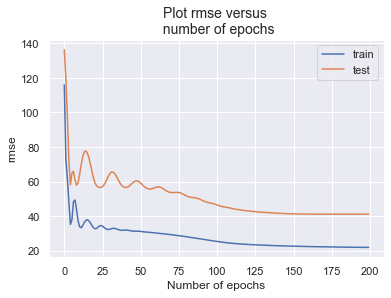

In [33]:
plt.plot(range(num_epochs), rmse_list_train)
plt.plot(range(num_epochs), rmse_list_test)
plt.xlabel("Number of epochs")
plt.ylabel("rmse")
plt.legend(['train', 'test'])
plt.title('Plot rmse versus \n number of epochs', fontsize=14)
plt.show() 

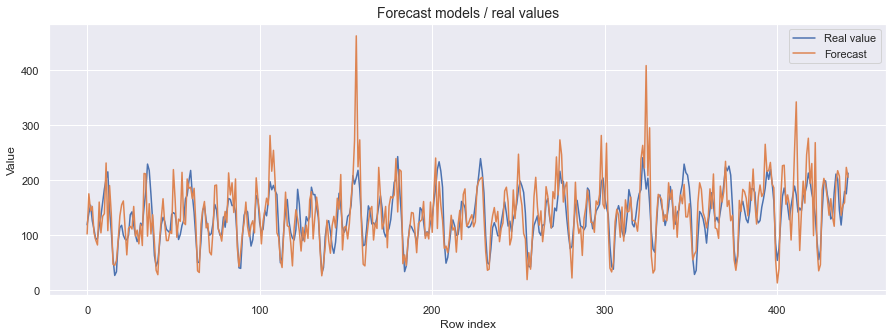

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(range(len(preds_test.detach().numpy())), preds_test.detach().numpy())
plt.plot(range(len(y_test.detach().numpy())), y_test.detach().numpy())
plt.xlabel("Row index")
plt.ylabel("Value")
plt.legend(['Real value', 'Forecast'])
plt.title('Forecast models / real values', fontsize=14)
plt.show() 

Based on the graph, it can be seen how, in general, the model guesses the trend, although some outliers are still present. Nevertheless, it can be stated that the seasonality curve of the model is similar to the seasonality curve of real values.

## General conclusion

During this project, a statistical analysis of the data was performed.

As a result of the analysis, hours of peak load (00:00) and minimum (6:00) were established. A steady increase in the number of orders over time was also found.

3 models were trained. Linear regression, neural network and gradient boosting. The best result was shown by a neural network with an RMSE value on a validation set of 30.3. Linear regression and boosting 25.4 and 25.1 respectively.


The best RMSE on the test sample was 41.06. Which is less than required by 15%.